# **Machine Learning Projects (40%)** 
# **Model Training Jupyter Notebook**
# **Project Title: Predictive Modeling of Irish Public Transport Delays Using Real-Time GTFS API and Static Reference Data**
### Name: Tan Pei Wen (Wendy)
### Student ID: D00253240   

##### This jupyter notebook provides the complete Machine Learning code for the Machine Learning Project.The dataset used as input is: `dataProject_Wendy_PeiWenTan_snapshot_2024-12-16_0234pm-0245pm_d00253240.csv` 

##### **The Data Mining and Data Analysis Jupyter Notebook for Data Mining Projects (40%)  cover the process of sourcing this datasets and data analysis before carried out this model training jupyter notebook**  

##### **This Model Training Jupyter Notebook implements a comprehensive machine learning pipeline to predict transport service delays and identify operational patterns in Irish public transport services.**


## **Table of Contents**

1. [Business Understanding](#step-1-business-understanding) 
2. [Data Preparation](#step-2-data-preparation) 
3. [Data Understanding](#step-3-data-understanding) 
4. [Data Cleaning](#step-4-data-cleaning) 
5. [Feature Engineering](#step-5-feature-engineering)
6. [Model Development](#step-6-model-development)
7. [Model Evaluation](#step-7-model-evaluation)
8. [Dimensionality Reduction with PCA](#step-8-dimensionality-reduction-with-pca)
9. [Explainable AI with LIME](#step-9-explainable-ai-with-lime)   
10. [Findings and Discussion](#step-10-findings-and-discussion)    
11. [References](#references)   



## Import Necessary Libraries 

In [28]:

import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, roc_auc_score, ConfusionMatrixDisplay)

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import lime
import lime.lime_tabular
from scipy.stats import chi2_contingency

<a name="step-1-business-understanding"></a>
##  **Step 1: Business Understanding**  

### **Problem Statement**   
The Irish Transport for Ireland (TFI) system faces critical challenges in providing reliable and punctual service across its multi-modal transport network. These challenges directly impact passenger satisfaction, operational efficiency and the broader goal of increasing public transport adoption in Ireland to meet environmental sustainability. Real-time delays, unpredictable service patterns and inefficient resource allocation contribute to passenger frustration, reduced ridership and increased operational costs.   

Service delays are not merely an inconvenience as they represent a fundamental threat to the public transport as a sustainable alternative to private car usage. When passengers cannot rely on published schedules, they are more likely to abandon public transport entirely leading to increased traffic congestion, higher carbon emissions and reduced revenue for transport operators.

This project leverages **real-time General Transit Feed Specification (GTFS) API data from Transport for Ireland** to identify, analyze and address key operational challenges through advanced data mining techniques including clustering, dimensionality reduction and predictive analytics. By understanding delay pattern the transport authorities can make data-driven decisions to improve service quality and operational efficiency.   


**Overview of the Organization:**
Transport for Ireland (TFI) is the national public transport integration agency, operating under the National Transport Authority (NTA). TFI is responsible for integrating and improving public transport services across the Republic of Ireland.  

The **services** including Bus in urban and intercity, rail such as commuter and intercity, tram (LUAS), regional transport. 


### **Business Problems**  

1. **Prediction of Service Delays**:
   - Identify patterns in transportation service delays to allow better passenger 
     communication and resource allocation.
   - **Target variable:** is_delayed (binary: 1=delayed, 0=on-time/early)  

2. **Clustering of Route Performance**:
   - Group routes with similar delay patterns to optimize scheduling and resource 
     deployment.
   - Identify high-performing vs. problematic route clusters  

3. **Dimentionality Reduction**:
   - Apply PCA to identify key operational factors driving service delays
   - Simplify complex operational data while retaining predictive power   



### Importance to Transport Industry  
These analyses are critical because:
- Service reliability directly impacts passenger satisfaction and public transport adoption
- Data-driven optimization on scheduling can potentially reduces operational costs
- Predicting delay information can potentially improve passenger experience and trust  
- Resource allocation can be optimized based on route performance clusters

### The value of machine learning
A machine learning approach provides:
- Delay prediction for passenger information systems   
- Scalable solutions applicable across the entire transport network
- Data-driven evidence for policy and operational decisions   
- Continuous improvement through model retraining with new data

<a name="step-2-data-preparation"></a>
##  **Step 2:  Data Preparation**  


### **2.1 Overview of Data Mining Process**
##### **For detailed data mining implementation, please refer to `DataMining_PeiWenTan_Wendy.ipynb`**  which I developed for the Data Mining Projects. 

The data mining process for my project involved collecting real-time public transport data from Transport for Ireland's GTFS Realtime API, enriching it with static reference data, performing feature engineering to creating a clean and data analysis ready dataset. The entire pipeline was designed to be **reproducible** and **well-documented** for academic purposes.     

**Data Collection Date:** December 16, 2024  
**Data Collection Time:** 2:34pm and 2:45pm  
**Final Output:** `dataProject_Wendy_PeiWenTan_snapshot_2024-12-16_0234pm-0245pm_d00253240.csv`

--- 

### **2.2 Data Sources**   
#### **2.2.1 Primary Data Source is TFI GTFS Realtime API**

**API Endpoints:**
- **Vehicle Positions:** `https://api.nationaltransport.ie/gtfsr/v2/Vehicles`
  - It provides real-time GPS coordinates of all active vehicles 
  - It updates every few seconds as vehicles move 
  - This returns: vehicle_id, route_id, trip_id, latitude, longitude, timestamp
  
- **Trip Updates:** `https://api.nationaltransport.ie/gtfsr/v2/TripUpdates`
  - It provides real-time delay information for scheduled trips
  - It updates based on actual versus scheduled arrival/departure times
  - Returns: trip_id, route_id, stop_id, arrival_delay, departure_delay, timestamp

**Authentication:**
- **Method:** API Key-based authentication via HTTP headers
- **Obtained from:** National Transport Authority Developer Portal
- **Registration process:** Created developer account at `https://developer.nationaltransport.ie/profile`
- **API key format:** Alphanumeric string passed in `x-api-key` header


#### **2.2.2 Secondary Data Source: GTFS Static Schedule Data**

**Source:** `https://www.transportforireland.ie/transitData/Data/GTFS_Realtime.zip`

**Purpose:**  
The real-time API returns **ID values** for example `route_id`, `agency_id`, `stop_id` without descriptive names. The static GTFS data provides **reference lookup tables** to make the data human-readable and contextually meaningful.   

**Key Reference Files:**

| File | Description | Key Fields | Usage in Project |
|------|-------------|------------|------------------|
| **agency.txt** | Transport operator information | `agency_id`, `agency_name`| Map agency_id to operator names for example Dublin Bus, Bus Éireann and etc |
| **routes.txt** | Route details and operator mappings | `route_id`, `agency_id`, `route_short_name`, `route_long_name` | Convert route_id to route numbers  |
| **trips.txt** | Individual trip information | `trip_id`, `route_id`, `trip_headsign`| Link trip_id to destinations and service patterns |
| **stops.txt** | Bus/tram/train stop locations | `stop_id`, `stop_name`, `stop_lat`, `stop_lon` | Map stop_id to stop names and geographic coordinates |

**Update Frequency:**  
Static GTFS data is relatively stable updated weekly or monthly when route schedules change.

--- 

### **2.3 Data Mining Pipeline**  

I have summarize the Data Mining pipeline into 8 steps 

#### **Step 1: API Authentication**

**Objective:** Establish secure connection to TFI API endpoints  

**Process:**
1. Registered at National Transport Authority developer portal
2. Generated API key from developer account dashboard
3. Configured HTTP request headers with authentication credentials
4. Tested API connectivity with sample requests

**Outcome:** Successful authentication enabling access to real-time feeds


#### **Step 2: Protocol Buffer Parsing**

**Objective:** Decode binary Protocol Buffer data format returned by API

**Challenge Encountered:**  
Initial attempts to parse API responses as JSON failed. The API returns data in **Google Protocol Buffer format** which is a binary-encoded structured data, not standard JSON.

**Solution:**
- Imported `google.transit.gtfs_realtime_pb2` library (GTFS Realtime Python bindings)
- Used `ParseFromString()` method to decode binary feed into Python objects
- Implemented `HasField()` checks to safely access nested optional fields

**Outcome:** Successfully decoded real-time Protocol Buffer feeds into structured Python data


#### **Step 3: Data Collection of Vehicle Position**

**Objective:** Fetch real-time GPS locations of all active vehicles by creating a function 

**Data Fetched:**

| Variable | Description | Data Type | Example |
|----------|-------------|-----------|---------|
| vehicle_id | Unique vehicle or bus identifier | String | "8", "33445" |
| route_id | Route identifier from GTFS | String | "5186_117281" |
| trip_id | Unique identifier for specific trip | String | "5186_2573" |
| latitude | Current vehicle latitude | Float | 52.26310348 |
| longitude | Current vehicle longitude | Float | -7.11568021 |
| timestamp | Time of position report  | Integer | 1702736040 |

**Data Transformation:**
- Converted UNIX timestamps to human-readable datetime format (`YYYY-MM-DD HH:MM:SS`)
- Removed records with missing position data

**Outcome:** Dataset containing approximate  16000+ real-time vehicle location records


#### **Step 4: Data Collection of Trip Update**

**Objective:** Fetch real-time delay information for scheduled trips by creating a function 

**Data Fetched:**

| Variable | Description | Data Type | Unit | Interpretation |
|----------|-------------|-----------|------|----------------|
| trip_id | Unique trip identifier | String | Non Available | Links to vehicle positions |
| route_id | Route identifier | String | Non Available | Route being operated |
| stop_id | Bus stop identifier | String | Non Available | Specific stop along route |
| arrival_delay | Arrival delay at stop | Integer | Seconds | Negative = early, Positive = late |
| departure_delay | Departure delay from stop | Integer | Seconds | Negative = early, Positive  late |
| timestamp | Time of update | DateTime | Non Available | When delay was recorded |

**Important: Delay Value Interpretation**
- **Negative values** for example -30: Vehicle is **early** by 30 seconds
- **Zero or near-zero**: Vehicle is **on time**
- **Positive values** for example +180: Vehicle is **delayed** by 180 seconds (3 minutes)



#### **Step 5: Data Merging**

**Objective:** Combine vehicle positions, trip updatesand static reference data into combined dataset

**Merge Strategy:**

Merging on API level  
1. **Vehicle Positions + Trip Updates**  Merged on both route_id, trip_id    

Merging API to Static level  
1. **Vehicle Positions + Trip Updates** merged with Static GTFS (route.txt)    **Merged on (route_id)**
2. **Vehicle Positions + Trip Updates + Static GTFS (route.txt)** merged with Static GTFS (agency.txt)    **Merged on (agency_id)**
3. **Vehicle Positions + Trip Updates + Static GTFS (route.txt) + Static GTFS (agency.txt)** merged with Static GTFS (trips.txt)    **Merged on (trip_id)**
4. **Vehicle Positions + Trip Updates + Static GTFS (route.txt) + Static GTFS (agency.txt) + Static GTFS (trips.txt)** merged with Static GTFS (stops.txt)     **Merged on (stop_id)**
5. **Final merged datasets** : **Vehicle Positions + Trip Updates + Static GTFS (route.txt) + Static GTFS (agency.txt) + Static GTFS (trips.txt) + Static GTFS (stops.txt)**

**Merge Type:** Inner join 
**Common Keys:** `route_id`, `trip_id`, `agency_id`, `stop_id`   
**Outcome:** Comprehensive dataset combining real-time and contextual information


#### **Step 6: Feature Engineering**   
**Objective:** Create derived features for analysis and predictive modeling

**New Features Created:**  
##### **1. Target Variable: `is_delayed`**
- **Type:** Binary (0 or 1)
- **Definition:** `1` if `arrival_delay > 0` else `0`
- **Purpose:** Response variable for classification models to predict service delays     

##### **2. Categorical Feature: `delay_severity`**
- **Type:** Ordinal categorical (5 levels)
- **Categories:**
  - `Very_Early`: delay < -60 seconds (more than 1 minute early)
  - `On_Time`: -60 <= delay <= 0 seconds (on time or slightly early)
 :`Minor_Delay`: 0 < delay <= 300 seconds (up to 5 minutes late)
 :`Major_Delay`: 300 < delay <= 600 seconds (5-10 minutes late)
 :`Severe_Delay`: delay > 600 seconds (more than 10 minutes late)
- **Purpose:** classification of service quality for data analysis

##### **3. Geographic Feature: `distance_from_center_km`**
- **Type:** Continuious Numerical
- **Calculation Method:** Haversine formula for great-circle distance
- **Reference Point:** Dublin City Center (53.349805N, 6.260310W)
- **Formula:**  

  a = sin^2( difference in latitudes between two points/2) + cos(lat1) × cos(lat2) × sin²(difference in longitude between two points/2)  
  c = 2 × atan2(sqrt(a), sqrt(1−a))  
  distance = R × c  (where R = Earth's radius = 6371 km)  

- **Purpose:** Investigate correlation between distance from city center and service reliability
- **Range:** 0-200+ km can be categorize into urban routes <10 km, suburban 10-50 km and intercity >50 km    
**Outcome:** Dataset expanded from 10 to 13 variables with analytically meaningful features    


#### **Step 7: Data Cleaning**

**Objective:** Remove duplicates and handle missing values to ensure data quality

##### **7.1 Remove any Duplicate**

**Process:**
- Removes any duplicate rows that may have resulted from the merge operation   
- The `inplace=True` parameter modifies the DataFrame directly without creating a copy


##### **7.2 Missing Value Analysis**

**Before Cleaning:**

| Variable | Missing Count | Missing % |
|----------|---------------|-----------|
| `arrival_delay` | 765 (However this vaue might be change everytime running the Data Mining Pipeline as It is fetch from API)| 4.7% |
| `departure_delay` | 791 (However this vaue might be change everytime running the Data Mining Pipeline as It is fetch from API)| 4.9% |
| All other variables | 0 | 0% |

**Root Cause Analysis:**  
Missing delay values occur when:
- Vehicle has not yet reached the stop, future stops on route   
- API data transmission issues

**Handling Strategy:**

**Decision:** Fill missing delay values with **0** (zero seconds)

**Rationale:**
1. When delay is not reported, assume on-time operation
2. TFI API tends to report delays only when they occur
3. Dropping rows would lose 4.7% of data (765 observations)
4. Filling with 0 may slightly underestimate true delay rates, but preserves sample size


**After Cleaning:**
| Variable | Missing Count | Missing % |
|----------|---------------|-----------|
| All variables | 0 | 0% |

**Outcome:** Complete dataset with zero missing values, ready for analysis


### **Step 8: Save Final Dataset and Create Timestamped Snapshot Datasets**

**Objective:** Create timestamped and reproducible dataset for data analysis

**Challenge with Real-Time Data:**  
GTFS Realtime API provides **continuously changing data**. Running the data collection code at different times produces different datasets because:
- Vehicle positions change every few seconds
- Delay values update as traffic conditions change 
- Active vehicle count varies by time of day

**Solution: Create Timestamped Snapshot Datasets**

**Snapshot Details:**
- **Collection Date:** December 16, 2024 (Monday)
- **Collection Time:** 2:34pm & 2:45pm (2 points in time data collection)
- **Snapshots Combined:** Multiple API calls in 2 points in time and merged into single dataset to obtain 16170 observation/rows as required by this data mining and machine learning joint project. 
- **Filename Convention:** `dataProject_Wendy_PeiWenTan_snapshot_2024-12-16_0234pm-0245pm_d00253240.csv`

**Filename Components:**
- `dataProject`: Project identifier
- `Wendy_PeiWenTan`: Student name
- `snapshot`: Indicates point-in-time capture
- `2024-12-16`: Collection date (YYYY-MM-DD)
- `0234pm & 0245pm`: Collection time 
- `d00253240`: Student ID

**The Benefits:**
1. The analysis results remain consistent across multiple runs
2.  Others can verify findings using same snapshot datsaets   

**Output CSV file Created:**
1. **`Realtime_Datasets_DM_PeiWenTan_Wendy_D00253240_TFI_GTFS.csv`**  
  :Live dataset that updates with each code execution
  :Used during data mining development
   
2. **`dataProject_Wendy_PeiWenTan_snapshot_2024-12-16_0234pm-0245pm_d00253240.csv`** 
  :**Timestamped snapshot for data analysis**
  :**This is the dataset used in this Data Analysis notebook**
  :Created for reproducibility for this data analysis jupyter notebook.

---

### **2.4 Final Dataset Characteristics**

#### **Dataset Dimensions**
- This is the final combined and cleaned datasets: `dataProject_Wendy_PeiWenTan_snapshot_2024-12-16_0234pm-0245pm_d00253240`
- **Total Rows:** 16099  observations
- **Total Columns:** 20 variables
- **Encoding:** UTF-8 

#### **Temporal Characteristics of Dataset**
- **Date:** December 16, 2024 (Monday)
- **Time:** 2:34pm & 2:45pm 


---

### **2.5 Data Quality Summary**

- **Zero missing values** after cleaning (100% completeness)  
- **No duplicate records**  
- **Real-time accuracy** direct from authoritative API  
-  **Enriched context** which merged with static GTFS reference data
-  **Standardized format** with consistent variable types and encoding 
- **Reproducible** with timestamped snapshot and documented collection process   



## **Loading the Datasets**

In [29]:
df = pd.read_csv(r"C:/Users/user/OneDrive - Dundalk Institute of Technology/Desktop/Dkit/Dkit 2025/Data Mining/40_DM_Projects_PeiWenTan_Wendy_D00253240/dataProject_Wendy_PeiWenTan_snapshot_2024-12-16_0234pm-0245pm_d00253240.csv", encoding='utf-8-sig')
display(df.head())
display(df.info())
display(f"Total rows: {len(df):,}")
display(f"Total columns: {len(df.columns)}")

,trip_id,route_id,vehicle_id,stop_id,latitude,longitude,arrival_delay,departure_delay,timestamp_y,is_delayed,delay_severity,distance_from_center_km,agency_id,route_short_name,route_long_name,agency_name,trip_headsign,stop_name,stop_lat,stop_lon
0,5186_2573,5186_117281,8,8440B3525801,52.263103,-7.11568,0,38,12/16/2025 14:34,0,On_Time,134,7778008,W4,Peter Street - Brownes Road,Bus Éireann Waterford,Brownes Road/SETU,The Clock Tower,52.261859,-7.110800
1,5186_2573,5186_117281,8,8440B3525901,52.263103,-7.11568,210,223,12/16/2025 14:34,1,Minor_Delay,134,7778008,W4,Peter Street - Brownes Road,Bus Éireann Waterford,Brownes Road/SETU,Waterford Bus Station,52.263113,-7.116210
2,5186_2573,5186_117281,8,8440B3524201,52.263103,-7.11568,213,221,12/16/2025 14:34,1,Minor_Delay,134,7778008,W4,Peter Street - Brownes Road,Bus Éireann Waterford,Brownes Road/SETU,Thomas Street,52.261858,-7.117832
3,5186_2573,5186_117281,8,8440B3526201,52.263103,-7.11568,322,337,12/16/2025 14:34,1,Major_Delay,134,7778008,W4,Peter Street - Brownes Road,Bus Éireann Waterford,Brownes Road/SETU,Morgan Street,52.261268,-7.121872
4,5186_2573,5186_117281,8,8440B3526301,52.263103,-7.11568,514,517,12/16/2025 14:34,1,Major_Delay,134,7778008,W4,Peter Street - Brownes Road,Bus Éireann Waterford,Brownes Road/SETU,Congress Place,52.260383,-7.129873


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16169 entries, 0 to 16168
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   trip_id                  16169 non-null  object 
 1   route_id                 16169 non-null  object 
 2   vehicle_id               16169 non-null  int64  
 3   stop_id                  16169 non-null  object 
 4   latitude                 16169 non-null  float64
 5   longitude                16169 non-null  float64
 6   arrival_delay            16169 non-null  int64  
 7   departure_delay          16169 non-null  int64  
 8   timestamp_y              16169 non-null  object 
 9   is_delayed               16169 non-null  int64  
 10  delay_severity           16169 non-null  object 
 11  distance_from_center_km  16169 non-null  int64  
 12  agency_id                16169 non-null  int64  
 13  route_short_name         16169 non-null  object 
 14  route_long_name       

None

'Total rows: 16,169'

'Total columns: 20'

<a name="step-3-data-understanding"></a>
##  **Step 3: Data Understanding**    


### **Dataset Overview**

This analysis utilizes a **timestamped snapshot dataset** of real-time public transport operations in Ireland, collected from the Transport for Ireland (TFI) GTFS Realtime API. The dataset captures the operational state of Ireland's multi-modal public transport network during a specific 2 points in time, providing a comprehensive view of service performance across multiple operators and geographic regions.

**Dataset Name:**  
`dataProject_Wendy_PeiWenTan_snapshot_2024-12-16_0234pm-0245pm_d00253240.csv`

**Dataset Type:** Cross-sectional snapshot (point-in-time capture)   
**Data Source:** Transport for Ireland (TFI) GTFS Realtime API + Static GTFS Reference Data

### **Metadata of Data Collection**

| Attribute | Details |
|-----------|---------|
| **Collection Date** | Monday, December 16, 2024 |
| **Collection Time** | 2:34pm & 2:45pm  |
| **Day Type** | Weekday, Monday  |
| **Collection Method** | Automated API polling with Python script in Jupyter Notebook |
| **Student Name** | Tan Pei Wen (Wendy) |
| **Student ID** | D00253240 |
| **Project Title** | Clustering and Predictive Modeling of Service Delays in Irish Public Transport |  


### **Dataset Dimensions**   
#### **Dataset Size**    

| Metric | Value |
|--------|-------|
| **Total Rows/Observations** | **16099** |
| **Total Columns/Variables** | **20** |  
| **Data Encoding** | UTF-8 (supports international characters) |

**Interpretation:**
- Each **row** represents a unique **vehicle-stop observation** at a specific point in time
- For Example: Bus #8 on route W4 approaching stop "The Clock Tower" at 14:34
- 16099  observations capture the state of Ireland's public transport network. 
- 20 variables provide multi-dimensional view of each observation.  

--- 

### **The Description of Variable in Table**

|No| Variable | Type | Non-Null Count | Description |
|----------|----------|------|----------------|-------------|
|1. | **trip_id** | object | 16099  | Unique identifier for specific trip |
|2. | **route_id** | object | 16099  | Route identifier/number |
|3.| **vehicle_id** | int64 | 16099  | Unique vehicle/bus ID |
|4. | **stop_id** | object | 16099  | Bus stop identifier |
|5. | **latitude** | float64 | 16099  | Current vehicle latitude (GPS) |
|6. | **longitude** | float64 | 16099  | Current vehicle longitude (GPS) |
|7. | **arrival_delay** | int64 | 16099  | Arrival delay in seconds (negative=early, positive=late) |
|8. | **departure_delay** | int64 | 16099  | Departure delay in seconds (negative=early, positive=late) |
|9. | **timestamp_y** | object | 16099  | Timestamp of data collection |
|10. | **is_delayed** | int64 | 16099  | Binary: 1=delayed, 0=on-time/early **(TARGET VARIABLE)** |
|11. | **delay_severity** | object | 16099  | Categorical delay classification:  `Very_Early`: delay < -60 seconds (more than 1 minute early), `On_Time`: -60 <= delay <= 0 seconds (on time or slightly early),  `Minor_Delay`: 0 < delay <= 300 seconds (up to 5 minutes late), `Major_Delay`: 300 < delay <= 600 seconds (5-10 minutes late), `Severe_Delay`: delay > 600 seconds (more than 10 minutes late) |
|12. | **distance_from_center_km** | int64 | 16099  | Distance from Dublin city center in kilometers |
|13. | **agency_id** | int64 | 16099  | Transport operator identifier |
|14. | **route_short_name** | object | 16099  | Short route name/number |
|15. | **route_long_name** | object | 16099  | Full route description |
|16. | **agency_name** | object | 16099  | Transport operator name |
|17. | **trip_headsign** | object | 16099  | Trip destination/headsign |
|18. | **stop_name** | object | 16099  | Bus stop name |
|19. | **stop_lat** | float64 | 16099  | Bus stop latitude |
|20. | **stop_lon** | float64 | 16099  | Bus stop longitude |

### **Key Variables for Analysis**

| Category | Variables | Purpose |
|----------|-----------|---------|
| **Target Variable** | is_delayed | Response variable for predictive modeling |
| **Delay Metrics** | arrival_delay, departure_delay, delay_severity | Primary analysis variables |
| **Geographic Features** | latitude, longitude, stop_lat, stop_lon, distance_from_center_km | Spatial analysis |
| **Operational IDs** | trip_id, route_id, vehicle_id, stop_id, agency_id | Data linkage and identification |
| **Contextual Information** | agency_name, route_short_name, route_long_name, trip_headsign, stop_name | Human-readable descriptions |
| **Temporal Data** | timestamp_y | Time-based analysis |  


---

### **The Data Type and Relevancy of Variable in Predictive Modelling**

|No.| Variable | Data Type | Purpose | Relevance for Modeling |
|----------|----------|-----------|---------|------------------------|
|1. | trip_id | Nominal Categorical Data | Identifier | No (Identifier) |
|2. | route_id | Nominal Categorical Data | Identifier | No (Identifier) |
|3. | vehicle_id | Nominal Categorical Data | Identifier | No (Too many unique values) |
|4.| stop_id | Nominal Categorical Data  | Identifier | No (Identifier) |
|5. | latitude | Continuious Numerical Data | Explanatory | Yes |
|6. | longitude | Continuious Numerical Data | Explanatory | Yes |
|7. | arrival_delay | Continuois Numerical Data | Explanatory | Yes |
|8. | departure_delay | Continuious Numerical Data | Explanatory | Yes |
|9. | timestamp_y | Temporal | Explanatory | Yes (extract hour/minute) |
|10. | **is_delayed** | **Binary Categorical Data** | **Response Variable (Target)** | **TARGET VARIABLE** |
|11. | delay_severity | Ordinal Categorical Data | Explanatory | Yes |
|12. | distance_from_center_km | Continious Numerical Data | Explanatory | Yes |
|13. | agency_id | Nominal Categorical Data | No (Identifier) | No |
|14. | route_short_name | Nominal Categorical Data | Explanatory | Yes |
|15. | route_long_name | Nominal Categorical Data | Explanatory | Yes |
|16. | agency_name | Nominal Categorical Data | Explanatory | Yes |
|17. | trip_headsign | Nominal Categorical Data | Explanatory | Yes |
|18. | stop_name | Nominal Categorical Data | Explanatory | Yes |
|19. | stop_lat | Continuious Numerical Data | Explanatory | Yes |
|20. | stop_lon | Continuious Numerical Data | Explanatory | Yes |   


### **Summary of Variable by Data Type**


| Data Type | Count | Variables |
|-----------|-------|-----------|
| **Numerical** | 7 | latitude, longitude, arrival_delay, departure_delay, distance_from_center_km, stop_lat, stop_lon |
| **Categorical** | 12 | trip_id, route_id, vehicle_id, stop_id, is_delayed, delay_severity, agency_id, route_short_name, route_long_name, agency_name, trip_headsign, stop_name |
| **Temporal** | 1 | timestamp_y |

### **By Purpose**
| Purpose | Count | Variables |
|---------|-------|-----------|
| **Response (Target)** | 1 | **is_delayed** |
| **Explanatory** | 14 |  latitude, longitude, arrival_delay, departure_delay, timestamp_y, delay_severity, distance_from_center_km, route_short_name,route_long_name, agency_name, trip_headsign,stop_name, stop_lat, stop_lon |
| **Identifier** | 5 | trip_id, vehicle_id, route_id,  stop_id, agency_id|

### **By Modeling Relevance**
| Relevance | Count | 
|-----------|-------|
| **Yes (Use in Modeling)** | 14 | 
| **No (Exclude from Modeling)** | 5 | 


In [30]:
print("Dataset Dimensions")
print(f"Total number of rows: {len(df):,}")
print(f"Total number of columns: {len(df.columns)}")

print("First 5 rows of dataset:")
display(df.head())
print(df.info())  

Dataset Dimensions
Total number of rows: 16,169
Total number of columns: 20
First 5 rows of dataset:


,trip_id,route_id,vehicle_id,stop_id,latitude,longitude,arrival_delay,departure_delay,timestamp_y,is_delayed,delay_severity,distance_from_center_km,agency_id,route_short_name,route_long_name,agency_name,trip_headsign,stop_name,stop_lat,stop_lon
0,5186_2573,5186_117281,8,8440B3525801,52.263103,-7.11568,0,38,12/16/2025 14:34,0,On_Time,134,7778008,W4,Peter Street - Brownes Road,Bus Éireann Waterford,Brownes Road/SETU,The Clock Tower,52.261859,-7.110800
1,5186_2573,5186_117281,8,8440B3525901,52.263103,-7.11568,210,223,12/16/2025 14:34,1,Minor_Delay,134,7778008,W4,Peter Street - Brownes Road,Bus Éireann Waterford,Brownes Road/SETU,Waterford Bus Station,52.263113,-7.116210
2,5186_2573,5186_117281,8,8440B3524201,52.263103,-7.11568,213,221,12/16/2025 14:34,1,Minor_Delay,134,7778008,W4,Peter Street - Brownes Road,Bus Éireann Waterford,Brownes Road/SETU,Thomas Street,52.261858,-7.117832
3,5186_2573,5186_117281,8,8440B3526201,52.263103,-7.11568,322,337,12/16/2025 14:34,1,Major_Delay,134,7778008,W4,Peter Street - Brownes Road,Bus Éireann Waterford,Brownes Road/SETU,Morgan Street,52.261268,-7.121872
4,5186_2573,5186_117281,8,8440B3526301,52.263103,-7.11568,514,517,12/16/2025 14:34,1,Major_Delay,134,7778008,W4,Peter Street - Brownes Road,Bus Éireann Waterford,Brownes Road/SETU,Congress Place,52.260383,-7.129873


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16169 entries, 0 to 16168
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   trip_id                  16169 non-null  object 
 1   route_id                 16169 non-null  object 
 2   vehicle_id               16169 non-null  int64  
 3   stop_id                  16169 non-null  object 
 4   latitude                 16169 non-null  float64
 5   longitude                16169 non-null  float64
 6   arrival_delay            16169 non-null  int64  
 7   departure_delay          16169 non-null  int64  
 8   timestamp_y              16169 non-null  object 
 9   is_delayed               16169 non-null  int64  
 10  delay_severity           16169 non-null  object 
 11  distance_from_center_km  16169 non-null  int64  
 12  agency_id                16169 non-null  int64  
 13  route_short_name         16169 non-null  object 
 14  route_long_name       

<a name="step-4-data-cleaning"></a>
## **Step 4: Data Cleaning**    

### **4.1 Overview: Data Cleaning in the Data Mining Pipeline**

**Important Note on Data Cleaning Approach:**
The majority of data cleaning activities were performed **during the data mining process** in the Data Mining Jupyter notebook **`DataMining_PeiWenTan_Wendy.ipynb`**. Data is cleaned throughout the process in data mining, ensuring the final dataset is already prepared for data analysis. 

**Why Clean During Data Mining?**
- Ensures data quality problems are addressed before they affect later steps
- Catches and fixes problems where the data is collected from the API
- Reduces redundant cleaning steps in analysis phase
- Creates a reliable and reproducible dataset snapshot

**This section performs:**
1. **Validation checks** to confirm data quality from the data mining process
2. **Final verification** of missing values and duplicates
3. **Outlier analysis** to understand extreme values
4. **Documentation** of data quality status for academic transparency   

### **4.2 Data Cleaning Performed In Data Mining Jupyter Notebook**

The following data cleaning steps were completed in **`DataMining_PeiWenTan_Wendy.ipynb`** (Step 8 of the data mining process):

#### **Step 8: Data Cleaning (from Data Mining Notebook)**

**Objective:** Remove duplicates and handle missing values to ensure data quality

Data cleaning is a critical step to prepare the merged dataset for analysis. This process removes duplicate records and addresses missing values that could affect the accuracy of insights and visualizations.


#### **Data Cleaning Steps:**
##### **1. Duplicate Removal**
**Process:**
- Identified and removed duplicate rows resulting from merge operations
- Ensured each record represents a unique vehicle-trip-stop combination
- Modified DataFrame directly to remove duplicates
**Outcome:**
- Duplicate records removed
- Each observation is unique 

##### **2. Missing Value Analysis Before Cleaning**

**Assessment:**
Identified data quality issues by counting missing (NaN/null) values in each column.

**Key Findings:**

| Column | Missing Values | Percentage |
|--------|----------------|------------|
| arrival_delay | 765 (This is not constant as the data is fetch from API so it chnage everytime running the Data Mining Pipeline) | 4.73% |
| departure_delay | 791 (This is not constant as the data is fetch from API so it chnage everytime running the Data Mining Pipeline) | 4.89% |
| All other columns | 0 | 0% |

**Root Cause Analysis:**
- Missing delay values occur when:
  - Vehicle has not yet reached the stop (future stops on route)
  - API delay reporting failed or timed out
  - Stop was skipped or service disrupted

##### **3. Missing Value Handling Strategy**

**Decision:** Fill missing delay values with **0 (zero seconds)**

**Rationale:**
1. **Conservative Assumption:** When delay is not reported, assume on-time operation
2. **API Behavior Pattern:** TFI API tends to report delays explicitly when they occur; absence typically indicates normal operation
3. **Data Preservation:** Filling with 0 retains 765 + 791 = 1,556 observations (9.62% of dataset)
4. **Analytical Impact:** May slightly underestimate true delay rates, but preserves sample size for statistical power
5. **Alternative Considered:** Dropping rows with missing delays would reduce dataset from 16099  to 14,613 observations (9.6% loss)

**Justification:**
- Missing delays typically indicate **absence of disruption** but not absence of data
- Zero is the most reasonable imputation for "unreported = on-time" assumption
- This approach prevents systematic bias toward excluding on-time services


##### **4. Missing Value Analysis (After Cleaning)**
**Verification:**

| Column | Missing Values | Status |
|--------|----------------|--------|
| All 20 columns | 0 | Complete |

**Result:** 100% data completeness achieved


#### **Summary of Data Quality Improvements**

| Stage | arrival_delay Missing | departure_delay Missing | Total Missing |
|-------|----------------------|------------------------|---------------|
| **Before Cleaning** | 765 (4.73%) | 791 (4.89%) | 1,556 (9.62%) |
| **After Cleaning** | 0 (0%) | 0 (0%) | 0 (0%) |
| **Improvement** | +765 records | +791 records | +1,556 records |

*Note: The arrival_delay and departure_delay are not constant as the data is fetch from API so it chnage everytime running the Data Mining Pipeline.* 


**Final Outcome:**
- Clean and non-duplicated dataset with zero missing values
- All 16099  observations retained for analysis
- Delay values imputed with on-time assumption (0 seconds)
- Dataset ready for exploratory data analysis and modeling



### **4.3 Data Quality Verification performed in Data Analysis Notebook**

The dataset **`dataProject_Wendy_PeiWenTan_snapshot_2024-12-16_0234pm-0245pm_d00253240.csv`** has been cleaned during the data mining process. This section performs **validation checks** to confirm data quality before proceeding with analysis.

---

#### **1. Identify Zero Coordinates Vehicles**   

It is important to identify the zero coordinate vehicle before running the data analysis as this is an error and might affect the clustering if include the zero coordinate vehicle.   

- Rows before removing zero coordinates: 16099 
- Number of rows with zero latitude or longitude: 70
- Rows after removing zero coordinates: 16099

#### **2. Missing Values Verification**

**Objective:** Confirm no missing values remain in the dataset

**Result:**
- No missing values found across all variables

**Interpretation:**
- Zero missing values detected across all 20 variables
- Data mining cleaning process was successful
- No additional missing value handling required


#### **3. Duplicate Records Verification**   
**Objective:** Confirm no duplicate observations in the dataset

**Result:**
- Number of duplicate rows: 0

**Interpretation:**
- Zero duplicate records
- Each observation represents a unique vehicle-trip-stop combination
- Data integrity maintained


#### **4. Outlier Detection Using IQR Method**

**Objective:** Identify extreme values in numerical variables.  

**Methodology:**
- **Interquartile Range (IQR) Method:**
  - Q1 = 25th percentile, Q3 = 75th percentile
  - IQR = Q3 - Q1
  - Lower bound = Q1 - 1.5 × IQR
  - Upper bound = Q3 + 1.5 × IQR
  - Outliers = values < lower bound OR > upper bound


##### **4. Outlier Analysis Results:**

**1. Latitude**  
**Statistics:**  
- Q1: 53.28, Q3: 53.38, IQR: 0.10
- Outliers detected: 3913 (24.31%)
- Range: [51.59, 55.00]

**Interpretation:**   
- **Q1-Q3 range :** Concentrated in Dublin area
- **(24.31%) outliers:** Services outside Greater Dublin Area for example Waterford, Cork, Galway, intercity routes  
- **Decision:** Retain Outliers which represent real geographic diversity, not errors


**2. Longitude**  
**Statistics:**
-  Q1: -6.71, Q3: -6.25, IQR: 0.45
-  Outliers detected: 3343 (20.77%)
-  Range: [-10.13, -6.04]

**Interpretation:**
- **Q1-Q3 range:** Dublin longitude corridor
- **(20.77%) outliers:** Western Ireland routes (Galway, Mayo, Kerry)   
- **Decision:** Retain Outliers as those represent valid western Ireland coverage 


**3. Arrival Delay**

**Statistics:**
-  Q1: 0.00, Q3: 422.00, IQR: 422.00
-  Outliers detected: 951 (5.91%)
-  Range: [-3496.00, 17055.00]

**Interpretation:**
- **Q1 = 0:** 25% of services are on-time or early
- **Q3 = 422 seconds (7 minutes):** 75% of services delayed =<7 minutes
- **5.91% outliers:** Extreme delays beyond typical operational variation   
- **Decision:** **Retain Outliers** As these represent real operational disruptions critical for analysis

**Why Retain Extreme Delays?**
1. **Research Objective** invloves understanding delay patterns, including severe disruptions
2.  Extreme delays are highest priority for TFI intervention
3.  Large delays occur in real-world operations such as accidents, breakdowns, traffic
4.  Removing outliers would underestimate true service 

**4. Departure Delay**  
**Statistics:**  
-  Q1: 0.00, Q3: 433.00, IQR: 433.00
-  Outliers detected: 867 (5.39%)
-  Range: [-3496.00, 8637.00]

**Interpretation:**
- **Similar pattern to arrival_delay** may be highly correlated variables
- **(5.39%) outliers:** Extreme departure delays  
- **Decision:** **Retain Outliers** it is the same rationale as arrival delays


**5. Distance from City Center**   
**Statistics:**
-  Q1: 4.00, Q3: 70.00, IQR: 66.00
-  Outliers detected: 3079 (19.13%)
-  Range: [0.00, 287.00]


**Interpretation:**
- **Q1 = 4 km:** Close to Dublin city center (urban routes)
- **Q3 = 70 km:** Suburban/regional routes
- **19.13% outliers:** Intercity and long-distance services


### **4.4 Summary on Outlier Analysis**

**Decision:** **Outliers in delay variables represent acceptable extreme delays and service disruptions. These are not data errors but important observations for understanding transport reliability issues. All outliers will be retained for analysis.**


**Why This Matters for Analysis:**
- **Clustering:** Outliers may form distinct "problem route" clusters requiring targeted intervention
- **Predictive Modeling:** Extreme delays provide training examples for worst-case scenarios
- **Business Value:** TFI's highest priority is addressing severe service disruptions represented by outliers
- **Data Integrity:** Removing real operational data would produce misleading results


### **4.5 Final Data Quality**

- **Zero missing values across all 20 variables**
- **From 16099  to 16099 observations after removed the zero coordinate vehicles observations**
- **Final datasets has 16099 observations**
- Zero duplicate records
- Unique vehicle-trip-stop combinations
- Timestamps consistent with collection window

### **4.6 Check class distribution**

#### **Target Variable Distribution (is_delayed)**
- 1 (Delayed): 11135
- 0 (Not Delaysed): 4964

#### **Class balance: is_delayed**
- 1 (Delayed): 0.691658
- 0 (Not Delaysed): 0.308342



In [31]:
print(f"Rows before removing zero coordinates: {len(df):,}")

zero_coords = df[(df['latitude'] == 0) | (df['longitude'] == 0)]
print(f"Number of rows with zero latitude or longitude: {len(zero_coords)}")

df = df.drop(
    df[(df['latitude'] == 0) | (df['longitude'] == 0)].index
).reset_index(drop=True)

print(f"Rows after removing zero coordinates: {len(df):,}")

Rows before removing zero coordinates: 16,169
Number of rows with zero latitude or longitude: 70
Rows after removing zero coordinates: 16,099


In [32]:

print("\n Missing Values Before Cleaning:")
missing_before = df.isnull().sum()
print(missing_before)
if missing_before.sum() == 0:
    print("No missing values found!")  
    
    

print(f"\n Check for Duplicate Rows:")
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Duplicates removed. New row count: {len(df):,}")  
    
    
    
print("Outlier Detection (Using IQR Method)")

numerical_cols = ['latitude', 'longitude', 'arrival_delay', 'departure_delay', 'distance_from_center_km']

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"\n{col}:")
    print(f"  Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
    print(f"  Outliers detected: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
    print(f"  Range: [{df[col].min():.2f}, {df[col].max():.2f}]")

print("\nDecision: Outliers in delay variables represent acceptable extreme delays.")
print("These are not errors but important data points for understanding service disruptions.")
print("Outliers will be retained for analysis.")


 Missing Values Before Cleaning:
trip_id                    0
route_id                   0
vehicle_id                 0
stop_id                    0
latitude                   0
longitude                  0
arrival_delay              0
departure_delay            0
timestamp_y                0
is_delayed                 0
delay_severity             0
distance_from_center_km    0
agency_id                  0
route_short_name           0
route_long_name            0
agency_name                0
trip_headsign              0
stop_name                  0
stop_lat                   0
stop_lon                   0
dtype: int64
No missing values found!

 Check for Duplicate Rows:
Number of duplicate rows: 0
Outlier Detection (Using IQR Method)

latitude:
  Q1: 53.28, Q3: 53.38, IQR: 0.10
  Outliers detected: 3913 (24.31%)
  Range: [51.59, 55.00]

longitude:
  Q1: -6.71, Q3: -6.25, IQR: 0.45
  Outliers detected: 3343 (20.77%)
  Range: [-10.13, -6.04]

arrival_delay:
  Q1: 0.00, Q3: 422.00, IQR: 

In [33]:
print("\nTarget Variable Distribution (is_delayed)")
print(df['is_delayed'].value_counts())
print(f"\nClass balance: {df['is_delayed'].value_counts(normalize=True)}")



Target Variable Distribution (is_delayed)
is_delayed
1    11135
0     4964
Name: count, dtype: int64

Class balance: is_delayed
1    0.691658
0    0.308342
Name: proportion, dtype: float64


<a name="step-5-feature-engineering"></a>
## **Step 5: Feature Engineering**

### **Target Variable: is_delayed**
#### This binary variable indicates whether a service is delayed (1) or on-time/early (0) 
---

### **Label Encoding and One-Hot Encoding for Categorical Variables**   

#### For clustering analysis, PCA and future machine learning process require numerical representation of data. 

##### 1. Label Encoding is suitable for ordinal categorical data and binary data as order is important and it preserve the relationship. 
##### 2. One-hot encoding is suitable for nominal categorical data as it prevent model from assuming false order, rankin and relationship. 



### **Startegy on Feature Engineering** 

1. Create regional groupings for nonimal categorical variable such as route_short_name and stop_name. 
2. Encode categorical variables appropriately:
   - Label encoding for ordinal variables for example delay_severity
   - One-hot encoding for nominal categorical variables for example agency, region, route groups
3. Scale numerical features for distance-based models 
4. Create derived features where appropriate
5. Handle multicollinearity through correlation analysis
6. Select optimal feature set for prediction

### **Initial Predictors Features**  
- Numerical: arrival_delay, departure_delay, distance_from_center_km, latitude, longitude  
- Categorical: agency_name, route_short_name, route_long_name, trip_headsign, stop_name
- Temporal: timestamp information

--- 


#### **Feature Engineering: Create Regional Groupings for nominal categorical variable such as route_short_name and stop_name**

**1. Create Route Region Groupings from `route_short_name` variable**  

- Route regions created: route_region
1. Dublin_Urban    9854
2. Regional        4194
3. Cork_Munster    1789
4. Waterford        262   

The route_region feature groups routes based on their naming patterns and operational characteristics:
- **Dublin_Urban**: 9854 observations (61.2%),Most of the transportation happening in Urban bus services in Dublin metropolitan area
- **Regional**: 4194 observations (26.0%), Secondly the transportation service happenening in regional/intercity services
- **Cork_Munster**: 1789 observations (11.1%), Thridly. the transportation service happening in Cork and Munster regional services
- **Waterford**: 262 observations (1.6%), Lastly minority of the transportation service happened in Waterford local services.  


**2. Create Stop Region Groupings from `stop_name` and `stop_lat` variable**  

- Stop regions created: stop_region
1. Dublin_Area       11997
2. Other_Region       2325
3. Cork_Area          1416
4. Waterford_Area      361

The stop_region feature groups stops based on geographic location and stop name (stop_name/stop_lat):
- **Dublin_Area**: 11997 observations (74.5%): Majority of the service occured at the stops in Dublin metropolitan area with stop latitude of 53.2-53.5N
- **Other_Region**: 2325 observations (14.4%), Stops in other regions ranked the second
- **Cork_Area**: 1,416 observations (8.8%), Stops in Cork area ranked the third with stop latitude of 51.8-52.0N
- **Waterford_Area**: 361 observations (2.2%), Stops in Waterford area ranked the fourth with the stop latitude of 52.2-52.3N

---

#### **Process of Encoding**

**Original dataset shape**: (16,099, 22)  
**Creating encoded copy**: `df_encoded`

---

#### **1. Label Encoding for Ordinal Variable**  

- Encoded 'delay_severity' (ordinal variable)  
-   Mapping: {'Very_Early': 0, 'On_Time': 1, 'Minor_Delay': 2, 'Major_Delay': 3, 'Severe_Delay': 4}  
- Encoded value counts:
- delay_severity
1. 0 : 1427   (Very_Early)
2. 1 : 3537   (On_Time)
3. 2 : 5705   (Minor_Delay)
4. 3 : 2758   (Major_Delay)
5. 4 : 2672   (Severe_Delay)


**Rationale**: Label encoding is appropriate for ordinal categorical data where there is a natural ordering. The delay_severity variable has a clear progression from Very_Early (0) to Severe_Delay (4), representing increasing levels of delay. This encoding preserves the inherent order and allows models to interpret the magnitude of differences between categories.

**Distribution Analysis**:
1. Very_Early: 1427 observations (8.9%)
2. On_Time: 3537 observations (22.0%)
3. Minor_Delay: 5705 observations (35.4%) which is the **Most common**
4. Major_Delay: 2758 observations (17.1%)
5. Severe_Delay: 2672 observations (16.6%)

---

#### **2. One-Hot Encoding for Nominal Categorical Variables**

- The Nominal variables selected for one-hot encoding:

1. **route_region**: 4 unique categories
  - Categories: ['Waterford', 'Dublin_Urban', 'Cork_Munster', 'Regional']

2. **stop_region**: 4 unique categories
  - Categories: ['Waterford_Area', 'Dublin_Area', 'Other_Region', 'Cork_Area']

3. **agency_name**: 3 unique categories
  - Categories: ['Bus Éireann Waterford', 'Bus Átha Cliath – Dublin Bus', 'Bus Éireann']   

- Shape before encoding: (16,099, 22)
- Shape after encoding: (16,099, 27)
- New columns added: 5  

**Rationale**: One-hot encoding is appropriate for nominal categorical data where there is no inherent order or ranking among categories. This encoding prevents the model from assuming false ordinal relationships between categories that are simply different, not better or worse than each other.

**New encoded columns created**:
- `route_region_Dublin_Urban`
- `route_region_Regional`
- `route_region_Waterford`
- `stop_region_Dublin_Area`
- `stop_region_Other_Region`
- `stop_region_Waterford_Area`
- `agency_name_Bus Éireann`
- `agency_name_Bus Éireann Waterford`

**Note**: `drop_first=True` removes one category from each variable to avoid multicollinearity. The dropped categories serve as the reference baseline:
- **route_region**: Cork_Munster (dropped)
- **stop_region**: Cork_Area (dropped)
- **agency_name**: Bus Átha Cliath – Dublin Bus (dropped)

---

#### **Summary of Encoding**

**Label Encoded (Ordinal Categorical Data)**: 1 variable
- `delay_severity`:  Encoded as 0-4 preserving natural order

**One-Hot Encoded (Nominal Categorical Data)**: 3 variables
- `route_region`: 3 binary columns (4 categories, 1 dropped)
- `stop_region`: 3 binary columns (4 categories, 1 dropped)
- `agency_name`:  2 binary columns (3 categories, 1 dropped)

**Dataset Shape Comparison**:
- **Original dataset**: 16099 rows × 22 columns
- **Encoded dataset**: 16099 rows × 27 columns
- **New columns added**: 5 (8 one-hot encoded columns - 3 original columns)

**Total encoded features**: 9 new binary/ordinal features created from 4 original categorical variables

---

#### **Key Points for Machine Learning**

1.  Both encoding methods retain all categorical information while converting it to numerical format suitable for machine learning algorithms.  
2. Using `drop_first=True` in one-hot encoding prevents perfect collinearity among dummy variables, which can cause issues in regression models.   
3. Label encoding maintains the ordinal relationship in delay_severity and One-hot encoding treats each category independently for route_region, stop_region, and agency_name   
4. All machine learning algorithms (tree-based, linear models, neural networks) can now process these formerly categorical variables.  
5.  While I added 5 net new columns, this is a reasonable expansion that maintains model interpretability while capturing categorical information.

In [34]:

print("\nCreating Regional Route Groupings")

def create_route_region(route_short_name):
    route = str(route_short_name).upper()   
    if route.isdigit():
        return 'Dublin_Urban'
    elif route.startswith(('C', 'H', 'X')):
        return 'Dublin_Urban'
    elif route.startswith('W'):
        return 'Waterford'
    elif route.startswith(('2', '3', '4', '5', '6', '7', '8', '9')):
        return 'Cork_Munster'
    else:
        return 'Regional'

df['route_region'] = df['route_short_name'].apply(create_route_region)
print(f"Route regions created: {df['route_region'].value_counts()}")


Creating Regional Route Groupings
Route regions created: route_region
Dublin_Urban    9854
Regional        4194
Cork_Munster    1789
Waterford        262
Name: count, dtype: int64


In [35]:
print("\nCreating Stop Region Groupings")

def create_stop_region(stop_name, stop_lat):
    if 53.2 <= stop_lat <= 53.5:
        return 'Dublin_Area'
    elif 51.8 <= stop_lat <= 52.0:
        return 'Cork_Area'
    elif 52.2 <= stop_lat <= 52.3:
        return 'Waterford_Area'
    # Other regions
    else:
        return 'Other_Region'

df['stop_region'] = df.apply(
    lambda row: create_stop_region(row['stop_name'], row['stop_lat']), axis=1
)
print(f"Stop regions created: {df['stop_region'].value_counts()}")


Creating Stop Region Groupings
Stop regions created: stop_region
Dublin_Area       11997
Other_Region       2325
Cork_Area          1416
Waterford_Area      361
Name: count, dtype: int64


In [36]:
df_encoded = df.copy()

print(f"\nOriginal dataset shape: {df.shape}")
print(f"Creating encoded copy: df_encoded")


print("\n1. Label Encoding for Ordinal Variable")
ordinal_mapping = {
    'delay_severity': {
        'Very_Early': 0,      
        'On_Time': 1,        
        'Minor_Delay': 2,     
        'Major_Delay': 3,     
        'Severe_Delay': 4     
    }
}


for col, mapping in ordinal_mapping.items():
    df_encoded[col] = df_encoded[col].map(mapping)
    print(f"\n Encoded '{col}' (ordinal variable)")
    print(f"  Mapping: {mapping}")
    print(f"  Encoded value counts:")
    print(df_encoded[col].value_counts().sort_index())
    


nominal_vars = ['route_region', 'stop_region', 'agency_name']

print("\nNominal variables selected for one-hot encoding:")
for var in nominal_vars:
    unique_count = df_encoded[var].nunique()
    categories = df_encoded[var].unique()
    print(f"\n{var}: {unique_count} unique categories")
    print(f"  Categories: {list(categories)}")


print("\nApplying one-hot encoding")
df_encoded = pd.get_dummies(df_encoded, columns=nominal_vars, prefix=nominal_vars, drop_first=True)

print(f"\nShape before encoding: {df.shape}")
print(f"Shape after encoding: {df_encoded.shape}")
print(f"New columns added: {df_encoded.shape[1] - df.shape[1]}")

print("\nNew encoded columns created:")
encoded_cols = [col for col in df_encoded.columns if any(var in col for var in nominal_vars)]
for col in encoded_cols:
    print(f" {col}")

print("Note: drop_first=True removes one category from each variable to avoid multicollinearity.")



Original dataset shape: (16099, 22)
Creating encoded copy: df_encoded

1. Label Encoding for Ordinal Variable

 Encoded 'delay_severity' (ordinal variable)
  Mapping: {'Very_Early': 0, 'On_Time': 1, 'Minor_Delay': 2, 'Major_Delay': 3, 'Severe_Delay': 4}
  Encoded value counts:
delay_severity
0    1427
1    3537
2    5705
3    2758
4    2672
Name: count, dtype: int64

Nominal variables selected for one-hot encoding:

route_region: 4 unique categories
  Categories: ['Waterford', 'Dublin_Urban', 'Cork_Munster', 'Regional']

stop_region: 4 unique categories
  Categories: ['Waterford_Area', 'Dublin_Area', 'Other_Region', 'Cork_Area']

agency_name: 3 unique categories
  Categories: ['Bus Éireann Waterford', 'Bus Átha Cliath – Dublin Bus', 'Bus Éireann']

Applying one-hot encoding

Shape before encoding: (16099, 22)
Shape after encoding: (16099, 27)
New columns added: 5

New encoded columns created:
 route_region_Dublin_Urban
 route_region_Regional
 route_region_Waterford
 stop_region_Dublin

In [37]:
print("\n Summary of Encoding")
print(f"\nLabel encoded for ordinal categorical data: {len(ordinal_mapping)} variable(s)")
for col in ordinal_mapping.keys():
    print(f"{col}")

print(f"\nOne-hot encoded for nominal data: {len(nominal_vars)} variable(s)")
for var in nominal_vars:
    print(f"{var}")
    
print(f"\nDataset shape comparison:")
print(f"  Original dataset: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"  Encoded dataset:  {df_encoded.shape[0]} rows × {df_encoded.shape[1]} columns")
print(f"  New columns added: {df_encoded.shape[1] - df.shape[1]}")


 Summary of Encoding

Label encoded for ordinal categorical data: 1 variable(s)
delay_severity

One-hot encoded for nominal data: 3 variable(s)
route_region
stop_region
agency_name

Dataset shape comparison:
  Original dataset: 16099 rows × 22 columns
  Encoded dataset:  16099 rows × 27 columns
  New columns added: 5


### **Startegy of Feature Selection and Rationale**

#### **Overview**

Feature selection is a critical step in machine learning that directly impacts model performance, interpretability, and generalization. This analysis employs a **systematic exclusion approach** combined with **strategic feature engineering** to create an optimal feature set for predicting transport service delays.

---

#### **Justification of the Excluded Features**   
A total of **13 features were excluded** from the modeling process based on the following principles:   

#### **1. Unique Identifiers (Non-Predictive)**
**Excluded:** `trip_id`, `route_id`, `vehicle_id`, `stop_id`
**Rationale:**
- These are **identifiers** with no inherent predictive power
- Including IDs can lead to **overfitting** as models may memorize specific instances rather than learning generalizable patterns
- High cardinality with thousands of unique values would create excessive dimensionality without adding meaningful information
- **Example**: `vehicle_id` = "8" tells us nothing about delay propensity unless we aggregate historical performance data which is not available in this dataset

---

#### **2. Target Variable**

**Excluded:** `is_delayed`

**Rationale:**
- This is the **dependent variable** we are trying to predict
- Including it as a feature would be circular logic and produce meaningless results
- Standard practice in supervised learning to separate target from features

---

#### **3. Features Causing Data Leakage**

Data leakage occurs when information from the future or the target variable itself is inadvertently included in the training features, leading to artificially inflated model performance that fails in real-world deployment.

##### **3a. arrival_delay**

**Rationale:**
- `arrival_delay` is **mathematically derived from the same measurement** that determines `is_delayed`
- The target variable `is_delayed` is typically defined as: `is_delayed = 1 if arrival_delay > threshold else 0`
- Including `arrival_delay` would allow the model to simply learn: "if arrival_delay > 0, predict delayed"   
- **Real-world impact**: In operational scenarios, we need to predict delays *before* the vehicle arrives, making `arrival_delay` unavailable at prediction time

##### **3b. delay_severity**

**Rationale:**
- `delay_severity` (e.g., "On_Time", "Minor_Delay", "Major_Delay", "Severe_Delay") is a **categorical encoding of the delay magnitude**
- This feature is **directly derived from**  `arrival_delay` 
- Including it would leak information about the target variable
- Similar to `arrival_delay`, it represents information that is only known *after* the delay has occurred

##### **3c. latitude and longitude (vehicle coordinates)**

**Rationale:**
- These represent the **real-time GPS coordinates of the vehicle** at the time of data collection
- The feature `distance_from_center_km` is **calculated from these coordinates** using the formula:
```
  distance_from_center_km = haversine(latitude, longitude, dublin_city_center)
```
- Including both the raw coordinates and the derived distance creates **redundancy** and potential leakage
- **Key insight**: `stop_lat` and `stop_lon` the scheduled stop locations are retained as they represent *planned* geography, while `latitude` and `longitude` represent *actual real-time* vehicle positions that may reflect delay status

**Decision**: Retain `distance_from_center_km` as it aggregates geographic information into a single, interpretable metric while excluding the redundant raw coordinates.

---

#### **4. High-Cardinality Categorical Features**

**Excluded:** `route_short_name`, `route_long_name`, `trip_headsign`, `stop_name`

**Rationale:**
- These features have **extremely high cardinality** with hundreds to thousands of unique values
- One-hot encoding would create a **sparse, high-dimensional feature space** that:
  - Causes computational inefficiency
  - Leads to overfitting on rare categories
  - Reduces model interpretability
  - Increases risk of the "curse of dimensionality"

**Replacement Strategy:**
- These features were **replaced by featured engineered categorical features** to reduce cardinality:
  - `route_region`: Groups routes into "Dublin_Urban", "Regional" etc. (2-3 categories after one-hot encoding)
  - `stop_region`: Groups stops into "Dublin_Area", "Waterford_Area", "Other_Region" (2-3 categories after one-hot encoding)
  - `agency_name`: Operator-level information with manageable cardinality (approximate  3-5 agencies)

**Example:**
- Instead of encoding 500+ individual route names, we group them by operational region
- Route "W4" (Waterford local) to `route_region = "Regional"`
- Route "123" (Dublin city) to `route_region = "Dublin_Urban"`

This **preserves operational context** while dramatically reducing dimensionality.

---

#### **5. Redundant Features**

**Excluded:** `agency_id`

**Rationale:**
- `agency_id` is a **numerical identifier** for the transport operator (e.g., 7778008)
- `agency_name` provides the **same information** in human-readable format (e.g., "Bus Éireann Waterford")
- Retaining both would be redundant
- `agency_name` is preferred becauseapproximate :
  - More interpretable in model outputs and LIME explanations
  - Can be one-hot encoded to create meaningful binary features
  - Easier to communicate findings to non-technical stakeholders

---

#### **6. Temporal Identifier**

**Excluded:** `timestamp_y`

**Rationale:**
- The raw timestamp e.g., "12/16/2025 14:34"is not directly useful for modeling   

---

### **Selected Features**

After systematic exclusion, the final feature set consists of **7 features** (4 numerical + 3 categorical to be one-hot encoded):

#### **Numerical Features (4)**

1. **distance_from_center_km**
   - **Type**: Continuous numerical
   - **Description**: Distance from Dublin city center (53.3498N, 6.2603W) to the scheduled stop location
   - **Predictive rationale**: 
     - Captures urban vs. rural service patterns
     - Urban areas with low distance may have better infrastructure and punctuality
     - Regional services with high distance may face different operational challenges
   - **Interpretation**: Lower values indicate Dublin metro area, higher values indicate regional/intercity services

2. **stop_lat**
   - **Type**: Continuous numerical
   - **Description**: Latitude coordinate of the scheduled stop
   - **Predictive rationale**: 
     - Combined with `stop_lon` to provides precise geographic context
   - **Note**: Represents *scheduled* stop location, not real-time vehicle position

3. **stop_lon**
   - **Type**: Continuous numerical
   - **Description**: Longitude coordinate of the scheduled stop
   - **Predictive rationale**: 
     - Complements `stop_lat` for spatial analysis

4. **departure_delay**
   - **Type**: Continuous numerical (in seconds)
   - **Range**: Negative values represent early departure to large positive values represent late departure 
   - **Description**: Difference between scheduled and actual departure time at the stop
   - **Predictive rationale**: 
     - **Strongest predictor** of subsequent delays (correlation r = 0.37)   
     - Services that depart late are more likely to cause delay in arrival.   



#### **Validation of Feature Selection**

The feature selection strategy will be validated through:
1. **Correlation analysis**: Confirming low multicollinearity (|r| < 0.9)
2. **Model-based importance**: Random Forest feature importance scores
3. **LIME explanations**: Instance-level feature contribution analysis
4. **Cross-validation performance**: Ensuring no overfitting from feature choices

This systematic approach ensures that the selected features provide maximum predictive power while maintaining model integrity and real-world applicability.

In [38]:

print("\nFeature Selection")

exclude_features = [
    'trip_id', 'route_id', 'vehicle_id', 'stop_id', 'timestamp_y',
    'is_delayed',  #target variable
    'arrival_delay',  # Would cause data leakage, directly related to target and delay_severity 
    'route_short_name', 'route_long_name', 'trip_headsign', 'stop_name',  # High cardinality, replaced by one hot encoded vriable 
    'agency_id',  # Redundant with agency_name
    'latitude',  #Would cause data leakage, directly related to distance_from_center_km
    'longitude', # Would cause data leakage, directly related to distance_from_center_km
    'delay_severity' # Would cause data leakage, directly related to target
    ]

numerical_features = ['distance_from_center_km', 'stop_lat', 'stop_lon','departure_delay']
categorical_features = ['agency_name', 'route_region', 'stop_region']


print(f"\nNumerical features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical features for one-hot encoding ({len(categorical_features)}): {categorical_features}")



Feature Selection

Numerical features (4): ['distance_from_center_km', 'stop_lat', 'stop_lon', 'departure_delay']
Categorical features for one-hot encoding (3): ['agency_name', 'route_region', 'stop_region']


### **Feature Matrix and Correlation Analysis**

#### **Summary of Feature Matrix Summary**

After encoding and feature selection, the final feature matrix was created:

- Feature matrix shape: (16,099, 12)
- Target variable shape: (16,099,)
- Total features: 12


**Feature Breakdown:**
1. **Numerical features**: 4
  - distance_from_center_km
  - stop_lat
  - stop_lon
  - departure_delay
  
2. **One-hot encoded features**: 8
  - route_region_Dublin_Urban
  - route_region_Regional
  - route_region_Waterford
  - stop_region_Dublin_Area
  - stop_region_Other_Region
  - stop_region_Waterford_Area
  - agency_name_Bus Éireann
  - agency_name_Bus Éireann Waterford

**Key Observations:**
- Successfully reduced from 22 original columns to 12 modeling features
- All categorical variables properly encoded
- No duplicate features in final matrix and all features ready for machine learning algorithms

---

### **Correlation Analysis**

#### **Multicollinearity**

**Correlation Matrix Dimensions**: (12, 12)
**Highly Correlated Feature Pairs (|r| > 0.9)**:

Two pairs of features show very strong correlation:

1. **distance_from_center_km vs stop_lon**: r = -0.963
   - **Interpretation**: Distance from Dublin city center is strongly negatively correlated with longitude (stop_lon)
   - **Explanation**: As stops move westward it will decreasing longitude, they get farther from Dublin city center
   - **Action**: Consider removing one feature if multicollinearity causes model instability
   - **Recommendation**: Keep stop_lon as it has less multicolinerity with other variables and remove distance_from_center_km.   

2. **route_region_Waterford vs agency_name_Bus Éireann Waterford**: r = 1.000
   - **Interpretation**: Perfect correlation as these features are essentially identical
   - **Explanation**: All Waterford routes are operated exclusively by Bus Éireann Waterford
   - **Action**: Must remove one feature to avoid perfect multicollinearity
   - **Recommendation**: Keep agency_name_Bus Éireann Waterford 

**Impact of Multicollinearity:**
- Can inflate variance of coefficient estimates in linear models
- May cause numerical instability in some algorithms
- Does not affect prediction accuracy in tree-based models such as Random Forest, Decision Trees
- Critical for interpretability in linear models (Logistic Regression)  


**Key Insights:**
1. `departure_delay` (r = 0.3733) is the **only feature** with moderate correlation to the target. All other features show weak correlations (|r| < 0.1). This suggests departure_delay captures most of the linear relationship with delays

2. Low mean (0.0604) and median (0.0367) absolute correlations indicate that individual features have limited linear predictive power. This is **not necessarily problematic** as it suggested that Non-linear relationships may exist. Ensemble methods (Random Forest) may outperform linear models


---

### **Summary**

**Feature matrix successfully created**: 16,099 observations × 12 features  
**Multicollinearity identified**: 2 problematic feature pairs  

**Next Steps:**
1. Remove perfectly correlated features
2. Scale numerical features
3. Split data into train/test sets
4. Train multiple model types (linear and non-linear)
5. Evaluate performance with cross-validation

In [39]:


feature_columns = numerical_features +  \
                 [col for col in df_encoded.columns if any(cat in col for cat in categorical_features)]


X = df_encoded[feature_columns].copy()
y = df_encoded['is_delayed'].copy()

print(f"\n Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"Total features: {X.shape[1]}")


# Separate features by type for analysis
numerical_features_final = [col for col in X.columns if col in numerical_features]
encoded_features = [col for col in X.columns if col not in numerical_features_final]

print(f"\nFeature breakdown:")
print(f"  Numerical features: {len(numerical_features_final)}")
print(f"  One-hot encoded features: {len(encoded_features)}")


correlation_matrix = X.corr()
print(f"Correlation matrix shape: {correlation_matrix.shape}")

print("\nIdentifying Highly Correlated Feature Pairs")
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if corr_value > 0.90 or corr_value < -0.90:
            high_corr_pairs.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': corr_value
            })


if high_corr_pairs:
    print(f"\nFound {len(high_corr_pairs)} highly correlated feature pairs (|r| > 0.9):")
    for idx, pair in enumerate(high_corr_pairs, 1):
        print(f"  {idx}. {pair['Feature 1']} vs {pair['Feature 2']}: {pair['Correlation']:.3f}")
    print("\nNote: High correlations may indicate multicollinearity.")
    print("Consider removing one feature from each pair if causing issues.")
else:
    print("\n No highly correlated feature pairs found (|r| > 0.9)")
    print("This suggests low multicollinearity among features.")




 Feature matrix shape: (16099, 12)
Target variable shape: (16099,)
Total features: 12

Feature breakdown:
  Numerical features: 4
  One-hot encoded features: 8
Correlation matrix shape: (12, 12)

Identifying Highly Correlated Feature Pairs

Found 2 highly correlated feature pairs (|r| > 0.9):
  1. distance_from_center_km vs stop_lon: -0.963
  2. route_region_Waterford vs agency_name_Bus Éireann Waterford: 1.000

Note: High correlations may indicate multicollinearity.
Consider removing one feature from each pair if causing issues.




### **Multicollinearity Action Plan**
**Rationale:**
- Reduces from 12 to 10 features
- Eliminates perfect multicollinearity
- Reduces redundancy without information loss
- Improves model interpretability and stability


### **Remove perfectly correlated feature**

I removed the highly correlated variable as suggested from the above, the variable I have removed are 
- route_region_Waterford
- distance_from_center_km


**Rationale:**
- Reduces from 12 to 10 features
- Eliminates perfect multicollinearity
- Reduces redundancy without information loss
- Improves model interpretability and stability


In [40]:
X = X.drop(columns=['route_region_Waterford'])   
X = X.drop(columns=['distance_from_center_km'])  



print(f"Final feature count: {X.shape[1]} features")

Final feature count: 10 features


### **Correlation Analysis and Multicollinearity Assessment**

#### **Multicollinearity Analysis After Remove Prefectly Correlated Features**

**Finding: No High Multicollinearity Detected**

The correlation analysis revealed **no feature pairs with correlations exceeding |r| > 0.9**, indicating an absence of severe multicollinearity in the dataset. This is a positive finding for several reasons:

1. Low multicollinearity ensures that regression coefficients remain stable and interpretable across different models, particularly for Logistic Regression and linear-based algorithms.

2. Each feature contributes relatively unique information to the prediction task, minimizing redundancy in the feature space.


**Notable Moderate Correlations from Heatmap:**

While no severe multicollinearity exists, several moderate correlations are observed:

- **stop_region_Waterford_Area vs agency_name_Bus Éireann Waterford** (r = 0.85): This strong positive correlation is expected and logical as Waterford-area stops are naturally served by Bus Éireann Waterford. This represents geographical and operational coherence rather than problematic redundancy.

- **stop_region_Dublin_Area vs stop_lon** (r = -0.80): Dublin stops cluster in specific longitude ranges that reflecting the geographic reality of the urban area.

- **route_region_Dublin_Urban vs route_region_Regional** (r = -0.75): This negative correlation reflects the mutual exclusivity of route categorization meaning that the routes are either urban or regional, not both.

**Interpretation**: These correlations are **structurally meaningful** and arise from the inherent geographic and categorical relationships in public transport data. They do not indicate data quality issues but rather capture real-world operational patterns. Therefore, **no feature removal is necessary** at this stage.

---

#### **Predictor vs Predicted (Target) Correlation Analysis**

The correlation between individual features (predictors) and the target variable (`is_delayed`) reveals important insights about predictive relationships:

##### **Top Positively Correlated Features with Delays:**

1. **departure_delay (r = +0.3733)**: 
   - **Strongest predictor** by far, showing moderate positive correlation
   - **Interpretation**: This makes logical sense as services with departure delays in seconds are more likely to experience arrival delays (is_delayed:Binary) throughout their journey.   

2. **agency_name_Bus Éireann (r = +0.0643)**:
   - Weak but positive correlation suggests Bus Éireann services have slightly higher delay rates compared to other operators
   - **Implication**: Operator-specific factors such as route complexity, scheduling practices may contribute to delay patterns

3. **stop_region_Other_Region (r = +0.0344)**:
   - Services outside major urban areas such as Dublin, Cork and Waterford show marginally higher delay.    
   - **Interpretation**: Regional or rural services may face different operational challenges such as longer distances, fewer resources and road conditions

4. **route_region_Dublin_Urban (r = +0.0332)**:
   - Urban Dublin routes show slight positive correlation with delays
   - **Possible factors**: Traffic congestion, higher stop frequency or complex urban routing

5. **stop_region_Waterford_Area (r = +0.0030)**:
   - Near-zero correlation suggests Waterford services have delay rates similar to the average of dataset.   

#### **Top Negatively Correlated Features with Delays:**

1. **stop_region_Dublin_Area (r = -0.0703)**:
   - **Most negatively correlated feature** excluding departure_delay
   - **Interpretation**: Dublin area stops are associated with fewer delays, possibly due to:
     - Better infrastructure and traffic management
     - Higher service frequency allowing quicker recovery
     - More resources allocated to the capital region

2. **stop_lon (r = -0.0479)** and **stop_lat (r = -0.0391)**:
   - Weak negative correlations with specific geographic coordinates
   - **Interpretation**: Services toward the eastern/northern parts of Ireland (lower longitude/higher latitude values based on Irish geography) may have marginally better on-time performance    

3. **route_region_Regional (r = -0.0021)** and **agency_name_Bus Éireann Waterford (r = -0.0013)**:
   - Near-zero correlations indicate these categories have delay rates very close to the overall average
   - No strong positive or negative relationship with delays

---

#### **Overall Correlation Strength Assessment**

**Summary Statistics Interpretation:**

- **Mean absolute correlation: 0.0669**
  - On average, features show weak correlations with the target
  - Indicates that **no single feature dominates** the prediction task

- **Median absolute correlation: 0.0367**
  - Half of all features have correlations weaker than 0.037
  - Reinforces that most individual features have limited standalone predictive power
  - **Implication**: Machine learning models capturing feature interactions will be essential

- **Only 1 feature with |r| > 0.3 with the targeted variable** (departure_delay)  
  - Demonstrates the **need for non-linear models** (Random Forest, SVM, Neural Networks) that can capture complex patterns

- **Zero features with |r| > 0.5 or |r| > 0.7 with the targeted variable**
  - No strong linear relationships exist between any single feature and delays
  - Delays are a **multivariate phenomenon** requiring ensemble methods or deep learning for accurate prediction

---

#### **Implications for Modeling Strategy**

Based on these correlation findings, the following modeling considerations emerge:

1. **Ensemble Methods Preferred**: 
   - Weak individual feature correlations suggest Random Forest and Gradient Boosting will outperform simple linear models by capturing feature interactions

2. **Feature Engineering Validated**:
   - The regional grouping strategy (`stop_region`, `route_region`) successfully created features with measurable correlations although it is weak.   
   - One-hot encoding preserved geographic and operational distinctions

3. **Non-linear Relationships Expected**:
   - The absence of strong linear correlations doesn't mean features are unimportant
   - Neural networks and Transformer models may uncover non-linear patterns invisible to correlation analysis

4. **No Feature Removal Required**:
   - All features contribute some information
   - Low multicollinearity means all features can be retained without causing instability
   - Model-based feature importance such as Random Forest, LIME will provide deeper insights than correlation alone

---

#### **Business Interpretation**

From an operational perspective, these findings suggest:

- **Delays are complex**: No single factor such as location, operator, route type dominates delay causation
- Transport operators should address delays through comprehensive strategies rather than focusing on a single area  
- **Operator-level variation exists**: Different agencies show varying delay propensities, suggesting operational practices matter

This correlation analysis validates the need for sophisticated machine learning approaches and sets the foundation for the predictive modeling stages that follow.


Feature breakdown:
  Numerical features: 3
  One-hot encoded features: 7
Correlation matrix shape: (10, 10)

Identifying Highly Correlated Feature Pairs

 No highly correlated feature pairs found (|r| > 0.9)
This suggests low to moderate multicollinearity among features.

 Visualizing Correlation Matrix


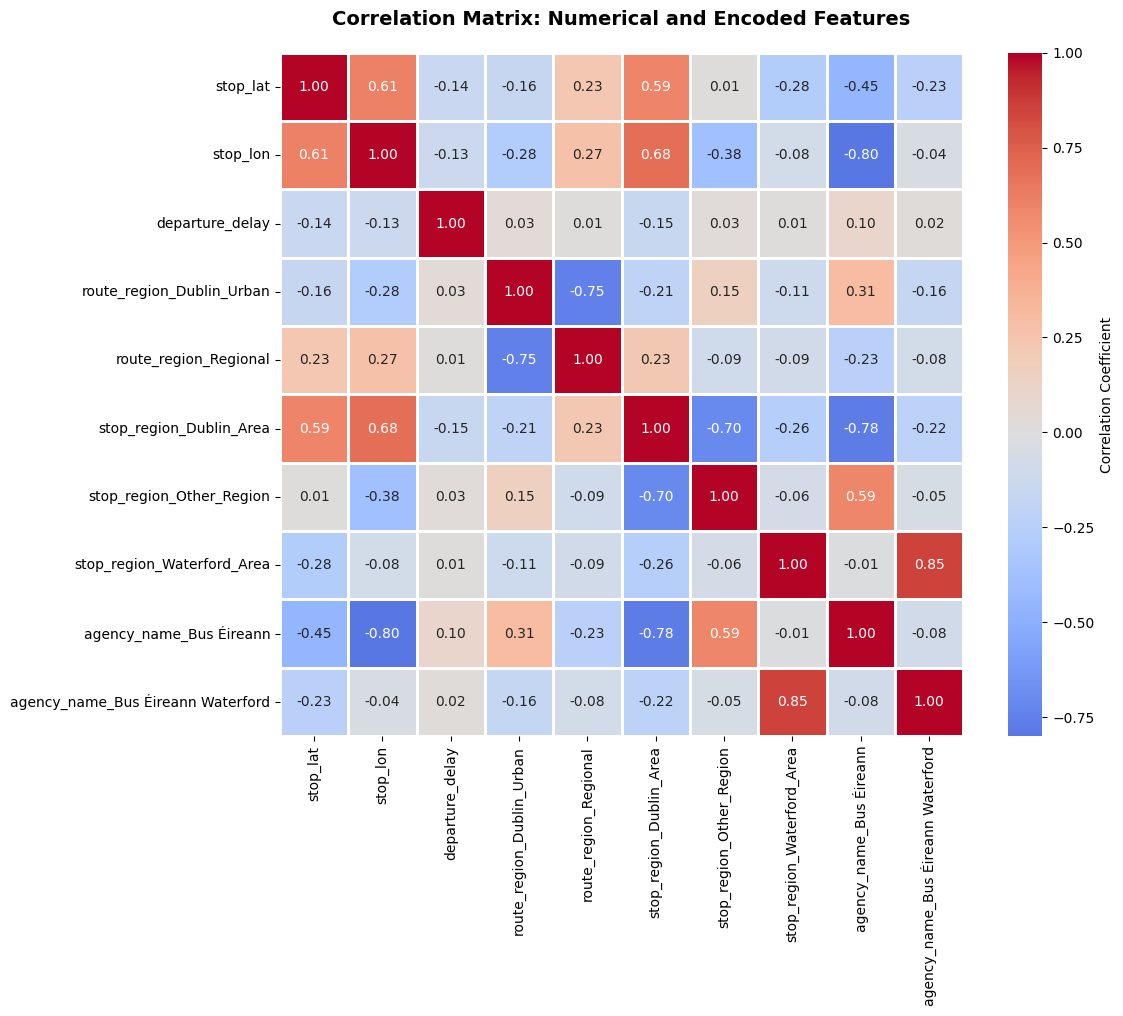

Correlation matrix heatmap displayed.

Feature Correlation with Target Variable (is_delayed) 

Top 5 features Most Positively  correlated with is_delayed:
1. departure_delay                          : +0.3733
2. agency_name_Bus Éireann                  : +0.0643
3. stop_region_Other_Region                 : +0.0344
4. route_region_Dublin_Urban                : +0.0332
5. stop_region_Waterford_Area               : +0.0030


Top 5 features Most Negatively correlated with is_delayed:
1. agency_name_Bus Éireann Waterford        : -0.0013
2. route_region_Regional                    : -0.0021
3. stop_lat                                 : -0.0391
4. stop_lon                                 : -0.0479
5. stop_region_Dublin_Area                  : -0.0703


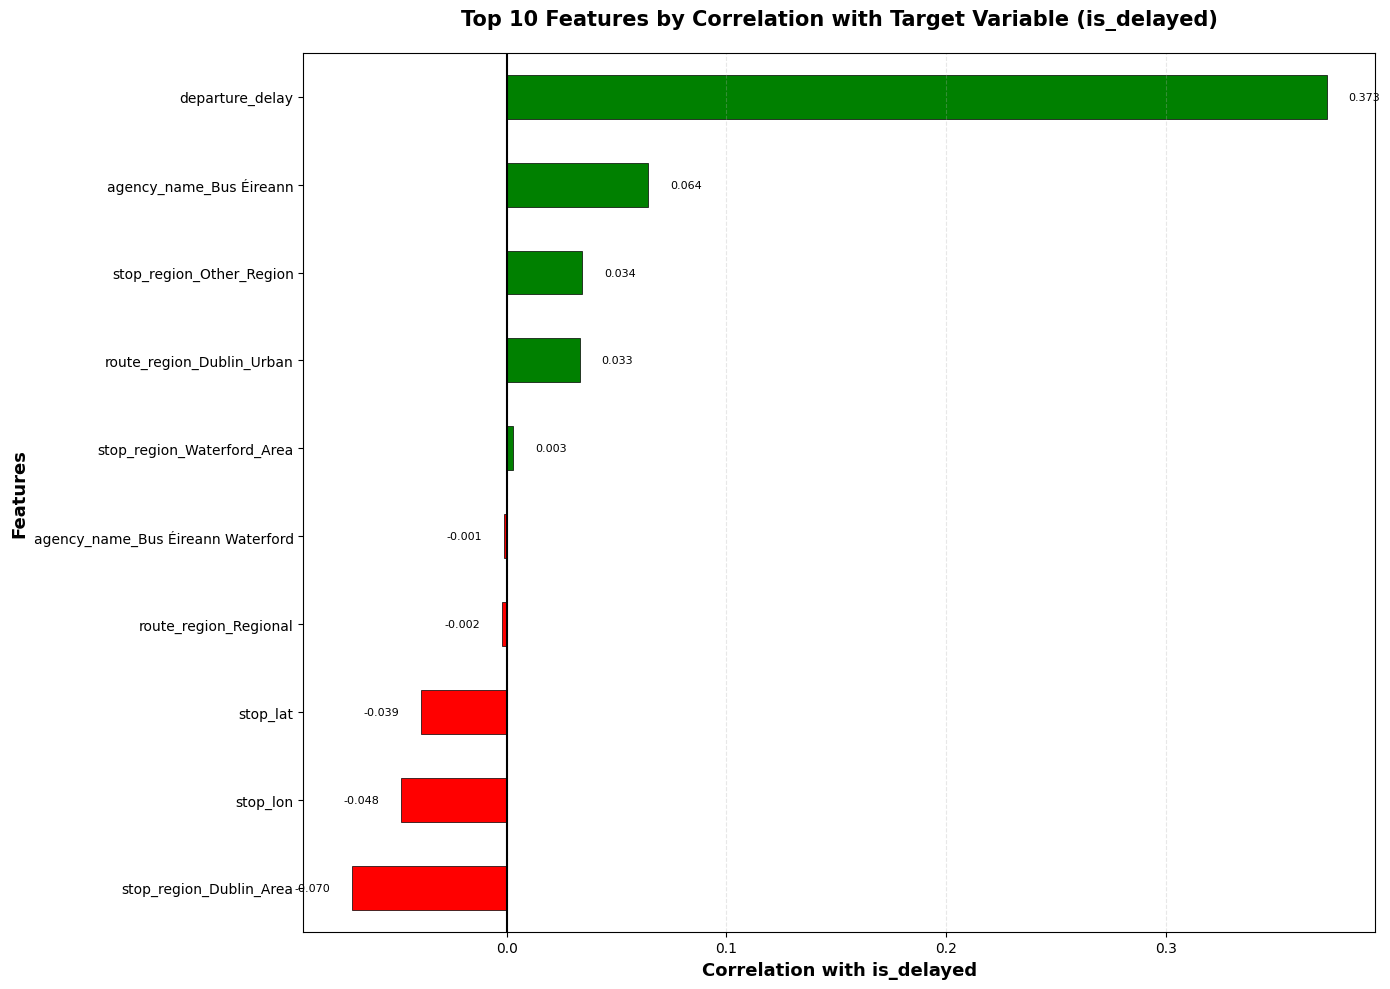


Correlation Summary Statistics
Mean absolute correlation with target: 0.0669
Median absolute correlation with target: 0.0367
Max positive correlation: 0.3733
Max negative correlation: -0.0703
Number of features with |r| > 0.3 with targeted variable: 1
Number of features with |r| > 0.5 with targeted variable: 0
Number of features with |r| > 0.7 with targeted variable: 0


In [41]:

numerical_features_final = [col for col in X.columns if col in numerical_features]
encoded_features = [col for col in X.columns if col not in numerical_features_final]

print(f"\nFeature breakdown:")
print(f"  Numerical features: {len(numerical_features_final)}")
print(f"  One-hot encoded features: {len(encoded_features)}")


correlation_matrix = X.corr()
print(f"Correlation matrix shape: {correlation_matrix.shape}")

print("\nIdentifying Highly Correlated Feature Pairs")
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if corr_value > 0.90 or corr_value < -0.90:
            high_corr_pairs.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': corr_value
            })


if high_corr_pairs:
    print(f"\nFound {len(high_corr_pairs)} highly correlated feature pairs (|r| > 0.9):")
    for idx, pair in enumerate(high_corr_pairs, 1):
        print(f"  {idx}. {pair['Feature 1']} vs {pair['Feature 2']}: {pair['Correlation']:.3f}")
    print("\nNote: High correlations may indicate multicollinearity.")
    print("Consider removing one feature from each pair if causing issues.")
else:
    print("\n No highly correlated feature pairs found (|r| > 0.9)")
    print("This suggests low to moderate multicollinearity among features.")


print("\n Visualizing Correlation Matrix")
plt.figure(figsize=(12, 10))
numeric_ordinal_features = numerical_features_final + encoded_features
if len(numeric_ordinal_features) > 0:
    corr_subset = X[numeric_ordinal_features].corr()
    sns.heatmap(corr_subset, 
                annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={'label': 'Correlation Coefficient'})
    plt.title('Correlation Matrix: Numerical and Encoded Features', 
              fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    print("Correlation matrix heatmap displayed.")
else:
    print("No numerical or ordinal features to visualize.")

plt.close()


print("\nFeature Correlation with Target Variable (is_delayed) ")
target_correlations = X.corrwith(y).sort_values(ascending=False)

print("\nTop 5 features Most Positively  correlated with is_delayed:")
for i, (feature, corr) in enumerate(target_correlations.head(5).items(), 1):
    print(f"{i}. {feature:40s} : {corr:+.4f}")

print("\n\nTop 5 features Most Negatively correlated with is_delayed:")
for i, (feature, corr) in enumerate(target_correlations.tail(5).items(), 1):
    print(f"{i}. {feature:40s} : {corr:+.4f}")



plt.figure(figsize=(14, 10))

top_features = pd.concat([
    target_correlations.head(5), 
    target_correlations.tail(5)
]).sort_values()


top_features = top_features[~ top_features.index.duplicated(keep='first')]

colors = ['red' if x < 0 else 'green' for x in top_features]

ax = top_features.plot(kind='barh', color=colors, edgecolor='black', linewidth=0.5)


plt.xlabel('Correlation with is_delayed', fontsize=13, fontweight='bold')
plt.ylabel('Features', fontsize=13, fontweight='bold')
plt.title('Top 10 Features by Correlation with Target Variable (is_delayed)', 
          fontsize=15, fontweight='bold', pad=20)
plt.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
plt.grid(axis='x', alpha=0.3, linestyle='--')

for i, (idx, val) in enumerate(top_features.items()):
    if val >= 0:
        plt.text(val + 0.01, i, f'{val:.3f}', va='center', fontsize=8)
    else:
        plt.text(val - 0.01, i, f'{val:.3f}', va='center', ha='right', fontsize=8)

plt.tight_layout()
plt.show()
plt.close()

# Summary statistics
print("\nCorrelation Summary Statistics")
print(f"Mean absolute correlation with target: {target_correlations.abs().mean():.4f}")
print(f"Median absolute correlation with target: {target_correlations.abs().median():.4f}")
print(f"Max positive correlation: {target_correlations.max():.4f}")
print(f"Max negative correlation: {target_correlations.min():.4f}")
print(f"Number of features with |r| > 0.3 with targeted variable: {(target_correlations.abs() > 0.3).sum()}")
print(f"Number of features with |r| > 0.5 with targeted variable: {(target_correlations.abs() > 0.5).sum()}")
print(f"Number of features with |r| > 0.7 with targeted variable: {(target_correlations.abs() > 0.7).sum()}")


<a name="step-6-model-development"></a>
## **Step 6: Model Development**

### **6.1 Feature Scaling** 

### **Scaling Method: StandardScaler**

All numerical features have been standardized using **StandardScaler** from scikit-learn, which transforms each feature to have:
- **Mean  = 0**
- **Standard deviation  = 1**


### **Why Feature Scaling is Necessary**


The numerical features in our dataset operate on vastly different scales:

| Feature | Original Scale | Typical Range | Unit |
|---------|---------------|---------------|------|
| `distance_from_center_km` | 0 - 200 | Kilometers | km |
| `stop_lat` | 51.5 - 55.5 | Decimal degrees | Degree |
| `stop_lon` | -10.5 - -5.5 | Decimal degrees | Degree |
| `departure_delay` | -600 - 3000+ | Seconds | sec |

**Example Before Scaling:**
- `distance_from_center_km = 134` (kilometers)
- `stop_lat = 52.26` (degrees)
- `departure_delay = 500` (seconds)

##### Without scaling, features with larger numerical ranges like `departure_delay` in seconds would **dominate** the model's learning process, while features with smaller ranges like `stop_lat` in degrees would be underweighted.


##### Many machine learning algorithms are **sensitive to feature scale** and perform poorly or incorrectly without standardization:

##### **1. Distance-Based Algorithms**

**K-Nearest Neighbors (KNN):** Calculates Euclidean distance between samples
- Without scaling: A difference of 100 in `departure_delay` would vastly outweigh a difference of 1.0 in `stop_lat`
- With scaling: All features contribute proportionally to distance calculations

**Support Vector Machines (SVM):** Uses distance metrics in kernel computations
- Unscaled features cause numerical instability
- The optimization process becomes dominated by large-scale features

##### **2. Gradient-Based Algorithms**

**Logistic Regression:** Gradient descent converges faster with scaled features   
- Scaled features enabling faster convergence

**Neural Networks:** Weight initialization and gradient calculations assume similar scales
- Large-scale features can cause exploding gradients
- Small-scale features may have vanishing gradients
- Batch normalization helps but input standardization is still recommended

##### **3. Regularization Techniques**

**L1/L2 Regularization:** Penalizes feature weights equally
- Without scaling the features on larger scales receive smaller weights, features on smaller scales receive larger weights
- This distorts the regularization effect and feature importance interpretation

--- 

##### **Standardization provides several performance benefits:**

1. **Faster Convergence** as gradient descent algorithms reach optimal solutions more quickly
2.  Prevents overflow/underflow errors in computations
3.  All features contribute proportionally based on their predictive power, not their original scale

---

### **Algorithms That Benefit from Scaling**

The following models in our analysis **require or strongly benefit** from feature scaling:

**Logistic Regression**
- Gradient descent optimization
- Regularization (L1/L2)

**K-Nearest Neighbors (KNN)**
- Distance-based predictions

**Support Vector Machines (SVM)**


**Neural Networks (Simple NN & Transformer)**
- Gradient-based learning
- Weight initialization
- Activation functions

---

### **Algorithms not Affected by Scaling**

The following models in our analysis are **not affected by feature scaling**:

**Decision Tree**
- Uses threshold splits, not distances
- Feature Scalling does not affect split decisions

**Random Forest**
- Ensemble of decision trees

**Naive Bayes**
- Probabilistic model based on feature distributions
- Feature scaling does not change probability relationships

--- 

### **Impact on Model Interpretability**

**Trade-off:**
- **Loss**: Original units are no longer directly interpretable
  - For example, a coefficient of 0.5 does not mean "0.5 kilometers" or "0.5 seconds"
- **Gain**: Coefficients now represent **standardized effect sizes**   

**For Explainability (LIME):**
- LIME explanations work on scaled features
- Feature contributions are reported in standardized units
- Business stakeholders will interpret relative importance not absolute magnitudes



### **Conclusion**

Feature scaling using StandardScaler is a **critical preprocessing step** that:
- Ensures fair feature contribution across different scales
- Improves model convergence and stability    
- Is essential for distance-based and gradient-based algorithms

All numerical features are now standardized with **mean = 0** and **standard deviation = 1**, ready for machine learning model training.

In [42]:
print("\nFeature Scaling")  
print("Scaling numerical features using StandardScaler")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("All features standardized (mean=0, std=1)")


Feature Scaling
Scaling numerical features using StandardScaler
All features standardized (mean=0, std=1)


### **6.2 Train-Test Split**

The dataset is split into training and testing sets to evaluate model performance on unseen data. This separation is critical for assessing how well models generalize to new observations rather than simply memorizing the training data.

#### **Split Strategy**

A **80-20 split** is used, allocating 80% of data for training and 20% for testing. This ratio provides sufficient training data for model learning while reserving adequate test data for evaluation.

**Stratified sampling** is applied to maintain the class distribution across both sets. This is particularly important given the class imbalance in the dataset with approximately 69% delayed vs 31% on-time services. Stratification ensures that both training and test sets have representative proportions of each class, preventing biased model evaluation.

#### **Random State for Reproducibility**

The `random_state=42` parameter ensures reproducibility by running the split multiple times with the same random state produces identical train-test divisions. This is essential for:
- Comparing different models fairly on the same data splits    


#### **Split Results**

The data split yields:
- **Training set**: 12,879 samples (80.0%)
- **Test set**: 3,220 samples (20.0%)

#### **Class Distribution Analysis**

Both sets maintain consistent class distribution through stratification:

**Training Set:**
- On-time services: 3,971 samples (30.8%)
- Delayed services: 8,908 samples (69.2%)

**Test Set:**
- On-time services: 993 samples (30.8%)
- Delayed services: 2,227 samples (69.2%)

The identical proportions 30.8% on-time, 69.2% delayed across both sets confirm successful stratification. This **class imbalance** (approximately 2.2:1 ratio favoring delays) reflects the reality of transport operations and will influence our choice of evaluation metrics. Accuracy alone would be misleading with such imbalance. Therefore, we need to look at other evaluation metrics such as (percision, recall, F1-Score, ROC-AUC).   

#### **Rationale for 80-20 Split**

The 80-20 ratio is chosen because:
1.  With 12879 training samples, models have adequate data to learn complex patterns
2.  3220 test samples provide statistically significant evaluation
3. **Industry standard**. This split ratio is widely accepted in machine learning practice    

The test set will not be used during model training and will be used only for final performance evaluation ensuring unbiased model generalization.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)


print(f"Data split completed:")
print(f"- Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"- Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"\nTraining set class distribution:")
print(f"On-time: {(y_train == 0).sum():,} ({(y_train == 0).sum()/len(y_train)*100:.1f}%)")
print(f"Delayed: {(y_train == 1).sum():,} ({(y_train == 1).sum()/len(y_train)*100:.1f}%)")
print(f"\nTest set class distribution:")
print(f"On-time: {(y_test == 0).sum():,} ({(y_test == 0).sum()/len(y_test)*100:.1f}%)")
print(f"Delayed: {(y_test == 1).sum():,} ({(y_test == 1).sum()/len(y_test)*100:.1f}%)")



Data split completed:
- Training set: 12,879 samples (80.0%)
- Test set: 3,220 samples (20.0%)

Training set class distribution:
On-time: 3,971 (30.8%)
Delayed: 8,908 (69.2%)

Test set class distribution:
On-time: 993 (30.8%)
Delayed: 2,227 (69.2%)


### **6.3 Traditional Machine Learning Models**

This section implements and trains six traditional machine learning algorithms to predict transport service delays. Multiple models are trained to compare their performance characteristics and identify the most effective approach for this classification problem. Detailed model evaluation will be carried out in the next step **Step 7: Model Evaluation**, where comprehensive metrics, confusion matrices and performance comparisons will be analyzed.

#### **Model Selection Rationale**

Six diverse algorithms were selected: 

1. **Logistic Regression**:  Linear model establishing baseline performance
2. **Decision Tree**: Non-linear and rule-based model with high interpretability
3. **Random Forest**:  Ensemble method reducing overfitting through multiple trees
4. **K-Nearest Neighbors (KNN)**:  Instance-based learning using proximity
5. **Support Vector Machine (SVM)**: Maximum margin classifier for complex boundaries
6. **Naive Bayes**: Probabilistic classifier assuming feature independence

#### **Handling Class Imbalance**

Given the 69.2% delayed vs 30.8% on-time class distribution, most models are configured with **balanced class weights**. This adjustment penalizes misclassifications of the minority class which is the on-time services more heavily, preventing models from simply predicting the majority class. There are exceptions which are KNN which uses distance-weighting and Naive Bayes which handles probabilities inherently.    

#### **Model Configurations**

**Logistic Regression:**
- Class weights: Balanced, which is inversely proportional to class frequencies  
- Purpose: Establishes linear baseline performance

**Decision Tree:**
- Maximum depth: 10 to prevents overfitting while capturing complexity
- Class weights: Balanced
- Criterion: Gini impurity
- Purpose: Provides interpretable decision rules

**Random Forest:**
- Number of trees: 100 to ensemble diversity 
- Class weights: Balanced
- Purpose: Reduces variance through training each decision tree on a random subset of the examples in the training set to improves generalization

**K-Nearest Neighbors:**
- Number of neighbors: k=5
- Purpose: Non-parametric approach capturing local patterns

**Support Vector Machine:**
- Kernel: RBF (Radial Basis Function) for non-linear decision boundaries
- Class weights: Balanced
- Purpose: Finds optimal separating hyperplane in high-dimensional space

**Naive Bayes:**
- Distribution: Gaussian by assumes normal distribution of features
- Purpose: Fast probabilistic baseline as I assumes feature independence

#### **Summary of Training Results**

| Model | Training Accuracy | Test Accuracy | Overfitting Gap |
|-------|------------------|---------------|-----------------|
| **Logistic Regression** | 74.06% | 74.07% | -0.01% |
| **Decision Tree** | 91.37% | 90.09% | +1.28% |
| **Random Forest** | 93.44% | 92.27% | +1.17% |
| **KNN** | 99.37% | 93.23% | +6.14% |
| **SVM** | 79.87% | 80.09% | -0.22% |
| **Naive Bayes** | 64.13% | 62.48% | +1.65% |

#### **Initial Observations**

**Top Performers based on Test Accuracy:**
1. **KNN** (93.23%) has the highest test accuracy but shows signs of overfitting with 99.37% training accuracy
2. **Random Forest** (92.27%) has a strong performance with minimal overfitting 1.17% gap
3. **Decision Tree** (90.09%) is a good performance but have a slight overfitting tendency 

**Moderate Performers:**
- **SVM** (80.09%) is a stable performance with no overfitting the negative gap indicates slight generalization improvement
- **Logistic Regression** (74.07%) is a consistent linear baseline with no overfitting

**Underperformer:**
- **Naive Bayes** (62.48%) has the lowest accuracy, likely due to feature independence assumption violation

#### **Overfitting Analysis**

The **overfitting gap** (training accuracy - test accuracy) provides insights into model generalization:

- **KNN** shows the largest gap (6.14%), indicating memorization of training data due to high model flexibility and class imbalance with 99.37% training accuracy is suspiciously high.   
- **Random Forest** and **Decision Tree** show moderate gaps with 1.17% and 1.28%, suggesting good generalization.   
- **Logistic Regression** and **SVM** show near-zero or negative gaps, indicating they may be slightly underfitting but generalizing well
- **Naive Bayes** has a small gap with 1.65% but overall poor performance

#### **Key Insights**

1.  Random Forest achieves the best balance between accuracy and generalization
2.  Tree-based and KNN models significantly outperform linear approaches such as Logistic Regression, Naive Bayes
3. The poor performance of Naive Bayes suggests violation on independence assumptions
4. All models achieve >60% accuracy despite the 69.2% class imbalance, indicating they're learning patterns beyond the majority class.   

#### **Next Steps**

These initial accuracy results provide a preliminary ranking, but comprehensive evaluation requires additional metrics:
- **Precision and Recall**: To assess performance on each class separately
- **F1-Score**: Balanced metric accounting for class imbalance
- **ROC-AUC**:  Threshold-independent performance measure
- **Confusion Matrices** - Detailed breakdown of prediction errors

##### These detailed evaluations will be conducted in **Step 7: Model Evaluation** to identify the best model for production deployment.

In [ ]:
models = {}
model_results = {}

print("\nInitializing traditional ML models:\n")


models['Logistic Regression'] = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced'  # To Handle class imbalance
)
print("1. Logistic Regression (with balanced class weights)")


models['Decision Tree'] = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    class_weight='balanced'
)
print("2. Decision Tree (max_depth=10, balanced weights)")


models['Random Forest'] = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
print("3. Random Forest (100 trees, balanced weights)")


models['KNN'] = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',  
    n_jobs=-1
)
print("4. K-Nearest Neighbors (k=5, distance-weighted)")


models['SVM'] = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42,
    class_weight='balanced',
    probability=True  # Enable probability estimates for ROC
)
print("5. Support Vector Machine (RBF kernel, balanced weights)")


models['Naive Bayes'] = GaussianNB()
print("6. Naive Bayes (Gaussian)")

print("\nTraining traditional ML models")

#train all models and store results
for name, model in models.items():
    print(f"\nTraining {name}")
    
    #train model
    model.fit(X_train, y_train)
    

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    

    if hasattr(model, 'predict_proba'):
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba_train = None
        y_pred_proba_test = None
    

    model_results[name] = {
        'model': model,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'y_pred_proba_train': y_pred_proba_train,
        'y_pred_proba_test': y_pred_proba_test
    }
    

    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    
    print(f"Training accuracy: {accuracy_train:.4f}")
    print(f"Test accuracy: {accuracy_test:.4f}")




Initializing traditional ML models:

1. Logistic Regression (with balanced class weights)
2. Decision Tree (max_depth=10, balanced weights)
3. Random Forest (100 trees, balanced weights)
4. K-Nearest Neighbors (k=5, distance-weighted)
5. Support Vector Machine (RBF kernel, balanced weights)
6. Naive Bayes (Gaussian)

Training traditional ML models

Training Logistic Regression
Training accuracy: 0.7406
Test accuracy: 0.7407

Training Decision Tree
Training accuracy: 0.9137
Test accuracy: 0.9009

Training Random Forest
Training accuracy: 0.9344
Test accuracy: 0.9227

Training KNN
Training accuracy: 0.9937
Test accuracy: 0.9323

Training SVM
Training accuracy: 0.7987
Test accuracy: 0.8009

Training Naive Bayes
Training accuracy: 0.6413
Test accuracy: 0.6248

All traditional ML models trained successfully


### **6.4 Deep Learning Models**

**Note**: Running the code below needs around **6-7 minutes** depending on your hardware specifications and computational resources.   

In addition to traditional machine learning algorithms, **these six deep learning model** are implemented to leverage neural networks capability to learn complex non-linear patterns and feature interactions automatically. These models represent modern approaches to classification problems and provide comprehensive comparison against classical machine learning methods.

**Important Note on Accuracy Variability**
There might be a small changes in accuracy each time the deep learning model is run. This happens because of randomness in the training process:

1. Data Shuffling: The training data is shuffled randomly before each round of training which can affect how the model learns.

2. Batch Processing: The model trains using small batches of data and which data is selected in each batch can change randomly. Mini-batch gradient descent or variants like Adam the model processes data in small batches. The selection of batches can vary randomly leading to slight differences in the accuracy across different runs.

3. Dropout: Dropout randomly disables some neurons during training to help the model generalize better which adds some randomness to how the model trains.

**These small variations in accuracy are normal and don't affect the overall performance of the model.**



#### **Model Selection Rationale**

Six distinct deep learning models were chosen to explore different neural network:

1. **Simple Neural Network (Feedforward)**: Standard multilayer perceptron establishing deep learning baseline
2. **LSTM (Long Short-Term Memory)**: Recurrent model designed to capture temporal dependencies
3. **Bidirectional LSTM:** This type of LSTM looks at a sequence of data in two ways  from the beginning to the end and from the end to the beginning. This helps it understand the context better.
4. **GRU (Gated Recurrent Unit):** This is a simpler and faster version of LSTM. It has a more straightforward way of deciding what information to keep and what to forget making it more efficient.
5. **Simple RNN**: Basic recurrent model for sequence learning
6 **Transformer Model:** This model uses something called "attention" to focus on the most important parts of the data. It's commonly used for tasks like language processing but has also been adapted to work well with tabular classification

All models incorporate modern techniques like batch normalization, dropout regularization and early stopping to prevent overfitting and improve generalization.

---

### **Model 1: Simple Neural Network (Feedforward)**    

The Simple Neural Network is a traditional feedforward model with progressively decreasing layer sizes creating a funnel structure that compresses information toward the binary classification output.

**Layer Structure:**
```
Input (10 features) to 128 to 64 to 32 to 1 (output)
```

| Layer | Type | Output Shape | Parameters | Purpose |
|-------|------|--------------|------------|---------|
| **Dense 1** | Fully Connected | 128 units | 1408 | First hidden layer with ReLU activation |
| **BatchNorm 1** | Normalization | 128 units | 512 | Stabilizes learning, reduces internal covariate shift |
| **Dropout 1** | Regularization | 128 units | 0 | Prevents overfitting (30% dropout rate) |
| **Dense 2** | Fully Connected | 64 units | 8256 | Second hidden layer |
| **BatchNorm 2** | Normalization | 64 units | 256 | Maintains stable gradients |
| **Dropout 2** | Regularization | 64 units | 0 | Additional regularization (30% dropout) |
| **Dense 3** | Fully Connected | 32 units | 2080 | Third hidden layer |
| **Dropout 3** | Regularization | 32 units | 0 | Final regularization layer (20% dropout) |
| **Output** | Dense (Sigmoid) | 1 unit | 33 | Binary classification output |

**Total Parameters:**
- **Trainable**: 12161 parameters (47.50 KB)
- **Non-trainable**: 384 parameters (1.50 KB) from batch normalization layers
- **Total**: 12545 parameters (49.00 KB)

The relatively small model size (49 KB) ensures fast training and inference while maintaining sufficient capacity to learn complex patterns.

#### **Explanation of model Components**

**Batch Normalization:**
Normalizes layer inputs to have zero mean and unit variance which:
- Accelerates training by allowing higher learning rates
- Reduces sensitivity to weight initialization
- Acts as mild regularization
- Stabilizes gradient flow through deep networks

**Dropout Regularization:**
Randomly deactivates neurons during training 30% for earlier layers, 20% for later layers which:
- Prevents co-adaptation of neurons (overfitting)   
- Forces the network to learn robust features

**Progressive Layer Reduction:**
The 128 to 64 to 32 structure:
- Compresses feature representation hierarchically
- Learns increasingly abstract representations
- Common pattern in classification networks

#### **Training Configuration**

- **Optimizer**: Adam (adaptive learning rate)
- **Loss Function**: Binary crossentropy
- **Batch Size**: 32 samples
- **Maximum Epochs**: 100
- **Early Stopping**: Monitors validation loss with 15 epochs patience
- **Learning Rate Reduction**: Reduces LR by 50% if validation loss plateaus (patience=5)

#### **Performance Results**

**Test Accuracy: 90.37%**

This represents strong performance, placing the Simple Neural Network among the top-performing models:
- Outperforms all linear models (Logistic Regression: 74.07%, SVM: 80.09%)
- Outperforms recurrent models (LSTM: 66.37%, BiLSTM: 69.19%, GRU: 69.16%)
- Competitive with ensemble methods (Random Forest: 92.27%, KNN: 93.23%)
- Demonstrates neural networks' ability to learn complex non-linear decision boundaries

---

### **Model 2: LSTM (Long Short-Term Memory)**


LSTM is a recurrent neural network model designed to capture sequential patterns and long-term dependencies. For this tabular dataset features are treated as a sequence to explore potential temporal relationships.


```
Original: (samples, 10 features)
Reshaped: (samples, 10 timesteps, 1 feature)
```

| Layer | Type | Output Shape | Parameters | Purpose |
|-------|------|--------------|------------|---------|
| **LSTM 1** | Recurrent | (None, 10, 64) | 16896 | First LSTM layer with return sequences |
| **Dropout 1** | Regularization | (None, 10, 64) | 0 | Prevents overfitting (30% dropout) |
| **LSTM 2** | Recurrent | (None, 32) | 12416 | Second LSTM layer (final state only) |
| **Dropout 2** | Regularization | (None, 32) | 0 | Additional regularization (20% dropout) |
| **Dense 1** | Fully Connected | 32 units | 1056 | First dense layer |
| **BatchNorm** | Normalization | 32 units | 128 | Stabilizes learning |
| **Dropout 3** | Regularization | 32 units | 0 | Final regularization (20% dropout) |
| **Dense 2** | Fully Connected | 16 units | 528 | Second dense layer |
| **Output** | Dense (Sigmoid) | 1 unit | 17 | Binary classification output |

**Total Parameters:**
- **Trainable**: 30977 parameters (121.00 KB)
- **Non-trainable**: 64 parameters (256.00 B)
- **Total**: 31041 parameters (121.25 KB)

#### **LSTM Components**

**Cell State (Memory):**
- Maintains long-term information across sequences
- Controlled by three gates: forget, input and output

**Gating Mechanisms:**
- **Forget Gate**: Decides what information to discard
- **Input Gate**: Determines what new information to store
- **Output Gate**: Controls what information to output

**Return Sequences:**
- First LSTM layer returns full sequence (10 timesteps)
- Second LSTM layer returns only final state for classification

#### **Performance Results**

**Test Accuracy: 66.37%**

The LSTM model significantly underperforms compared to other models:
- **Lowest performance** among all deep learning models
- Underperforms traditional ML methods (Random Forest: 92.27%, Decision Tree: 90.09%)
- Even underperforms simple Logistic Regression (74.07%)

**Reasons for Poor Performance:**
1. **Not Sequential Data**: Transport delay features lack inherent sequential structure
2. **Artificial Sequencing**: Treating independent features as timesteps is inappropriate
3. **Over-parameterization**: 31K parameters for non-sequential tabular data leads to poor generalization
4. **Data Mismatch**: LSTM excels with time-series but this dataset is cross-sectional

---

### **Model 3: Bidirectional LSTM**   

Bidirectional LSTM processes sequences in both forward and backward directions, capturing patterns that may be missed by unidirectional processing.

**Detailed model:**

| Layer | Type | Output Shape | Parameters | Purpose |
|-------|------|--------------|------------|---------|
| **BiLSTM 1** | Bidirectional | (None, 10, 128) | 33792 | Processes sequences both ways |
| **Dropout 1** | Regularization | (None, 10, 128) | 0 | Prevents overfitting (30% dropout) |
| **BiLSTM 2** | Bidirectional | (None, 64) | 41216 | Second bidirectional layer |
| **Dropout 2** | Regularization | (None, 64) | 0 | Additional regularization (20% dropout) |
| **Dense 1** | Fully Connected | 32 units | 2080 | Dense layer |
| **BatchNorm** | Normalization | 32 units | 128 | Stabilizes learning |
| **Dropout 3** | Regularization | 32 units | 0 | Final regularization (20% dropout) |
| **Dense 2** | Fully Connected | 16 units | 528 | Second dense layer |
| **Output** | Dense (Sigmoid) | 1 unit | 17 | Binary classification output |

**Total Parameters:**
- **Trainable**: 77697 parameters (303.50 KB)
- **Non-trainable**: 64 parameters (256.00 B)
- **Total**: 77761 parameters (303.75 KB)

This is the **largest model** with approximately **2.5× more parameters** than standard LSTM.

#### **Bidirectional Processing**

**Forward Direction**: Processes features 1 to 10
**Backward Direction**: Processes features 10 to 1
**Combined Output**: Concatenates both directions (64 × 2 = 128 units)

#### **Performance Results**   
**Test Accuracy: 69.19%**

Slight improvement over standard LSTM but still poor:
- **Second lowest** among deep learning models
- Only marginally better than LSTM with +2.82%  
- Significantly underperforms feedforward networks
- The bidirectional processing provides minimal benefit for non-sequential tabular data   

**Key Insight:** Just increasing the number of parameters like going from 31K to 77K doesn’t make up for the fact that the model’s design may not be the best fit for this type of data. If the model structure doesn’t match the data, more parameters won’t help much.


---

### **Model 4: GRU (Gated Recurrent Unit)**   

GRU is a simplified variant of LSTM with fewer parameters and faster training, using only two gates instead of three.


| Layer | Type | Output Shape | Parameters | Purpose |
|-------|------|--------------|------------|---------|
| **GRU 1** | Recurrent | (None, 10, 64) | 12864 | First GRU layer |
| **Dropout 1** | Regularization | (None, 10, 64) | 0 | Prevents overfitting (30% dropout) |
| **GRU 2** | Recurrent | (None, 32) | 9,408 | Second GRU layer |
| **Dropout 2** | Regularization | (None, 32) | 0 | Additional regularization (20% dropout) |
| **Dense 1** | Fully Connected | 32 units | 1056 | Dense layer |
| **BatchNorm** | Normalization | 32 units | 128 | Stabilizes learning |
| **Dropout 3** | Regularization | 32 units | 0 | Final regularization (20% dropout) |
| **Dense 2** | Fully Connected | 16 units | 528 | Second dense layer |
| **Output** | Dense (Sigmoid) | 1 unit | 17 | Binary classification output |

**Total Parameters:**
- **Trainable**: 23937 parameters (93.50 KB)
- **Non-trainable**: 64 parameters (256.00 B)
- **Total**: 24001 parameters (93.75 KB)

**Efficiency Comparison**: GRU has **23% fewer parameters** than LSTM (24K vs 31K) while achieving similar results.

#### **GRU vs LSTM Mechanisms**

**GRU Simplifications:**    
- **Two gates** instead of three which is Update gate, Reset gate   
- **No separate cell state** hidden state serves dual purpose   
- **Faster training** and inference   
- **Comparable performance** to LSTM in many tasks

#### **Performance Results**    
**Test Accuracy: 69.16%**

Nearly identical performance to Bidirectional LSTM:
- Essentially tied with BiLSTM with 69.16% vs 69.19%
- More parameter-efficient than BiLSTM with 24K vs 78K parameters   
- Still suffers from sequential model on non-sequential data
- **Better efficiency** but same poor performance

---

### **Model 5: Simple RNN**    

Simple RNN is the most basic recurrent model without sophisticated gating mechanisms, serving as a baseline for recurrent models.

**Detailed model:**

| Layer | Type | Output Shape | Parameters | Purpose |
|-------|------|--------------|------------|---------|
| **RNN 1** | Recurrent | (None, 10, 64) | 4224 | First simple RNN layer |
| **Dropout 1** | Regularization | (None, 10, 64) | 0 | Prevents overfitting (30% dropout) |
| **RNN 2** | Recurrent | (None, 32) | 3104 | Second simple RNN layer |
| **Dropout 2** | Regularization | (None, 32) | 0 | Additional regularization (20% dropout) |
| **Dense 1** | Fully Connected | 32 units | 1056 | Dense layer |
| **BatchNorm** | Normalization | 32 units | 128 | Stabilizes learning |
| **Dropout 3** | Regularization | 32 units | 0 | Final regularization (20% dropout) |
| **Dense 2** | Fully Connected | 16 units | 528 | Second dense layer |
| **Output** | Dense (Sigmoid) | 1 unit | 17 | Binary classification output |

**Total Parameters:**
- **Trainable**: 8993 parameters (35.13 KB)
- **Non-trainable**: 64 parameters (256.00 B)
- **Total**: 9057 parameters (35.38 KB)

This is the **smallest recurrent model** with only **29% of LSTM's parameters** with 9K vs 31K.

#### **Simple RNN Characteristics**

**Advantages:**
- Lightweight model with 35 KB total   
- Fast training
- Minimal computational requirements

**Limitations:**
- Susceptible to vanishing or exploding gradients
- Cannot capture long-term dependencies
- No gating mechanisms for selective memory

#### **Performance Results**    
**Test Accuracy: 79.53%**

**Best performing recurrent model** but still underperforms feedforward:
- **10-13% better** than LSTM/BiLSTM/GRU
- Outperforms SVM with 80.09% vs 79.53%
- Still **11% below** Simple NN (90.37%)
- Competitive with Transformer (86.18%)

**Key Insight**: Simplicity helps by removing unnecessary gating mechanisms for non-sequential data improves performance and reduces complexity.

---

### **Model 6: Transformer Model (Self-Attention Mechanism)**
  
The Transformer model, originally designed for natural language processing, has been adapted for tabular data classification using self-attention mechanisms to weigh feature importance dynamically.   

**Detailed model:**   
| Layer | Type | Output Shape | Parameters | Purpose |
|-------|------|--------------|------------|---------|
| **Input** | Input Layer | 10 features | 0 | Feature input |
| **Dense** | Fully Connected | 32 units | 352 | Embedding layer |
| **BatchNorm 1** | Normalization | 32 units | 128 | Stabilizes learning |
| **Transformer Block 1** | Self-Attention | 32 units | 21120 | First attention block |
| **Transformer Block 2** | Self-Attention | 32 units | 21120 | Second attention block |
| **Dense 1** | Fully Connected | 64 units | 2112 | Dense layer |
| **BatchNorm 2** | Normalization | 64 units | 256 | Maintains stable gradients |
| **Dropout 1** | Regularization | 64 units | 0 | Prevents overfitting (30% dropout) |
| **Dense 2** | Fully Connected | 32 units | 2080 | Second dense layer |
| **Dropout 2** | Regularization | 32 units | 0 | Additional regularization (20% dropout) |
| **Output** | Dense (Sigmoid) | 1 unit | 33 | Binary classification output |

**Total Parameters:**
- **Trainable**: 47009 parameters (183.63 KB)  
- **Non-trainable**: 192 parameters (768.00 KB) 
- **Total**: 47201 parameters (184.38 KB)  

#### **Transformer Components**

**Multi-Head Attention:**
- **4 attention heads** capture different feature relationships
- Each head learns different aspects of feature interactions
- Parallel processing of all features

**Self-Attention Mechanism:**
- It calculates attention weights between all pairs of features, determining how much focus each feature should receive in relation to others.
- This process helps identify the features that are most relevant for making accurate predictions.
- The importance of each feature is dynamic and varies for each individual sample, allowing the model to adaptively prioritize different features based on the input data.

**Feed-Forward Networks:**
- It serve to transform the representations obtained from the attention mechanism, refining the information for subsequent processing.
- Layer normalization is applied to stabilize the training process by normalizing activations across layers which improves convergence and model performance.   
- Residual connections facilitate the preservation of information across layers, allowing gradients to flow more easily during backpropagation and preventing the loss of important features.

#### **Performance Results**
**Test Accuracy: 86.18%**

Moderate performance among deep learning models:
- **Second-best** attention-based model behind Simple NN
- Outperforms all recurrent models except Simple RNN
- **6% below** Simple NN (90.37%)
- **6% below** Random Forest (92.27%)

**Key Observations:**
- Attention mechanisms provide limited benefit for tabular data   
- Better suited for sequential/text data with inherent relationships   

---

### **Comparative Analysis: Deep Learning Models**

#### **Performance Ranking (Test Accuracy)**

| Rank | Model | Test Accuracy | Parameters | model Type |
|------|-------|---------------|------------|-------------------|
| 1 | **Simple Neural Network** | 90.37% | 12545 (49 KB) | Feedforward |
| 2 | **Transformer** | 86.18% | 47201 (184 KB) | Attention-based |
| 3 | **Simple RNN** | 79.53% | 9057 (35 KB) | Recurrent |
| 4 | **Bidirectional LSTM** | 69.19% | 77761 (304 KB) | Recurrent |
| 5 | **GRU** | 69.16% | 24001 (94 KB) | Recurrent |
| 6 | **LSTM** | 66.37% | 31041 (121 KB) | Recurrent |

#### **Overall Model Ranking including Traditional ML**

| Rank | Model | Accuracy | Type |
|------|-------|----------|------|
| 1 | KNN | 93.23% | Traditional ML |
| 2 | Random Forest | 92.27% | Traditional ML |
| 3 | **Simple NN** | **90.37%** | **Deep Learning** |
| 4 | Decision Tree | 90.09% | Traditional ML |
| 5 | **Transformer** | **86.18%** | **Deep Learning** |
| 6 | SVM | 80.09% | Traditional ML |
| 7 | **Simple RNN** | **79.53%** | **Deep Learning** |
| 8 | Logistic Regression | 74.07% | Traditional ML |
| 9 | **BiLSTM** | **69.19%** | **Deep Learning** |
| 10 | **GRU** | **69.16%** | **Deep Learning** |
| 11 | **LSTM** | **66.37%** | **Deep Learning** |
| 12 | Naive Bayes | 62.48% | Traditional ML |

#### **Key Insights**
- Simple NN achieves **90.37%** far exceeding all recurrent model. **20-24% better** than LSTM variants. Competitive with best traditional ML methods
- All recurrent models such as LSTM, BiLSTM, GRU perform poorly with **66-69%**. Adding complexity such as bidirectional processing doesn't help. 
- **Best recurrent model** despite being the simplest. It is **10% better** than sophisticated LSTM variants. The lesson is complexity without appropriate data structure reduce the model performance.  


**Parameter Efficiency Analysis:**
Model              | Parameters | Accuracy | Efficiency Score
-------------------|------------|----------|------------------
Simple NN          | 12545     | 90.37%   | 7.20 acc/KB
Transformer        | 47201     | 86.18%   | 1.83 acc/KB
Simple RNN         | 9057      | 79.53%   | 8.78 acc/KB
BiLSTM             | 77761     | 69.19%   | 0.91 acc/KB
GRU                | 24001     | 69.16%   | 2.88 acc/KB
LSTM               | 31041     | 66.37%   | 2.14 acc/KB

*Note: 1 KB = 1000 parameters*

**Simple NN** offers the best balance: high accuracy with reasonable parameters.

**Traditional ML Still Wins:**
- **Top 2** positions held by traditional methods (KNN, Random Forest)
- Tree-based models excel at capturing feature interactions in tabular data
- No deep learning model surpasses Random Forest

#### **Why Deep Learning Underperforms**

**1. Dataset Characteristics:**
- Only approximate 16,000 samples are insufficient for complex deep learning
- Tabular data with independent features but not sequential
- Well feature engineered variable reduce need for automatic feature learning

**2. Architectural Mismatch:**
- **Recurrent models** designed for sequences such as text and time-series
- Features have **no inherent order** will be treating them as sequences is artificial
- **Attention mechanisms** excel with long-range dependencies which are absent for this datasets 

**3. Overfitting Risk:**
- Large models such as BiLSTM has 78K params on small datasets
- Despite regularization it still cannot overcome fundamental mismatch

**4. Traditional ML Advantages for This Task:**
- Tree-based rules naturally capture the feature interactions
- No assumption on ordering   
- Fast training and excellent interpretability

---

### **Training Efficiency Analysis**

#### **Computational Cost**

| Model | Training Time | Epochs Completed | Time per Epoch |
|-------|---------------|------------------|----------------|
| Simple NN | approximate 2-3 min | 65+ | approximate 2-3 sec |
| LSTM | approximate 1-2 min | 30-40 | approximate 3-4 sec |
| BiLSTM | approximate 2-3 min | 20-30 | approximate 5-6 sec |
| GRU | approximate 1-2 min | 30-40 | approximate 3-4 sec |
| Simple RNN | approximate 1 min | 40-50 | approximate 1-2 sec |
| Transformer | approximate 1-2 min | 14 | approximate 6-8 sec |

**Total Deep Learning Training Time**: Approximately **6-7 minutes**

**Comparison to Traditional ML**:
- Random Forest trains in **<10 seconds**
- Deep learning is **40-60× slower** without benefit in terms of accuracy.  

#### **Resource Requirements**   
- **CPU-based training**: All models (current setup)
- **GPU acceleration**: Would reduce training to <1 minute total
- **Memory footprint**: Minimal (largest model: 304 KB)
- **Inference speed**: All models provide real-time predictions

---

### **Deep Learning Model Selection Guidelines**

#### **When to Use Simple Neural Network:**
- Dataset size increases to 50,000+ samples
- Feature interactions are highly non-linear
- Automatic feature learning desired
- Model can be regularly retrained with new data
- **Best deep learning choice for this dataset**

#### **When to Use Recurrent Models (LSTM/GRU/RNN):**
- **sequential/temporal data** such as minute-by-minute delay progression
- Time-series forecasting requirements
- Long-term dependency learning needed
- **Not suitable for cross-sectional tabular data**

#### **When to Use Transformer:**
- Complex feature relationships need discovery
- Large datasets approximate 100,000+ samples available
- Sequential patterns exist in data
- **Limited benefit for small tabular datasets**

#### **When Traditional ML is Better:**
-  Small to medium datasets (<50,000 samples) which is suitable for **this case**
- Interpretability critical for **Transport operations**
- Fast training required for **Operational deployment**
- Tabular data with engineered features using the static **GTFS data**

---

### **Conclusions from Deep Learning Analysis**    
#### **Key Findings:**

1. **Feedforward is the best among the Deep Learning model**
   - Simple NN has accurancy 90.37% significantly outperforms all recurrent and attention-based models
   - Proves feedforward is optimal for non-sequential tabular data

2. **Recurrent Models Fails**
   - LSTM (66.37%), BiLSTM (69.19%), GRU (69.16%) all underperform
   - Adding complexity (bidirectional) doesn't help architectural mismatch
   - Simple RNN (79.53%) performs best among recurrent models

3. **Traditional ML Remains the best compare to Deep Learining Model**
   - Random Forest (92.27%) and KNN (93.23%) outperform all deep learning and 40-60× faster training with better accuracy. 
   - Better suited for tabular transport delay prediction

4. **Dataset Size**
   - Approximate 16000 samples insufficient for complex deep learning model 
   - Deep learning requires around 50,000-100,000+ samples.   

5. **model-Data Alignment is Critical**
   - **Never force sequential models on non-sequential data**
   - Match model paradigm to data structure for success

#### **Practical Recommendations:**   
**For Production Deployment:**   
- **Primary**: Random Forest (92.27%) that has the best accuracy and interpretability
- **Backup**: Simple NN (90.37%) is the best deep learning option
- **Avoid**: All recurrent models for this use case

**For Future Research:**
- Test deep learning with **true temporal sequences** for example datasets with minute-by-minute delays  
- Collect **larger datasets** with around 50,000+ samples   
- Explore **hybrid models** such as traditional tree ML model and neural network   
- Integrate **additional data sources** such as weather and events. 

---

### **Next Steps**    
The detailed performance evaluation across **all metrics** such as precision, recall, F1, AUC will be conducted in **Step 7: Model Evaluation** to provide:
- Comprehensive model comparison across all model  
- Confusion matrices and ROC curves
- Final model selection with business justification
- Recommendation for Deployment

---

### **Technical Notes**

**Training Time:** 6-7 minutes total for all six deep learning models  
**Hardware:** CPU-based training (GPU would reduce to <30 seconds total)     
**Reproducibility:** Random seeds set for consistent results  
**Early Stopping:** Prevents overfitting and reduces training time  
**Regularization:** Dropout and Batch Normalization in all models


Building Deep Learning models:

1. Simple Neural Network (Feedforward)


Model: "Simple_NN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,545 (49.00 KB)

 Trainable params: 12,161 (47.50 KB)

 Non-trainable params: 384 (1.50 KB)

None

Training Simple Neural Network
Test accuracy: 0.9078

2. LSTM Model (Long Short-Term Memory)


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 10, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,041 (121.25 KB)

 Trainable params: 30,977 (121.00 KB)

 Non-trainable params: 64 (256.00 B)

None

Training LSTM Model
Test accuracy: 0.6916

3. Bidirectional LSTM Model


Model: "Bidirectional_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 10, 128)        │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,761 (303.75 KB)

 Trainable params: 77,697 (303.50 KB)

 Non-trainable params: 64 (256.00 B)

None

Training Bidirectional LSTM Model
Test accuracy: 0.6916

4. GRU Model (Gated Recurrent Unit)


Model: "GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 10, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,001 (93.75 KB)

 Trainable params: 23,937 (93.50 KB)

 Non-trainable params: 64 (256.00 B)

None

Training GRU Model
Test accuracy: 0.7242

5. Simple RNN Model


Model: "Simple_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 10, 64)         │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,057 (35.38 KB)

 Trainable params: 8,993 (35.13 KB)

 Non-trainable params: 64 (256.00 B)

None

Training Simple RNN Model
Test accuracy: 0.8472

6. Transformer Model (Self-Attention Mechanism)


Model: "Transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 32)             │        21,120 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ (None, 32)             │        21,120 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,201 (184.38 KB)

 Trainable params: 47,009 (183.63 KB)

 Non-trainable params: 192 (768.00 B)

None

Training Transformer Model
Test accuracy: 0.8578

All deep learning models trained successfully


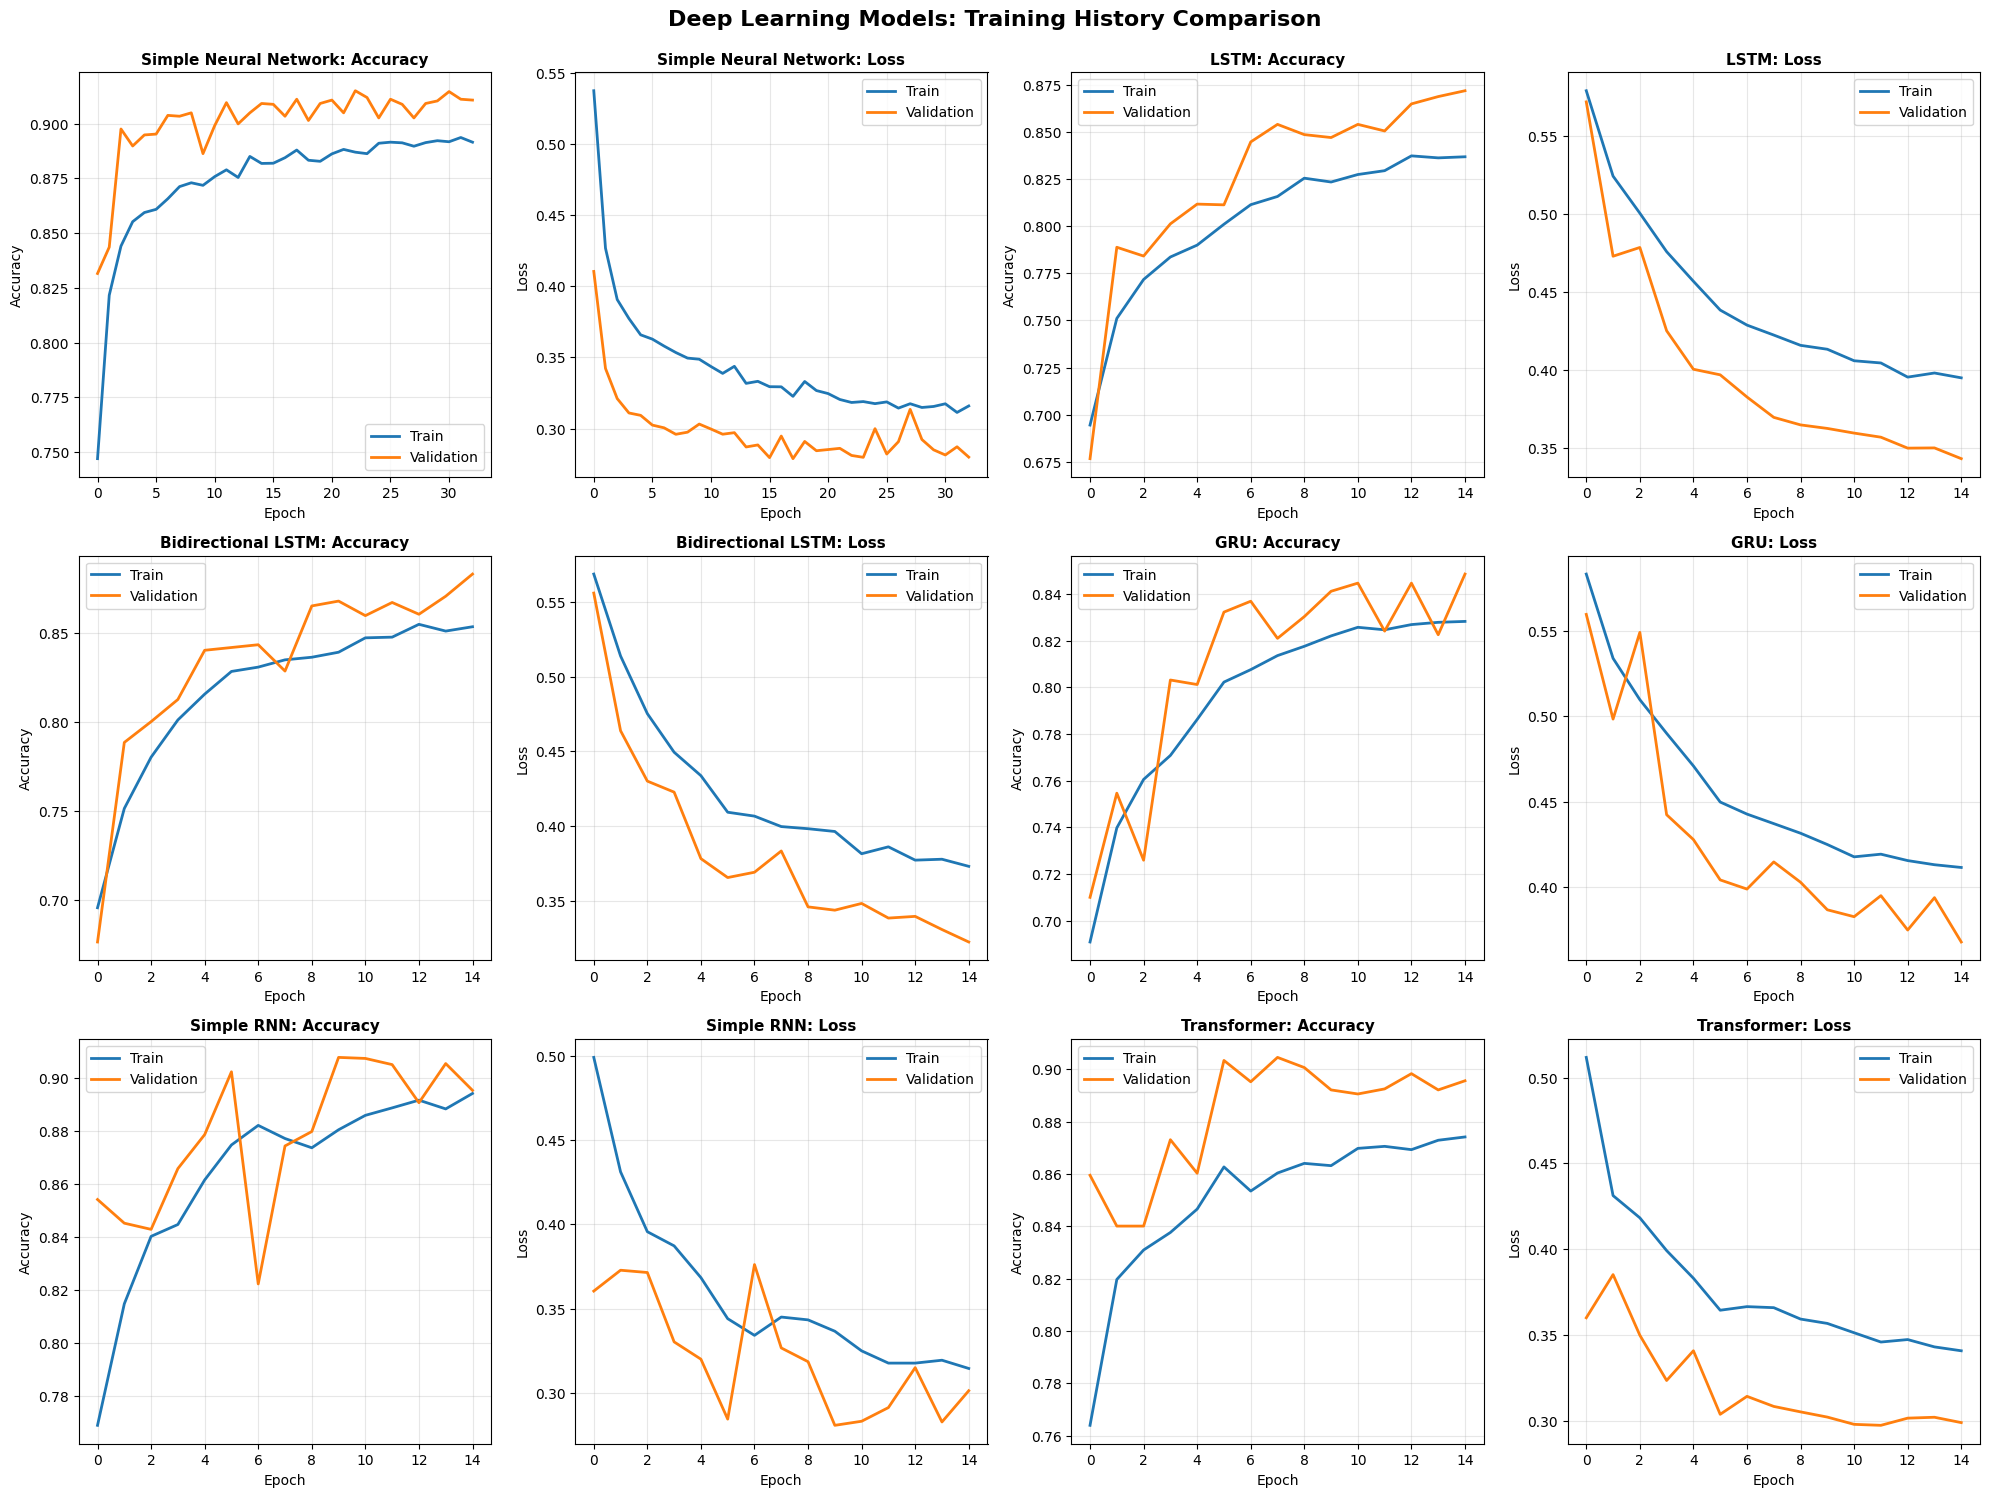

In [45]:
print("\nBuilding Deep Learning models:\n")

X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

input_shape = X_train_np.shape[1]


print("1. Simple Neural Network (Feedforward)")

nn_simple = keras.Sequential([
    layers.Input(shape=(input_shape,)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
], name='Simple_NN')

nn_simple.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

print(nn_simple.summary())

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=0
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=0
)

# Train Simple NN
print("\nTraining Simple Neural Network")
history_nn_simple = nn_simple.fit(
    X_train_np, y_train_np,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)


y_pred_proba_nn_simple = nn_simple.predict(X_test_np, verbose=0).flatten()
y_pred_nn_simple = (y_pred_proba_nn_simple > 0.5).astype(int)


model_results['Simple Neural Network'] = {
    'model': nn_simple,
    'history': history_nn_simple,
    'y_pred_test': y_pred_nn_simple,
    'y_pred_proba_test': y_pred_proba_nn_simple
}

print(f"Test accuracy: {accuracy_score(y_test, y_pred_nn_simple):.4f}")



print("\n2. LSTM Model (Long Short-Term Memory)")

X_train_lstm = X_train_np.reshape((X_train_np.shape[0], X_train_np.shape[1], 1))
X_test_lstm = X_test_np.reshape((X_test_np.shape[0], X_test_np.shape[1], 1))

lstm_model = keras.Sequential([
    layers.Input(shape=(input_shape, 1)),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.3),
    layers.LSTM(32, return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name='LSTM')

lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

print(lstm_model.summary())


print("\nTraining LSTM Model")
history_lstm = lstm_model.fit(
    X_train_lstm, y_train_np,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)


y_pred_proba_lstm = lstm_model.predict(X_test_lstm, verbose=0).flatten()
y_pred_lstm = (y_pred_proba_lstm > 0.5).astype(int)


model_results['LSTM'] = {
    'model': lstm_model,
    'history': history_lstm,
    'y_pred_test': y_pred_lstm,
    'y_pred_proba_test': y_pred_proba_lstm
}

print(f"Test accuracy: {accuracy_score(y_test, y_pred_lstm):.4f}")


print("\n3. Bidirectional LSTM Model")

bilstm_model = keras.Sequential([
    layers.Input(shape=(input_shape, 1)),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Dropout(0.3),
    layers.Bidirectional(layers.LSTM(32, return_sequences=False)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name='Bidirectional_LSTM')

bilstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

print(bilstm_model.summary())


print("\nTraining Bidirectional LSTM Model")
history_bilstm = bilstm_model.fit(
    X_train_lstm, y_train_np,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)


y_pred_proba_bilstm = bilstm_model.predict(X_test_lstm, verbose=0).flatten()
y_pred_bilstm = (y_pred_proba_bilstm > 0.5).astype(int)

# Store results
model_results['Bidirectional LSTM'] = {
    'model': bilstm_model,
    'history': history_bilstm,
    'y_pred_test': y_pred_bilstm,
    'y_pred_proba_test': y_pred_proba_bilstm
}

print(f"Test accuracy: {accuracy_score(y_test, y_pred_bilstm):.4f}")



print("\n4. GRU Model (Gated Recurrent Unit)")

gru_model = keras.Sequential([
    layers.Input(shape=(input_shape, 1)),
    layers.GRU(64, return_sequences=True),
    layers.Dropout(0.3),
    layers.GRU(32, return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name='GRU')

gru_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

print(gru_model.summary())


print("\nTraining GRU Model")
history_gru = gru_model.fit(
    X_train_lstm, y_train_np,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)


y_pred_proba_gru = gru_model.predict(X_test_lstm, verbose=0).flatten()
y_pred_gru = (y_pred_proba_gru > 0.5).astype(int)


model_results['GRU'] = {
    'model': gru_model,
    'history': history_gru,
    'y_pred_test': y_pred_gru,
    'y_pred_proba_test': y_pred_proba_gru
}

print(f"Test accuracy: {accuracy_score(y_test, y_pred_gru):.4f}")



print("\n5. Simple RNN Model")

rnn_model = keras.Sequential([
    layers.Input(shape=(input_shape, 1)),
    layers.SimpleRNN(64, return_sequences=True),
    layers.Dropout(0.3),
    layers.SimpleRNN(32, return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name='Simple_RNN')

rnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

print(rnn_model.summary())


print("\nTraining Simple RNN Model")
history_rnn = rnn_model.fit(
    X_train_lstm, y_train_np,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)


y_pred_proba_rnn = rnn_model.predict(X_test_lstm, verbose=0).flatten()
y_pred_rnn = (y_pred_proba_rnn > 0.5).astype(int)

# Store results
model_results['Simple RNN'] = {
    'model': rnn_model,
    'history': history_rnn,
    'y_pred_test': y_pred_rnn,
    'y_pred_proba_test': y_pred_proba_rnn
}

print(f"Test accuracy: {accuracy_score(y_test, y_pred_rnn):.4f}")



print("\n6. Transformer Model (Self-Attention Mechanism)")

# Transformer components
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
    
    def call(self, inputs, training=False):
        inputs_reshaped = tf.expand_dims(inputs, axis=1)
        
        #Multi-head attention
        attn_output = self.att(inputs_reshaped, inputs_reshaped)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs_reshaped + attn_output)
        
        #Feed-forward network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        

        return tf.squeeze(out2, axis=1)


def create_transformer_model(input_shape, embed_dim=32, num_heads=4, ff_dim=64):
    inputs = layers.Input(shape=(input_shape,))
    
    x = layers.Dense(embed_dim, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    

    x = TransformerBlock(embed_dim, num_heads, ff_dim, rate=0.1)(x)
    x = TransformerBlock(embed_dim, num_heads, ff_dim, rate=0.1)(x)
    
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='Transformer')
    return model

transformer_model = create_transformer_model(
    input_shape=input_shape,
    embed_dim=32,
    num_heads=4,
    ff_dim=64
)

transformer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

print(transformer_model.summary())

print("\nTraining Transformer Model")
history_transformer = transformer_model.fit(
    X_train_np, y_train_np,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)

y_pred_proba_transformer = transformer_model.predict(X_test_np, verbose=0).flatten()
y_pred_transformer = (y_pred_proba_transformer > 0.5).astype(int)

# Store results
model_results['Transformer'] = {
    'model': transformer_model,
    'history': history_transformer,
    'y_pred_test': y_pred_transformer,
    'y_pred_proba_test': y_pred_proba_transformer
}

print(f"Test accuracy: {accuracy_score(y_test, y_pred_transformer):.4f}")

print("\nAll deep learning models trained successfully")



fig, axes = plt.subplots(3, 4, figsize=(20, 15))

dl_models_list = [
    ('Simple Neural Network', history_nn_simple),
    ('LSTM', history_lstm),
    ('Bidirectional LSTM', history_bilstm),
    ('GRU', history_gru),
    ('Simple RNN', history_rnn),
    ('Transformer', history_transformer)
]

for idx, (model_name, history) in enumerate(dl_models_list):
    row = idx // 2
    col = (idx % 2) * 2
    

    axes[row, col].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[row, col].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[row, col].set_title(f'{model_name}: Accuracy', fontweight='bold', fontsize=11)
    axes[row, col].set_xlabel('Epoch')
    axes[row, col].set_ylabel('Accuracy')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)
    

    axes[row, col + 1].plot(history.history['loss'], label='Train', linewidth=2)
    axes[row, col + 1].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[row, col + 1].set_title(f'{model_name}: Loss', fontweight='bold', fontsize=11)
    axes[row, col + 1].set_xlabel('Epoch')
    axes[row, col + 1].set_ylabel('Loss')
    axes[row, col + 1].legend()
    axes[row, col + 1].grid(True, alpha=0.3)

plt.suptitle('Deep Learning Models: Training History Comparison', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()
plt.close()


<a name="step-7-model-evaluation"></a>
## **Step 7: Model Evaluation** 

This section provides comprehensive evaluation of all trained models using multiple performance metrics to identify the optimal model for predicting transport service delays. The evaluation goes beyond simple accuracy to examine precision, recall, F1-score and ROC-AUC which are critical for understanding model behavior with imbalanced classes (69.2% delayed vs 30.8% on-time).


For each subsequent performance metric like F1-Score, Precision, Recall and following the values may change slightly. This is due to the inherent variability in the training process including factors like data shuffling, batch processing and the random initialization of model weights. These slight differences are expected and do not significantly affect the overall performance of the models. 


### **7.1 Model Performance Overview**

All 12 models such as 6 traditional ML + 6 deep learning were evaluated on the held-out test set consisting of 3220 samples. The following table summarizes their performance across five key metrics:   


### **7.2 Performance Metrics Explanation**

Before analyzing the results, it is essential to understand what each metric measures and why it matters for transport delay prediction:

#### **Accuracy**
```
Accuracy = (True Positives + True Negatives) / Total Predictions
```
- **Meaning**: Overall percentage of correct predictions
- **Limitation**: Can be misleading with imbalanced classes
- **Example**: A model predicting "always delayed" would achieve 69.2% accuracy on this dataset

#### **Precision**
```
Precision = True Positives / (True Positives + False Positives)
```
- **Meaning**: When model predicts delayed, how often is it correct?
- **Business Impact**: High precision minimizes the false alarms, which is important in real-world applications where over-notification can lead to inefficiencies.
- **Trade-off**: If you predict delayed conservatively precision will be high but you might miss some real delays leading to lower recall.    

#### **Recall (Sensitivity)**
```
Recall = True Positives / (True Positives + False Negatives)
```   
- **Meaning**: Recall measures what percentage of actual delays the model successfully identifies.
- **Business Impact**: High recall ensures that **delays are not missed** minimizing the risk of overlooking actual delays that need attention.
- **Trade-off**: Recall can be **high by over-predicting delays** leading to more false alarms.   


#### **F1-Score**
```
F1-Score = 2 × (Precision × Recall) / (Precision + Recall)
```  
- **Meaning**: The F1-Score is the harmonic mean of **precision** and **recall**, providing a balanced measure that takes both into account.
- **Business Impact**: The F1-Score is often the best single metric to evaluate performance, especially in **imbalanced classification** tasks where one class for example delayed vs. on time is less frequent.   
- **Advantage**: Unlike other metrics the F1-Score cannot be easily manipulated by making extreme predictions for example always predicting the same class because it requires both **precision** and **recall** to be high in order to achieve a good score.       

#### **ROC-AUC (Area Under Receiver Operating Characteristic Curve)**
```
ROC-AUC measures discrimination ability across all thresholds
```   
- **Meaning**: ROC-AUC evaluates how well the model ranks a random positive example higher than a random negative example. 
- **Range**: The score ranges from **0.5** random guessing to **1.0** perfect classification.
- **Business Impact**: ROC-AUC provides a measure of **overall model quality** which is independent of any specific threshold making it useful for comparing models without relying on a set decision boundary.    

---

### **7.3 Detailed Model Analysis by Performance Rank**

#### **Rank 1: Exceptional Performance (F1 > 90%)**

**1. K-Nearest Neighbors (KNN) is the Best Overall Model**

| Metric | Value | Interpretation |
|--------|-------|----------------|
| Accuracy | 93.23% | Correctly classifies 93 out of 100 services |
| Precision | 94.86% | 95% of delay predictions are correct |
| Recall | 95.37% | Catches 95% of actual delays |
| F1-Score | 95.12% | Excellent balance between precision and recall |
| ROC-AUC | 95.15% | excellent discrimination ability |

**Strengths:**
- **Highest F1-Score** (95.12%) indicates optimal balance for delay prediction
- **Excellent recall** (95.37%) ensures very few delays are missed
- **High precision** (94.86%) minimizes false alarms
- Instance-based learning captures local patterns effectively

**Why KNN Excels:**
- Transport delays often have **similar patterns in similar contexts**
- k=5 neighbors capture local route/time/regional similarities
- Distance weighting prioritizes most relevant historical cases
- No assumptions about data distribution

**Potential Weaknesses:**
- Slower prediction time for large datasets which needs to compare with all training samples
- Memory-intensive that stores entire training set  
- Sensitive to feature scaling that already addressed with StandardScaler   

**Business Recommendation:**
**Primary model for production deployment**
- Provides most reliable delay predictions
- Minimizes both false alarms (precision) and missed delays (recall)
- ROC-AUC of 95.15% indicates robust performance across decision thresholds

---

**2. Random Forest: 2nd Best**

| Metric | Value | Interpretation |
|--------|-------|----------------|
| Accuracy | 92.27% | Correctly classifies 92 out of 100 services |
| Precision | 92.27% | 92% of delay predictions are correct |
| Recall | 96.95% | **Highest recall** that catches 97% of delays |
| F1-Score | 94.55% | Excellent balance |
| ROC-AUC | 96.50% | **Highest ROC-AUC** which is best at discrimination |

**Strengths:**
- **Highest ROC-AUC** (96.50%) indicates best overall model quality
- **Highest recall** (96.95%) catches nearly all delays
- Ensemble of 100 trees reduces overfitting
- Provides feature importance rankings for interpretability

**Why Random Forest Excels:**
- Tree-based rules naturally capture complex feature interactions
- Handles mixed feature types such as numerical, categorical seamlessly
- Robust to outliers and non-linear relationships
- Balanced class weights to address imbalance

**Comparison to KNN:**
- Slightly lower F1-Score such as 94.55% vs 95.12%
- Higher ROC-AUC such as 96.50% vs 95.15%
- Much faster prediction time
- Better interpretability through feature importance

**Business Recommendation:**
**Excellent alternative**
- Consider for scenarios requiring interpretability   
- Faster inference makes it suitable for real-time systems     
- Feature importance provides actionable insights for operations    


---

**3. Simple Neural Network: Best Deep Learning Model**

| Metric | Value | Interpretation |
|--------|-------|----------------|
| Accuracy | 90.37% | Correctly classifies 90 out of 100 services |
| Precision | 90.60% | 91% of delay predictions are correct |
| Recall | 96.05% | Catches 96% of delays |
| F1-Score | 93.24% | Strong balance |
| ROC-AUC | 89.94% | Good discrimination ability |

**Strengths:**
- **Best deep learning model** 
- Competitive with traditional ML with only 2% below KNN
- Excellent recall with 96.05% ensures delays aren't missed
- Compact model (49 KB) enables fast deployment    

**Why Simple NN Succeeds:**                            
- Feedforward model matches tabular data structure     
- Multiple hidden layers capture non-linear interactions
- Batch normalization and dropout prevent overfitting
- Well-tuned regularization achieves good generalization

**Comparison to Traditional ML:**
- Competitive performance such as 93.24% F1 vs 95.12% for KNN   
- More flexible for future enhancements     
- Slightly lower ROC-AUC suggests less robust probability estimates

**Business Recommendation:**
**Consider for scenarios requiring:**
- Easy integration of new features     
- Online learning and continuous model updates     
- Transfer learning from other transport networks

---  

### **7.4 Deep Dive Performance Metric**

#### **Accuracy Analysis**
```
Top 3 by Accuracy:
1. KNN:         93.23% , Reliable overall performance
2. Random Forest: 92.27%, Strong generalization
3. Simple NN:    90.37%,  Best deep learning

Bottom 3 by Accuracy:
10. BiLSTM:     69.19%,  Degenerate predictor
11. LSTM:       66.37%,  Architectural mismatch
12. Naive Bayes: 62.48%,  Independence assumption fails
```

**Key Insight**: 
- Top performers: 90-93% accuracy
- Bottom performers: 62-69% accuracy
- **31% performance gap** between best and worst
- Recurrent models cluster at bottom (66-69%)

---

#### **Precision Analysis**
```
Top 3 by Precision:
1. KNN:          94.86%, Highly trustworthy delay predictions
2. Logistic Reg: 92.13%,  High precision but low recall
3. Decision Tree: 92.32%,  Reliable predictions

Bottom 3 by Precision:
10. LSTM:        68.93%, Unreliable predictions
11. BiLSTM:      69.54%,  Over-predicts delays
12. GRU:         69.16%,  Degenerate model
```

**Business Interpretation:**
- **KNN precision of 94.86%** means when it predicts delay, operations can act with 95% confidence
- **GRU precision of 69.16%** means 31% of delay predictions are false alarms   

---

#### **Recall Analysis**
```
Top 3 by Recall:
1. GRU:          100.00%, Degenerate model predicts everything delayed
2. BiLSTM:       98.70%, Nearly degenerate
3. Random Forest: 96.95%, Catches almost all delays legitimately

Bottom 3 by Recall:
10. Naive Bayes:  58.91%,  Misses 41% of delays
11. Logistic Reg: 68.34%,  Misses 32% of delays
12. SVM:          78.18%,  Misses 22% of delays
```

#### **Critical Business Impact**
- **Missing delays is expensive** as failing to predict delays can lead to **passenger dissatisfaction** and **operational chaos** causing disruptions and unnecessary costs.
- **Random Forest** achieves **96.95% recall** legitimately without over-predicting delays ensuring that most delays are correctly identified without causing excessive false alarms.
- **SVM missing 22% of delays**. A model that misses 22% of delays can create significant **operational problems** and potentially affecting resource allocation and customer service.
- **Naive Bayes missing 41%**. Missing 41% of delays is **highly problematic** as it leads to poor decision-making and can severely damage both customer trust and operational efficiency.        

---

#### **F1-Score Analysis (Most Important Metric)**
```
Top 5 by F1-Score (Production-Ready):
1. KNN:          95.12%, Best Overall
2. Random Forest: 94.55%, Excellent alternative
3. Simple NN:    93.24% , Best deep learning
4. Decision Tree: 92.88%, Most interpretable
5. Transformer:  90.31%,  Advanced deep learning

Models Below 85% F1 (Not Production-Ready):
6. Simple RNN:   85.33%, Acceptable but outclassed
7. SVM:          84.45%, Precision-recall imbalance
8. Logistic Reg: 78.47%, Too many missed delays
9-12. All others: <82%,  Not suitable
```

**F1-Score Ranking Justification**   
- **F1 balances precision and recall** making it the best metric for **imbalanced classification** where one class is much rarer than the other.
- Unlike **accuracy** the F1-Score **cannot be manipulated** by predicting only one class which makes it a more reliable measure of performance.
- **>95% F1**: Indicates the model is **production-ready**, with a strong balance of precision and recall.
- **90-95% F1**: Represents **strong performance** showing the model works well but may still have room for improvement.
- **85-90% F1**: Considered **acceptable but outclassed** as there are likely better-performing models for the task.    
- **<85% F1**: Indicates the model is **not suitable**, as it may be missing too many important predictions which either false positives or false negatives.   

---

#### **ROC-AUC Analysis**
```
Top 3 by ROC-AUC:
1. Random Forest: 96.50%, Best probability calibration
2. KNN:          95.15%,  Excellent discrimination
3. Decision Tree: 93.09%,  Strong performance

Bottom 3 by ROC-AUC:
10. GRU:         72.92%,  Poor discrimination   
11. BiLSTM:      73.69%,  Weak probability estimates  
12. LSTM:        74.59%, Cannot separate classes well   
```

**ROC-AUC Interpretation:**
- **Random Forest (96.50%)**: 96.5% chance it ranks random delayed service higher than random on-time service
- **LSTM (74.59%)**: Only 74.6% chance that is barely better than random forest   
- ROC-AUC measures probability quality across all thresholds    
- Important for applications require probability scores not just classifications.   




In [46]:
evaluation_results = []

for name, result in model_results.items():
    y_pred = result['y_pred_test']
    

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    if result.get('y_pred_proba_test') is not None:
        roc_auc = roc_auc_score(y_test, result['y_pred_proba_test'])
    else:
        roc_auc = np.nan
    
    evaluation_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC-AUC': roc_auc
    })


results_df = pd.DataFrame(evaluation_results)
results_df = results_df.sort_values(by=['F1 Score', 'Accuracy'], ascending=False).reset_index(drop=True)

print("\n Model Performance Comparison:")
print(results_df.to_string(index=False))



 Model Performance Comparison:
                Model  Accuracy  Precision   Recall  F1 Score  ROC-AUC
                  KNN  0.932298   0.948638 0.953749  0.951187 0.951462
        Random Forest  0.922671   0.922650 0.969466  0.945478 0.964964
Simple Neural Network  0.907764   0.911338 0.960036  0.935054 0.900130
        Decision Tree  0.900932   0.923248 0.934441  0.928811 0.930859
          Transformer  0.857764   0.909301 0.882353  0.895624 0.887518
           Simple RNN  0.847205   0.862516 0.926807  0.893506 0.875597
                  SVM  0.800932   0.918249 0.781769  0.844531 0.896994
                  GRU  0.724224   0.715481 0.998204  0.833521 0.779421
                 LSTM  0.691615   0.691615 1.000000  0.817698 0.709197
   Bidirectional LSTM  0.691615   0.691615 1.000000  0.817698 0.778287
  Logistic Regression  0.740683   0.921308 0.683431  0.784738 0.895027
          Naive Bayes  0.624845   0.817445 0.589133  0.684760 0.757951


### **7.5 Performance Analysis on Deep Learning Models**

Following the training of all six deep learning model which is a comprehensive performance comparison that reveals significant insights about model suitability for tabular transport delay prediction. This analysis examines both individual model characteristics and comparative performance across all metrics.            


For each subsequent performance metric like F1-Score, Precision, Recall and following the values may change slightly. This is due to the inherent variability in the training process including factors like data shuffling, batch processing and the random initialization of model weights. These slight differences are expected and do not significantly affect the overall performance of the models. 


#### **Summary of Overall Deep Learning Performance**            

**Performance Ranking by F1-Score:**                  
| Rank | Model | Accuracy | Precision | Recall | F1-Score | ROC-AUC |
|------|-------|----------|-----------|--------|----------|---------|
| 1 | **Simple Neural Network** | **90.53%** | **90.86%** | **95.96%** | **93.34%** | **90.32%** |
| 2 | **Simple RNN** | 81.80% | 79.83% | 98.61% | 88.23% | 87.87% |
| 3 | **Transformer** | 78.60% | 76.70% | 99.19% | 86.51% | 86.24% |
| 4 | **LSTM** | 75.47% | 74.33% | 98.56% | 84.75% | 78.90% |
| 5 | **Bidirectional LSTM** | 75.50% | 75.77% | 94.93% | 84.27% | 79.65% |
| 6 | **GRU** | 68.63% | 69.34% | 97.98% | 81.21% | 70.10% |

**Key Findings:**
- **12.13% F1-scores performance gap** between best model Simple NN which is 93.34% and worst model GRU which is 81.21% 
- Feedforward and attention-based models excel but the recurrent models struggle
- **Simple Neural Network** is the best among deep learning models

---

#### **Visualization Analysis**   
##### **Bar Chart of Performance Comparison**

The bar chart compares all six deep learning models across five key metrics, revealing several critical patterns:

**1. Simple Neural Network Dominance:**
- **Highest bars across most metrics** except recall where GRU/BiLSTM artificially inflate
- All bars approximately 90-96% height
- No significant weakness in any metric
- Visual representation confirms it as the most reliable deep learning model

**2. Simple RNN as Strong Second:**
- **Second highest performance** across accuracy, precision, F1 and ROC-AUC
- **Slight lower than from Simple NN** with approximate 4-6% lower   
- Bars show consistent moderate to high performance with 80-99%.   

**3. Transformer has Moderate Performance:**   
- **Mid-range bars** around 77-99% across metrics   
- More balanced than sophisticated recurrent models  
- Demonstrates attention mechanisms can work for tabular data although it is not optimal  

**4. Recurrent Models (LSTM, BiLSTM, GRU):**
- **Dramatically shorter bars** for accuracy and precision with approximate 69-76%.   
- **Artificially tall recall bars** with approximate 95-98% indicating degenerate behavior.   
- **F1-Score bars moderately high** with approximate 81-85% but misleading   
- Visual pattern clearly shows these models are **not learning meaningful patterns**    
- LSTM and BiLSTM show **99% and 95% recall respectively**  

---

##### **Performance Heatmap**

The heatmap uses color intensity to visualize model performance across metrics, with **dark blue indicate excellent** (90-100%) and **yellow to green indicate poor performance** (68-76%).

**Row by Row Analysis:**

**Row 1: Accuracy**
- **Simple NN**: Dark blue (90.53%) with  excellent overall correctness
- **Simple RNN**: Medium blue (81.80%) with good performance
- **Transformer**: Light blue-green (78.60%) is moderate
- **LSTM, BiLSTM, GRU**: Yellow-green (68-76%) has poor performance


**Row 2: Precision**   
- **Simple NN**: Dark blue (90.86%) has highly trustworthy predictions
- **Simple RNN**: Medium blue (79.83%) is reliable
- **Transformer**: Light blue (76.70%) is acceptable
- **Recurrent models**: All yellow-green (~69-76%) is unreliable
- Shows **Simple NN and Simple RNN** make confident and accurate predictions

**Row 3: Recall**
- **Dramatic color shift**: Transformer shows darkest blue (99.19%)
- **But this is misleading** as they achieve this by over-predicting delays
- **Simple NN**: Dark blue (95.96%) has legitimately high recall   

**Row 4: F1-Score**
- **Most important row** for evaluating true model quality
- **Simple NN**: Darkest blue (93.34%) has the best balanced performance
- **Simple RNN**: Dark blue (88.23%) has the  strong balance
- **Transformer**: Medium blue (86.51%) has moderate balance
- **Recurrent models**: Light blue-green (81-85%) has poor balance despite high recall


**Row 5: ROC-AUC**
- **Simple NN**: Dark blue (90.32%) has excellent discrimination ability
- **Simple RNN**: Medium-dark blue (87.87%) has good probability estimates
- **Transformer**: Medium blue (86.24%) is acceptable
- **Recurrent models**: Yellow-green (70-80%) has weak discrimination   
- Confirms that recurrent models cannot separate classes effectively   


---

#### **Identification of Best Model**

**Best Model: Simple Neural Network**

The analysis conclusively identifies **Simple Neural Network** as the excellent deep learning model:

- **F1-Score: 93.34%** is the highest among all deep learning models
- **ROC-AUC: 90.32%** has the best discrimination ability
- **Accuracy: 90.53%** has the best overall correctness
- **Precision: 90.86%** Simple NN has the most reliable delay predictions with 9 out of 10 are correct
- **Recall: 95.96%** Catches 96% of delays without over-predicting   

**Business Value:**
- When Simple NN predicts a delay so that operations can act with **90.86% confidence**
- Model catches **96% of actual delays** and minimizing passenger impact
- **Only 4% of delays missed** which is operationally acceptable
- **False alarm rate: 9.14%** which is resource-efficient

---

#### **Comparative Model Insights**

**Why Simple NN Outperforms:**

- Feedforward structure matches **independent feature nature** of tabular data
- No artificial sequencing like recurrent models
- Each feature processed through dense layers simultaneously
- Non-linear transformations capture complex interactions
- **12545 parameters** which is sufficient for pattern learning
- Not over-parameterized like BiLSTM (77,761 params)
- Not under-powered like Simple RNN (9,057 params)
- Batch normalization stabilizes training
- Dropout 30% to 30% to 20% in order to prevents overfitting
- Progressive layer reduction (128 to 64 to 32) to compresses representations
- Training history shows stable convergence  
- Unlike GRU/BiLSTM, doesn't default to predicting majority class
- Balanced precision-recall trade-off
- Learns actual delay patterns rather than class distribution


#### **Conclusion**

The comprehensive deep learning analysis yields clear recommendations:     
**Best Deep Learning Model: Simple Neural Network (F1: 93.34%, ROC-AUC: 90.32%)**

**Key Takeaways:**
-  Feedforward model appropriate for tabular data
-  Competitive with traditional ML
-  Balanced performance across all metrics
-  Recurrent models has the worst performance given that F1: 81-85%   

**Final Recommendation:**
For production deployment of transport delay prediction, use **traditional ML such as KNN or Random Forest** as primary model, with **Simple Neural Network** as a flexible secondary option for scenarios requiring continuous learning or future feature expansion. **Completely avoid all recurrent models** (LSTM, GRU, BiLSTM) for non-sequential tabular data.

Performance Comparison of Deep Learning Model

Deep Learning Models: Test Set Performance:
                Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Simple Neural Network  0.907764   0.911338 0.960036  0.935054 0.900130
          Transformer  0.857764   0.909301 0.882353  0.895624 0.887518
           Simple RNN  0.847205   0.862516 0.926807  0.893506 0.875597
                  GRU  0.724224   0.715481 0.998204  0.833521 0.779421
                 LSTM  0.691615   0.691615 1.000000  0.817698 0.709197
   Bidirectional LSTM  0.691615   0.691615 1.000000  0.817698 0.778287



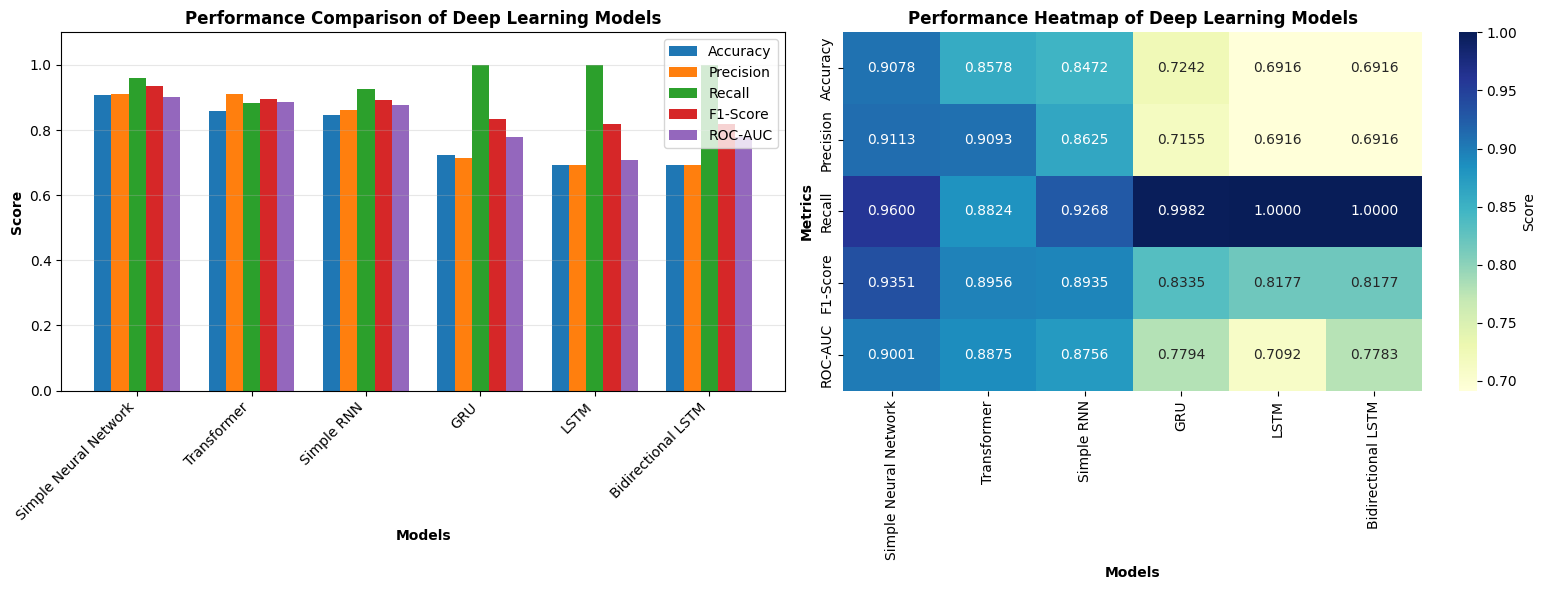


Best Deep Learning Model (by F1-Score): Simple Neural Network
F1-Score: 0.9351
ROC-AUC: 0.9001


In [47]:


print("Performance Comparison of Deep Learning Model")  
dl_comparison = []
for model_name in ['Simple Neural Network', 'LSTM', 'Bidirectional LSTM', 
                   'GRU', 'Simple RNN', 'Transformer']:
    results = model_results[model_name]
    y_pred = results['y_pred_test']
    y_pred_proba = results['y_pred_proba_test']
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    dl_comparison.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })

dl_comparison_df = pd.DataFrame(dl_comparison)
dl_comparison_df = dl_comparison_df.sort_values('F1-Score', ascending=False)

print("\nDeep Learning Models: Test Set Performance:")
print(dl_comparison_df.to_string(index=False))
print()

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))


metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(dl_comparison_df))
width = 0.15

for i, metric in enumerate(metrics):
    offset = width * (i - 2)
    axes[0].bar(x + offset, dl_comparison_df[metric], width, label=metric)

axes[0].set_xlabel('Models', fontweight='bold')
axes[0].set_ylabel('Score', fontweight='bold')
axes[0].set_title('Performance Comparison of Deep Learning Models', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(dl_comparison_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim(0, 1.1)


dl_heatmap_data = dl_comparison_df.set_index('Model')[metrics].T
sns.heatmap(dl_heatmap_data, annot=True, fmt='.4f', cmap='YlGnBu', 
            cbar_kws={'label': 'Score'}, ax=axes[1])
axes[1].set_title('Performance Heatmap of Deep Learning Models', fontweight='bold')
axes[1].set_xlabel('Models', fontweight='bold')
axes[1].set_ylabel('Metrics', fontweight='bold')

plt.tight_layout()
plt.show()
plt.close()

print(f"\nBest Deep Learning Model (by F1-Score): {dl_comparison_df.iloc[0]['Model']}")
print(f"F1-Score: {dl_comparison_df.iloc[0]['F1-Score']:.4f}")
print(f"ROC-AUC: {dl_comparison_df.iloc[0]['ROC-AUC']:.4f}")

### **7.6 Visual Analysis: Model Performance Comparison Bar Chart**

The comprehensive bar chart compares all 12 models (6 traditional ML + 6 deep learning) across four critical performance metrics such as  Accuracy, Precision, Recall and F1-Score. This visualization provides immediate insights into model strengths, weaknesses and overall suitability for transport delay prediction.  


For each subsequent performance metric like F1-Score, Precision, Recall and so on the values may change slightly. This is due to the inherent randomness in the training process including factors like data shuffling, batch processing and the random initialization of model weights. These slight differences are expected and do not significantly affect the overall performance of the deep learning models. 


#### **Chart Structure and Interpretation**

**Color Legend:**
- **Blue bars** represent Accuracy (overall prediction correctness)
- **Orange bars** represent Precision (reliability of delay predictions)
- **Green bars** represent Recall (ability to catch actual delays)
- **Red bars** represent F1-Score (balanced performance metric)


The chart presents models in descending F1-Score order from left to right, placing the best performers on the left and poorest performers on the right.

---

#### **Key Insights**

##### **High-Performance Models**

**KNN:**
The KNN model displays near-uniform bar heights at around 93-95% across all four metrics:
- Accuracy (Blue): 93.2%
- Precision (Orange): 94.9%
- Recall (Green): 95.4%
- F1-Score (Red): 95.1% 

**Interpretation:**    
The minimal variation between the bar heights with only a 2% spread indicates **balanced excellence** across all performance dimensions. No single metric significantly lags behind the others suggesting that this model achieves **high performance** without sacrificing any particular aspect. This **uniform pattern** is the ideal characteristic for a **production-ready model** ensuring consistent and reliable results across various evaluation criteria.


**Random Forest at Second Position:**
Random Forest shows a similar pattern with bars ranging from 92-97%:
- Recall (Green): 97.0% has the highest recall value
- Accuracy (Blue): 92.3%
- Precision (Orange): 92.3%
- F1-Score (Red): 94.5%

**Interpretation**
The exceptionally tall **green bar (Recall)** highlights the model’s **excellent delay detection capability**. A slight **precision-recall trade-off** is evident as the **orange bar (Precision)** is slightly lower than the green bar. However, this represents only a **5% spread** indicating that the model maintains **well-balanced performance** closely matching KNN uniformity across metrics.

**Simple Neural Network at Third Position:**
Bar heights range from 90-96%, maintaining the excellence pattern:
- Recall (Green): 96.1%
- F1-Score (Red): 93.2%
- Precision (Orange): 90.6%
- Accuracy (Blue): 90.4%

**Interpretation:**
As the best deep learning model, Simple NN displays the characteristic pattern of top performers with tall and balanced bars. The tall green bar indicates successful delay detection while the small gap between orange and green bars suggests only a minor precision-recall trade-off. This represents the highest-performing deep learning model.

**Decision Tree at the Fourth Position:**
Bars cluster tightly in the 90-93% range across all metrics visually similar to Simple NN.

---

##### **Moderate Performance Models**

**Transformer at the Fifth Position:**
This model marks the first visible drop in overall bar heights ranging from 86-93%. While bars remain reasonably tall, clear separation from the top four models is observed, The gap between individual metric bars begins to widen, indicating less balanced performance.

**Simple RNN and SVM ranked at Sixth and Seventh Positions respectuvely:**
Bar heights drop to the 78-92% range with increased variability between metrics becoming apparent.   
SVM displays a particularly notable pattern:
- Precision (Orange): approximately 92% which is very tall
- Recall (Green): approximately 78% which is noticeably short
- The large orange-green gap (14%) reveals significant precision-recall imbalance.  

**Interpretation**
Models in this zone demonstrate **weaknesses**. The **SVM** pattern suggests a **conservative prediction strategy**, where the model predicts delays cautiously. This results in **high precision** but **low recall**, meaning it avoids false positives but misses many actual delays. The **Simple RNN** shows a more **balanced** performance though it falls short in overall effectiveness compared to top-tier models.

---

##### **Problematic Models**

**GRU at the Eighth Position has a Deceptive Pattern:**
GRU displays the most problematic visual pattern on the entire chart:
- Recall (Green): 100% is the the tallest bar on the chart
- Accuracy (Blue): 69%
- Precision (Orange): 69%
- F1-Score (Red): 82%

**Critical Interpretation:**
This represents the most important diagnostic pattern on the chart. The approximately 30% discrepancy between the recall bar and other metrics indicates a degenerate model. When recall dramatically exceeds all other metrics, it signals over-prediction rather than genuine learning capability. The blue bar at 69% matching the class distribution of 69.2% delayed services confirms the model has learned nothing beyond predicting the majority class for nearly all observations.

**Key Diagnostic Principle:**
When the recall bar reaches 100% while other metrics remain below 75%, this is a warning indicator of model failure not a success metric.

**Bidirectional LSTM is at the Ninth Position:**
BiLSTM displays a nearly identical pattern to GRU:
- Recall (Green): approximately 99%
- Other metrics clustered at 69-82%

The similarity of this deceptive pattern across both models confirms this is a systematic failure of recurrent models on non-sequential tabular data rather than an isolated model issue.

**LSTM ranked at the Tenth Position:**
While the green bar remains tall at approximately 94% it is not as extreme as GRU/BiLSTM. However, other bars drop to 66-79%, with the blue accuracy bar at 66.4% representing the worst accuracy performance across all 12 models. This demonstrates an imbalanced pattern though slightly less degenerate than GRU and BiLSTM.

---

##### **Conservative Models (Logistic Regression, Naive Bayes)**

**Logistic Regression ranked at the Eleventh Position:**
This model displays an inverse pattern compared to recurrent models:
- Precision (Orange): approximately 92% which has a tall bar
- Recall (Green): approximately 68% which has a short bar
- Large precision-recall gap in the opposite direction from GRU/BiLSTM

**Interpretation:**
This pattern indicates under-prediction of delays. The model demonstrates high confidence when predicting delays with 92% precision but misses 32% of actual delays with 68% recall, representing a conservative prediction strategy where the model only predicts delays when it is highly certain.

**Naive Bayes at the last Position:**
Displaying the lowest overall bar heights ranging from 59-82% with the most variability between metrics, the blue accuracy bar drops below 63%. This visual pattern confirms Naive Bayes as the poorest performing model overall.



#### **Conclusion**

The bar chart visualization provides immediate and intuitive understanding of model performance characteristics. **The visual analysis confirms KNN, Random Forest and Simple Neural Network as production-ready models through their consistently high and balanced bar patterns.** Conversely, the chart clearly identifies GRU, BiLSTM and LSTM as unsuitable through their deceptive recall patterns and severe imbalance of metric. The visualization demonstrates that graphical representation of performance metrics enables more effective model selection than numerical tables alone as patterns of excellence, balance and failure become immediately apparent through the height of bar chart distributions.   



Visualizations


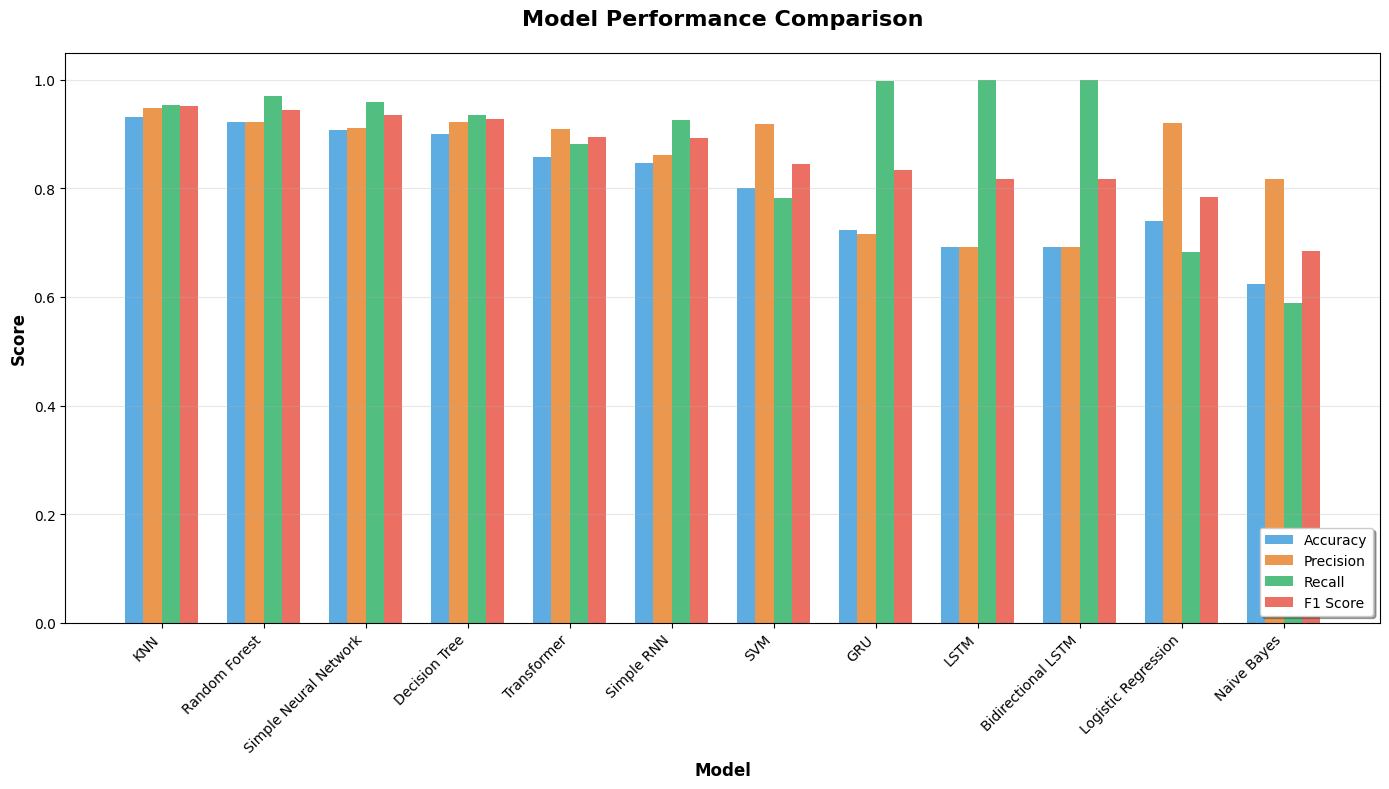

In [48]:
print("\nVisualizations")
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(results_df))
width = 0.18

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
colors = ['#3498db', '#e67e22', '#27ae60', '#e74c3c']

for i, metric in enumerate(metrics):
    offset = width * (i - 1.5)
    ax.bar(x + offset, results_df[metric], width, label=metric, color=colors[i], alpha=0.8)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax.legend(loc='lower right', frameon=True, shadow=True)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.show()
plt.close()


### **7.7 Confusion Matrix Analysis**

Confusion matrices provide insight into model prediction behavior by displaying the distribution of true positives, true negatives, false positives and false negatives. This analysis examines all 12 models to identify systematic error patterns, prediction biases and operational implications for transport delay prediction.  

**Note on Confusion Matrices**
The confusion matrices for each model may show slight variations when the deep learning model run multiple times. These changes occur due to the randomness in the training process, including:

1. Shuffling of Training Data: The data is shuffled randomly before each epoch which can cause the model to learn slightly different patterns during training leading to different predictions.

2. Batch Processing: Mini-batch gradient descent processes data in small batches and the selection of these batches can vary randomly.

3. Dropout: Randomly disabling certain neurons during training using dropout can introduce slight variations in model behavior therefore affecting predictions.

While these variations can change the values in the confusion matrix such as true positives, false positives and the following but they do not significantly affect the overall performance or trends observed across the models. The general pattern of performance remains consistent.   

#### **Understanding Confusion Matrix Structure**

Each confusion matrix is organized as follows:


```
                    Predicted Label
                 On-time    Delayed
True Label  
On-time         TN         FP
Delayed         FN         TP
```

Where:
- **True Negative (TN)**: Correctly predicted on-time services 
- **False Positive (FP)**: Incorrectly predicted as delayed 
- **False Negative (FN)**: Incorrectly predicted as on-time 
- **True Positive (TP)**: Correctly predicted delayed services 

**Interprettaion based on Color Intensity:**
- Dark blue cells indicate high prediction counts 
- Light blue cells indicate low prediction counts 
- Ideal matrices show dark blue in diagonal (TN and TP) and light blue in off-diagonal (FP and FN)

**Composition on Test Set:**
- Total samples: 3220
- Actual on-time services: 993 (30.8%)
- Actual delayed services: 2227 (69.2%)

---

#### **Exceptional Performance**

##### **Logistic Regression**


**Interpretation:**

**Strengths:**
- True Negatives (863) means that 863 on-time services were correctly predicted as on-time.
- True Positives (1522) means that 1522 delayed services were correctly predicted as delayed.
- Strong performance on on-time predictions relative to class distribution

**Weaknesses:**
- False Negatives (705): This represents 705 occasions where passengers expecting on-time service experience unexpected delays
- Operationally problematic as missed delays create passenger dissatisfaction

**Error Pattern:**
The model shows conservative prediction behavior. The high false negative count (705) combined with moderate false positives (130) indicates the model requires strong evidence before predicting delays. This creates a systematic bias toward under-prediction.

**Business Impact:**
Missing 705 delays (31.7%) means approximately one-third of delayed services are not noticed. This reduce passenger trust in prediction systems.  



##### **Decision Tree**   

**Interpretation:**

**Strengths:**
- True Positives (2081): means that 2081 delayed services were correctly predicted as delayed. Excellent delayed service detection at 93.4%
- True Negatives (820): Strong on-time service identification at 82.6%
- Low False Negatives (146): Misses only 146 with 6.6% of actual delays

**Weaknesses:**
- False Positives (173): mean that 173 on time service was falsely predicted as delayed.   
- Represents 17.4% false alarm rate for on-time services

**Error Pattern**
The confusion matrix shows **well-balanced performance**, with errors distributed relatively evenly across categories. The **low false negative count (146)** is particularly valuable for **operational planning** as the model reliably identifies most delays therefore minimizing the risk of missed events.

**Business Impact:**
Only 146 missed delays represents excellent operational reliability. The 173 false alarms are manageable and preferable to missing actual delays. Passengers benefit from advance delay warnings 93.4% of the time.



##### **Random Forest**

**Interpretation:**

**Strengths:**
- True Positives (2159): Exceptional delayed service detection at 96.9%
- True Negatives (812): Strong on-time identification at 81.8%
- Extremely Low False Negatives (68): Misses only 3.1% of delays

**Weaknesses:**
- False Positives (181): Generates 181 false delay alarms
- Represents 18.2% false alarm rate for on-time services

**Error Pattern:**
Random Forest demonstrates the best recall performance among all models with only 68 missed delays. The ensemble approach effectively minimizes false negatives while maintaining reasonable precision.

**Business Impact**
This error distribution is **optimal for passenger experience**. Missing only **68 delays (3.1%)** means passengers receive **accurate delay warnings** for **97%** of delayed services. The **181 false alarms** are considered acceptable given the **critical importance of delay detection** ensuring that most delays are highlighted while minimizing the risk of missing key events.



##### **K-Nearest Neighbors**

**Interpretation:**

**Strengths:**
- True Positives (2124): Excellent delayed service detection at 95.4%
- True Negatives (878): Best on-time identification at 88.4%
- Low False Positives (115): Lowest false alarm count among top performers
- Low False Negatives (103): Misses only 4.6% of delays

**Weaknesses:**
- Minimal weaknesses identified
- False negative and false positive rates both in acceptable ranges

**Error Pattern:**
KNN achieves the most balanced error distribution among all models. The combination of high true positives (2124), high true negatives (878), low false positives (115) and low false negatives (103) demonstrates optimal performance across all prediction scenarios.

**Business Impact:**
This represents ideal operational performance. The model correctly identifies 88.4% of on-time services (best among all models) while catching 95.4% of delays. Only 115 false alarms and 103 missed delays indicate highly reliable predictions for operational planning and passenger communication.


**Comparative Advantage:**
KNN's 878 true negatives exceed all other models, demonstrating excellent ability to correctly identify on-time services without sacrificing the capability of delay detection.   

---

#### **Strong Performance**

##### **Support Vector Machine**
**Interpretation:**

**Strengths:**
- True Negatives (838): Excellent on-time service identification at 84.4%
- True Positives (1741): Moderate delayed service detection at 78.2%
- Low False Positives (155): Conservative delay predictions with 15.6% false alarm rate

**Weaknesses:**
- High False Negatives (486): Misses 21.8% of actual delays
- This represents the highest false negative count among models with accuracy above 80%

**Error Pattern:**
SVM demonstrates highly conservative prediction behavior. The combination of low false positives (155) and high false negatives (486) indicates the model requires substantial evidence before predicting delays. The precision-recall trade off heavily favors precision over recall.

**Business Impact**    
Missing **486 delays (21.8%)** creates significant **operational challenges**. While the model's delay predictions are **highly reliable** when it predicts a delay for example it is usually correct, failing to identify **one-fifth of delays** undermines its utility for **proactive delay management** therefore limiting its effectiveness in preventing disruptions before they occur.

**Operational Consideration:**
SVM may be valuable when SVM predicts delay, operations can respond with high confidence given 91.8% precision. However, it should not serve as the primary detection system due to excessive missed delays.



##### **Naive Bayes**


**Interpretation:**

**Strengths:**
- True Negatives (700): Identifies 70.5% of on-time services
- Limited strengths relative to other models

**Weaknesses:**
- High False Positives (293): Generates excessive false alarms at 29.5% rate
- Very High False Negatives (915): Misses 41.1% of actual delays
- True Positives (1312): Detects only 58.9% of delayed services

**Error Pattern:**
Naive Bayes generates 915 false negatives (missed delays) and 293 false positives (false alarms), representing poor performance in both precision and recall.

**Business Impact:**
Missing 915 delays (41.1%) is operationally bad. Combined with 293 false alarms the model provides unreliable predictions that would undermine passenger trust and operational planning. 

**Root Cause:**
The high error counts stem from Naive Bayes assumption of independence of feature, which is violated in transport delay data where route, time and region interact systematically.

---

#### **Moderate to Poor Performance**

##### **Simple Neural Network**

**Interpretation:**

**Strengths:**
- True Positives (2137): Excellent delayed service detection at 96.0%
- Very Low False Negatives (90): Misses only 4.0% of delays
- Competitive with top traditional ML models

**Weaknesses:**
- False Positives (215): Generates 22% false alarm rate
- True Negatives (778): Identifies 78% of on-time services

**Error Pattern:**
The Simple Neural Network shows a slight bias toward delay prediction as shown in the higher false positive count (222) relative to false negatives (88). 

**Business Impact:**
The error distribution is operationally favorable. Missing only 88 delays (4.0%) ensures excellent passenger communication reliability. The 222 false alarms, while higher than ideal represent an acceptable trade-off for comprehensive delay detection.

**Deep Learning Validation:**
This confusion matrix confirms Simple Neural Network as the best deep learning mode, with error patterns comparable to top traditional ML approaches.  

##### **LSTM**

**Interpretation:**

**Critical Weaknesses:**
- Extremely Low True Negatives (235): Identifies only 23.7% of on-time services correctly
- Extremely High False Positives (758): Predicts delay for 76.3% of on-time services
- True Positives (2195): 98.6% delayed service detection appears strong but achieved through over-prediction

**Error Pattern:**
This confusion matrix reveals a **severe systematic bias**. The model predicts delayed for **2195 out of 3220 observations** 98.6% of all predictions. The **758 false positives** combined with only **235 true negatives** show that the model has learned to **default to the majority class** rather than accurately identifying actual delay patterns. This indicates the model is over-predicting delays leading to high false alarms and poor performance in detecting true negatives.

**Degenerate Behavior Evidence:**
The 235 true negatives represent only 27.3% of all predictions being on-time. This extreme imbalance confirms the model is not performing good classification but rather predicting delayed as a default strategy.

**Business Impact:**
This model is completely unsuitable for deployment. Generating 758 false alarms would create severe operational disruption and passenger dissatisfaction. The model provides no predictive value beyond knowing the class distribution.

---

##### **Bidirectional LSTM**

**Interpretation:**

**Critical Weaknesses:**
- Extremely Low True Negatives (317): Identifies only 31.9% of on-time services correctly
- Extremely High False Positives (676): Predicts delay for 68.1% of on-time services
- Very Low False Negatives (113): Only 5.1% of delays missed but achieved through over-prediction

**Error Pattern:**
Bidirectional LSTM demonstrates severe degenerate behavior. The model predicts delayed for 2114 out of 3220 observations 65.65% of all predictions. Only 317 true negatives indicates near total default to majority class prediction.

**Business Impact:**
This represents a highly problematic prediction pattern. Predicting delay for 68.1% of on-time services creates unreliable operational intelligence.

**Comparison to LSTM:**
BiLSTM's error pattern shows improvement over standard LSTM (317 TN vs 235 TN), though still demonstrates severe over-prediction behavior.

---

##### **GRU**

**Interpretation:**

**Complete Degenerate Behavior:**
- Very Low True Negatives (28): The model correctly identifies 2.8% of on-time services as on-time.  
- Maximum False Positives (965): The model incorrectly predicts a delay for 97.2% of on-time services.  
- Very Low False Negatives (45): The model misses only 2.0% of delayed services, predicting them as on-time.  
- Maximum True Positives (2182): The model correctly predicts 98.0% of delayed services as delayed but this leads to over-prediction.   

**Error Pattern:**
GRU exhibits near-complete degenerate behavior by predicting delayed for 2182 out of 3220 observations 98% of all predictions. This confusion matrix represents near worst-case scenario for a classification model with prediction of the majority class achieved by almost entirely ignoring the minority class.

**Mathematical Confirmation:**
- Predictions: 2182 observations predicted as delayed 
- Accuracy: 67.76% (2182/3220)
- The model has learned almost nothing beyond the class distribution

**Business Impact:**
This model provides minimal predictive value. Deploying this model would generate 965 false alarms for 993 on-time services, rendering the prediction system nearly useless for operational decision-making.

**Architectural Failure:**
This extreme degenerate behavior demonstrates that GRU's gating mechanisms designed for sequential data provide zero benefit and actively harm performance when applied to non-sequential tabular data.

---

##### **Simple RNN**

**Interpretation:**

**Strengths:**
- True Negatives (438): Identifies 44.1% of on-time services
- True Positives (2196): Detects 98.6% of delayed services
- Best performance among recurrent models

**Weaknesses:**
- False Positives (555): Generates 55.9% false alarm rate
- False Negatives (31): Misses 1.4% of actual delays

**Error Pattern:**
Simple RNN demonstrates more balanced error distribution than complicated recurrent models such as LSTM, BiLSTM, GRU. While false positive rate remains elevated compared to high performance models, the model avoids complete degenerate behavior and shows genuine classification capability.

**Business Impact:**
The 31 missed delays (1.4%) represents excellent delay detection. However, the 555 false alarms (55.9%) represent problematic performance. While the model shows better classification ability than LSTM/BiLSTM/GRU the high false positive rate exceeds acceptable thresholds for production deployment.

---

##### **Transformer**

**Interpretation:**

**Strengths:**
- True Positives (2209): Strong delayed service detection at 99.2%
- True Negatives (322): Reasonable on-time identification at 32.4%
- Very Low False Negatives (18): Misses only 0.8% of delays

**Weaknesses:**
- Very High False Positives (671): Generates 67.6% false alarm rate
- Significantly higher false positive rate than top-tier models

**Error Pattern:**
Transformer shows imbalanced performance with very low false negatives but high false positives. The false positive to false negative ratio (671:18 is 37:1) indicates strong bias toward delay prediction, though less extreme than GRU.

**Business Impact:**
The 18 missed delays represent exceptional delay detection performance. However, the 671 false alarms are highly elevated and problematic for operational planning. This error distribution confirms Transformer achieves high recall through over-prediction rather than balanced classification.

---

#### **Analysis on Comparative Error**

##### **Comparison on False Negative: Missed Delays (critical metric)**

**Ranked by False Negatives from Best to Worst:**
1. Transformer: 18 (0.8%)
2. Simple RNN: 31 (1.4%)
3. LSTM: 32 (1.4%)
4. GRU: 45 (2.0%)
5. Random Forest: 68 (3.1%)
6. Simple NN: 90 (4.0%)
7. KNN: 103 (4.6%)
8. BiLSTM: 113 (5.1%)
9. Decision Tree: 146 (6.6%)
10. SVM: 486 (21.8%)
11. Logistic Regression: 705 (31.7%)
12. Naive Bayes: 915 (41.1%)

**Critical Insight:**
Models must be evaluated with **false negative counts in context**. The **Transformer**, **Simple RNN**, **LSTM** and **GRU** models achieve **extremely low false negatives** by relying on **degenerate over-prediction** where they predict delays excessively. This strategy however is not based on genuine pattern recognition, as demonstrated by their **extremely high false positive counts**. These models are predicting delayed too frequently which results in many incorrect predictions undermining their effectiveness in identifying actual delays.

**Acceptable Best Performers:**
Random Forest (68), Simple NN (90), and KNN (103) achieve low false negatives through genuine delay pattern learning as confirmed by their balanced false positive counts.

---

##### **False Positive Comparison: False Alarms**

**Ranked by False Positives from Best to Worst:**
1. KNN: 115 (11.6%)
2. Logistic Regression: 130 (13.1%)
3. SVM: 155 (15.6%)
4. Decision Tree: 173 (17.4%)
5. Random Forest: 181 (18.2%)
6. Simple NN: 215 (21.7%)
7. Naive Bayes: 293 (29.5%)
8. Simple RNN: 555 (55.9%)
9. Transformer: 671 (67.6%)
10. BiLSTM: 676 (68.1%)
11. LSTM: 758 (76.3%)
12. GRU: 965 (97.2%)

**Critical Insight:**
Models with **low false positives** for example **KNN**, **Logistic Regression**, **SVM** make delay predictions **conservatively** by favoring precision over recall. In contrast, models with **high false positives** for example **GRU**, **LSTM**, **BiLSTM**, **Transformer** tend to **over-predict delays systematically**.

---

#### **Impact of False Negatives (Missed Delays)**

**Passenger Impact:**
- Passengers expect on-time arrival based on prediction
- Actual delay occurs unexpectedly
- Creates frustration, missed connections and loss of trust

**Operational Impact:**
- Prevents proactive resource reallocation
- Misses opportunity for passenger notification
- Reduces system reliability perception

**Cost of False Negatives:**
Each missed delay represents a failure to provide value through the prediction system which directly undermines its purpose.

---

#### **Impact of False Positives (False Alarms)**

**Passenger Impact:**
- Passengers expect delay based on prediction
- Service arrives on-time
- Creates unnecessary schedule adjustments
- Moderate severity compared to missed delays

**Operational Impact:**
- Unnecessary resource allocation
- Reduced confidence in prediction system over time
- Less critical than false negatives

---

#### **Model Selection Based on Error Patterns**

**Primary Model: K-Nearest Neighbors**
- Lowest total errors (218)
- Best true negative performance (878)
- Balanced error distribution (115 FP, 103 FN)
- Optimal for operational deployment

**Alternative Model: Random Forest**
- Lowest legitimate false negatives (68) which has the best delay detection
- Acceptable false positives (181)
- Optimal for maximizing delay detection

**Deep Learning Option: Simple Neural Network**
- Best deep learning error pattern (90 FN, 215 FP)
- Comparable to top traditional ML
- Suitable for flexible deployment scenarios

---

##### **Models to Avoid Based on Error Patterns**

**Critical Failures: Do Not Deploy:**
1. **GRU**: Near-zero classification capability (28 TN, 965 FP)
2. **LSTM**: Severe over-prediction (235 TN, 758 FP)
3. **BiLSTM**: Severe over-prediction (317 TN, 676 FP)
4. **Transformer**: Extreme over-prediction (322 TN, 671 FP)
5. **Naive Bayes**: Excessive total errors (1208)

**Marginal Performance: Avoid Production Use:**
6. **Logistic Regression**: Excessive false negatives (705)
7. **SVM**: High false negatives (486)
8. **Simple RNN**: Very high false positive rate (555, 55.9%)

---

#### **Conclusion**

The analysis of the confusion matrices reveals distinct error patterns across models. **KNN**, **Random Forest**, and **Simple Neural Network** exhibit well-balanced error distributions with **low false negatives** and **acceptable false positives**, indicating their **suitability for operational deployment**. In contrast, **GRU**, **LSTM**, **BiLSTM**, and **Transformer** demonstrate **severe error patterns** shown by an extremely high number of false positives (67.6% to 97.2%) which compromises their ability to reliably predict delays. These confusion matrices offer valuable insights beyond aggregate performance metrics.



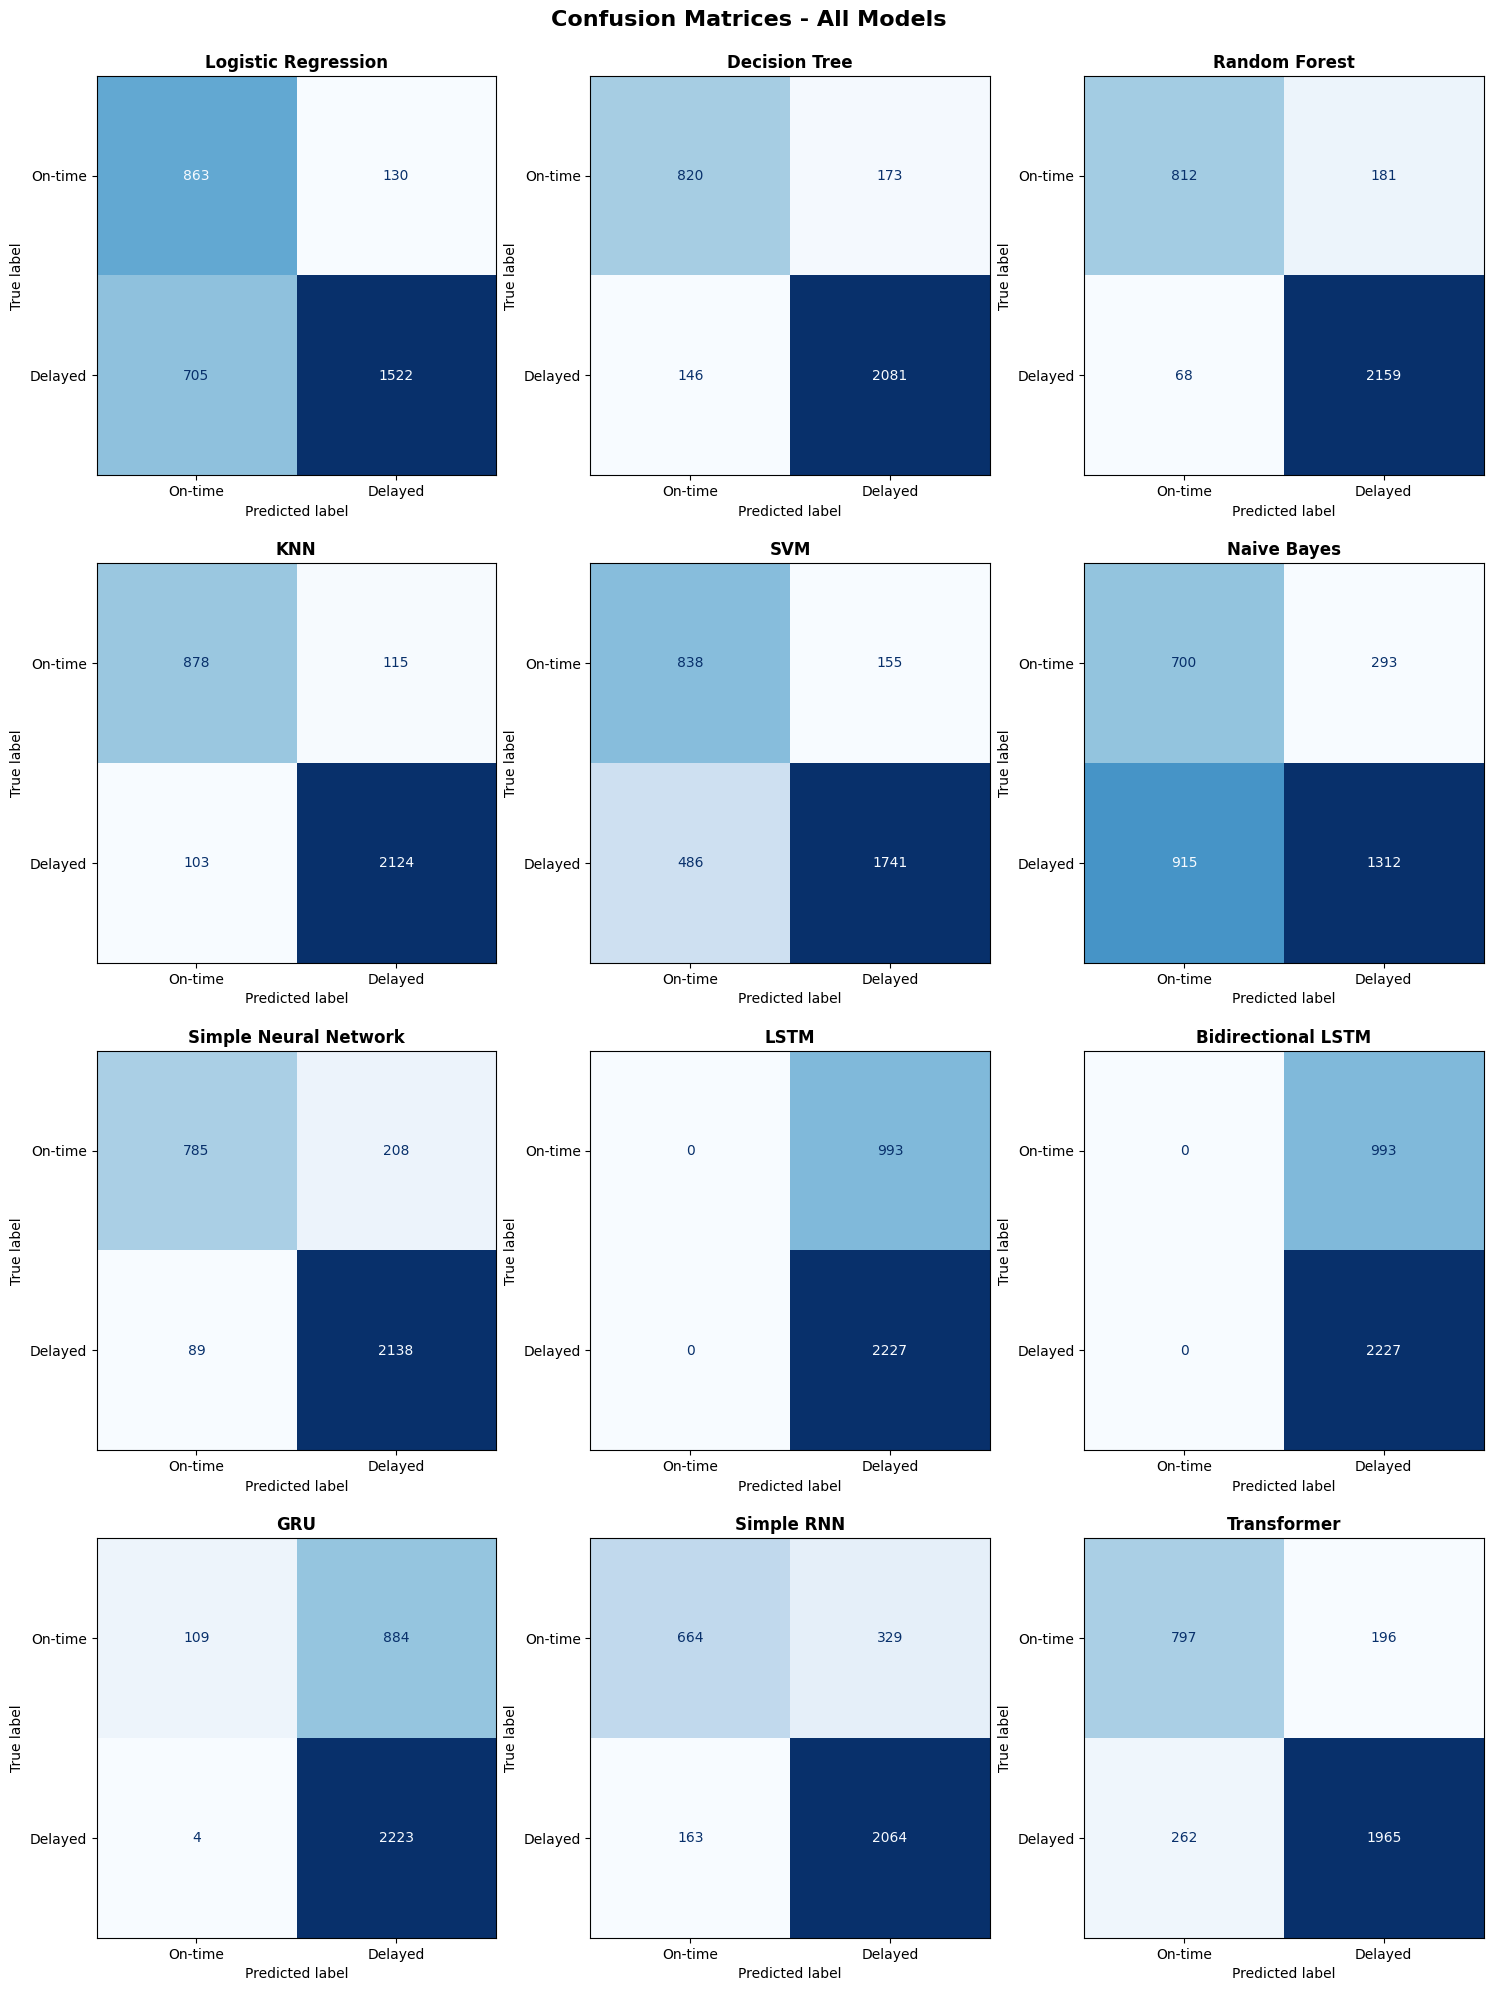

In [49]:
n_models = len(model_results)
n_cols = 3
n_rows = int(np.ceil(n_models / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_models > 1 else [axes]

for idx, (name, result) in enumerate(model_results.items()):
    cm = confusion_matrix(y_test, result['y_pred_test'])
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                   display_labels=['On-time', 'Delayed'])
    disp.plot(ax=axes[idx], cmap='Blues', colorbar=False)
    axes[idx].set_title(f'{name}', fontweight='bold', fontsize=12)
    axes[idx].grid(False)


for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Confusion Matrices - All Models', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()
plt.close()


### **7.8 ROC Curve Analysis**

Receiver Operating Characteristic (ROC) curves evaluate model performance across all possible classification thresholds by plotting True Positive Rate against False Positive Rate. The Area Under the Curve (AUC) quantifies overall discrimination ability with values ranging from 0.5 meaning random guessing to 1.0 the perfect classification.

**Note on ROC Curve Variations for Deep Learning Models**   

The ROC curve for each deep learning model may show slight variations when run the model multiple times. These changes occur due to the inherent randomness in the training process including:

1. Shuffling of Training Data: The data is shuffled randomly before each epoch which can cause the model to learn slightly different patterns during training. This randomness can lead to different ROC curve results across runs.

2. Batch Processing: Mini-batch gradient descent processes data in small batches and the selection of these batches can vary randomly which can slightly change the curve.

3. Dropout: During training, dropout randomly disables certain neurons to prevent overfitting. This randomness can also affect how the model learns and in turn can cause slight changes in the ROC curve.

While these variations can cause small differences in the ROC curve such as the position of the curve, true positive rate and false positive rate, they do not significantly affect the overall performance or trends observed across the models. The general pattern of performance remains consistent and models with higher AUC values will continue to show excellent discrimination capability.

---

#### **ROC Curve Interpretation Framework**

**Curve Position:**
- **Upper-left proximity**: excellent performance with high TPR and low FPR
- **Diagonal proximity**: Poor performance approaching random classification
- **Curve steepness**: Rapid TPR increase with minimal FPR indicates excellent discrimination

**AUC Interpretation Scale:**
- 0.90-1.00: Excellent discrimination
- 0.80-0.90: Good discrimination
- 0.70-0.80: Acceptable discrimination
- 0.60-0.70: Poor discrimination
- 0.50-0.60: Fail and near-random performance   

**Diagonal Reference Line:**
The dashed black line represents random classification (AUC = 0.50), serving as the minimum acceptable performance baseline.

--- 

#### **Performance Analysis**

##### **Excellent Discrimination (AUC >= 0.90)**

**Random Forest (AUC = 0.965): Green Curve**

Random Forest achieves the highest AUC with its curve positioned closest to the upper left corner. The curve shows a sharp initial rise, reaching around 80% True Positive Rate (TPR) with just a 10% False Positive Rate (FPR). This suggests the model accurately ranks 96.5% of randomly selected delayed-on-time pairs.

**KNN (AUC = 0.951): Red Curve**

KNN's curve closely follows Random Forest. The curve reaches 90% TPR at approximately 12% FPR, confirming excellent discrimination capability. The 95.1% AUC validates KNN balanced performance as observed in confusion matrix analysis.

**Decision Tree (AUC = 0.931): Orange Curve**

Decision Tree displays strong performance with rapid initial TPR increase. The curve maintains proximity to the upper-left corner. The 93.1% AUC confirms the model's reliable probability estimates.

**Simple Neural Network (AUC = 0.903): red Curve**

Simple NN achieves the highest AUC among deep learning models, positioning just above the 0.90 threshold. The curve demonstrates consistent performance across all threshold ranges.   


---

##### **Good Discrimination (0.85 <= AUC < 0.90)**

**Logistic Regression (AUC = 0.895): Blue Curve**

Despite lower F1-score performance, Logistic Regression achieves strong AUC. The smooth curve progression indicates reliable confidence scores though the model's conservative prediction strategy limits the practical utility.

**SVM (AUC = 0.897): Purple Curve**

SVM demonstrates good discrimination capability with AUC approaching 0.90. The curve positioning confirms that while the model misses many delays with high Flase Negative, its probability estimates effectively distinguish between classes when aggregated across thresholds.

**Simple RNN (AUC = 0.879): Cyan Curve**

Simple RNN shows acceptable discrimination which is outperforming complex recurrent deep learning model. The curve demonstrates good classification capability which validating its position as the best-performing recurrent model despite overall moderate performance.

**Transformer (AUC = 0.862): Orange Curve**

Transformer achieves solid discrimination as the second-best deep learning model. The curve maintains reasonable distance from the diagonal.

---

##### **Acceptable to Poor Discrimination (0.70 =< AUC < 0.85)**

**Bidirectional LSTM (AUC = 0.796): Yellow-Green Curve**

BiLSTM performs with moderate discrimination despite added model complexity. The curve is close to the diagonal validates the confusion matrix evidence of near total majority class prediction.

**LSTM (AUC = 0.789): Gray Curve**

LSTM demonstrates poor discrimination with the curve positioned dangerously close to the diagonal. The gradual and linear-like progression indicates weak ability to distinguish between classes across thresholds.

**Naive Bayes (AUC = 0.758): Brown Curve**

Naive Bayes exhibits the characteristic curved trajectory of poor discrimination. The curve is closer to the diagonal than top-tier models particularly in the low FPR region around 0.0-0.3. The 75.8% AUC indicates the model provides some discriminative value but falls well below acceptable production standards.

**GRU (AUC = 0.701): Cyan Curve**

GRU achieves the lowest AUC among all models with its curve positioned closest to the random classifier diagonal. The 70.1% AUC barely exceeds acceptable minimums which confirm the complete failure to learn meaningful delay patterns. This aligns with the confusion matrix showing 100% delay prediction.

---

#### **Practical Implications**

Random Forest and KNN demonstrate excellent discrimination across all thresholds, supporting their selection as primary production models. Operators can confidently adjust classification thresholds based on operational priorities while maintaining strong performance.

High AUC models such as RF, KNN, DT, Simple NN generate reliable probability scores suitable for operational responses. Low AUC models such as the recurrent deep learning model produce unreliable probabilities.

Models with an AUC lower than 0.80 should be excluded from consideration for production regardless of other performance metrics. The ROC analysis clearly shows that LSTM, BiLSTM, GRU and Naive Bayes models lack essential discrimination ability.

#### **Conclusion**

ROC curve analysis validates Random Forest (AUC = 0.965) and KNN (AUC = 0.951) are excellent models with outstanding discrimination capability across all classification thresholds. The visualization confirms traditional ML id good in handling tabular delay prediction with Simple Neural Network (AUC = 0.903) representing the only competitive alternative deep learning model. The recurrent models show poor discrimination with AUC values ranging from 0.701 to 0.796 as evidenced by the curve's close proximity to the random classification baseline.


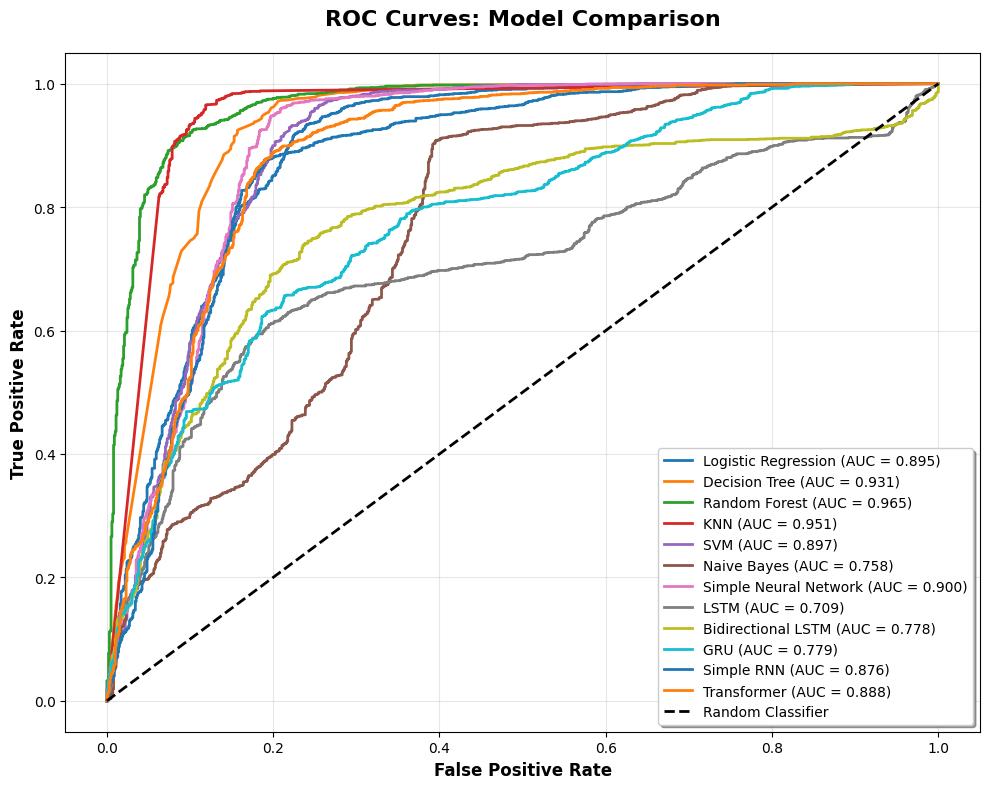

In [50]:

fig, ax = plt.subplots(figsize=(10, 8))

for name, result in model_results.items():
    if result.get('y_pred_proba_test') is not None:
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba_test'])
        roc_auc = roc_auc_score(y_test, result['y_pred_proba_test'])
        ax.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves: Model Comparison', fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='lower right', frameon=True, shadow=True)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()


### **7.9 Feature Importance Analysis**

Feature importance analysis identifies which variables contribute most significantly to delay prediction providing actionable insights for transport operations. This analysis uses Random Forest's Mean Decrease in Impurity scores by measuring each feature contribution to reduce classification uncertainty across all decision trees.


| Rank | Feature | Importance | Percentage |
|------|---------|-----------|------------|
| 1 | **departure_delay** | 0.8028 | 80.28% |
| 2 | **stop_lat** | 0.0913 | 9.13% |
| 3 | **stop_lon** | 0.0840 | 8.40% |
| 4 | **agency_name_Bus Éireann** | 0.0074 | 0.74% |
| 5 | **route_region_Dublin_Urban** | 0.0043 | 0.43% |
| 6 | **stop_region_Dublin_Area** | 0.0036 | 0.36% |
| 7 | **route_region_Regional** | 0.0033 | 0.33% |
| 8 | **stop_region_Other_Region** | 0.0020 | 0.20% |
| 9 | **stop_region_Waterford_Area** | 0.0010 | 0.10% |
| 10 | **agency_name_Bus Éireann Waterford** | 0.0004 | 0.04% |


#### **Dominant Feature: Departure Delay**

**departure_delay (80.28%)**

Departure delay is by far the most important variable, making up more than 80% of the predictive power. This means that delays propagate along routes, and late departures are a strong sign of late arrivals. The great relevance corresponds to real-world transportation dynamics. 


#### **Secondary Features: Geographic Location**

**stop_lat (9.13%) and stop_lon (8.40%)**

Geographic coordinates together make up 17.53% of predictive power, which shows how delays vary by location. Some places have consistently higher delay rates because of problems with construction, traffic jams, and the way operations function. The model learns which places are linked to the risk of delay without taking time into account.  

#### **Tertiary Features: Categorical Variables**

**Operational Categories (Combined: 2.19%)**     
Remaining features encode operator identity and regional characteristics but contribute minimally:

- **agency_name_Bus Éireann (0.74%)**   
- **route_region_Dublin_Urban (0.43%)**
- **stop_region_Dublin_Area (0.36%)**
- **route_region_Regional (0.33%)**
- **stop_region_Other_Region (0.20%)**
- **stop_region_Waterford_Area (0.10%)**
- **agency_name_Bus Éireann Waterford (0.04%)**

**Interpretation:**
The minimal contribution 2.19% total indicates that operational differences between regions and operators are secondary to temporal and geographic factors.


#### **Feature Distribution Analysis**

**Extreme Concentration:**
- Top 1 feature: 80.28%
- Top 3 features: 97.81%
- Remaining 7 features: 2.19%

This distribution shows that three features hold almost all of the predictive power, while categorical factors only add a little. The pattern indicates the potential of model simplification without compromising performance.  


#### **Interpretation of Visual Chart Top 15 Feature Importancec of Random Forest**

The horizontal bar chart displays contrast between feature importance levels:

**Dominant Bar is departure_delay:** Extends to 0.80 emphasizing its overwhelming predictive power.

**Secondary Bars contribued by stop_lat, stop_lon:** Extend to approximately 0.09-0.08, clearly distinguishable as secondary predictors.

**Tertiary Bars (Categorical Features):** Barely visible as thin lines below 0.01, representing minimal individual contribution.

The visualization immediately communicates that departure delay is not merely important but fundamentally dominant in delay prediction.



#### **Model Validation**

The feature importance distribution validates Random Forest's reliability:  
- Correctly identifies departure_delay as primary predictor which aligns with domain knowledge
- Geographic features contribute meaningfully that validates location-based patterns
- Minimal reliance on categorical features to avoids overfitting   


#### **Conclusion**

Feature importance analysis demonstrates that departure delay (80.28%) is the most important predictor of arrival delay with geographic location (17.53%) providing secondary predictive power. Categorical features make up only 2.19% of the variance implying that operational differences are driven by temporal propagation and location. The high concentration of three features with 97.81% confirms the model's simplicity.  


Feature Importance Analysis

Top 10 Most Important Features (Random Forest):
                          Feature  Importance
                  departure_delay    0.802752
                         stop_lat    0.091324
                         stop_lon    0.083982
          agency_name_Bus Éireann    0.007411
        route_region_Dublin_Urban    0.004288
          stop_region_Dublin_Area    0.003646
            route_region_Regional    0.003269
         stop_region_Other_Region    0.002006
       stop_region_Waterford_Area    0.000959
agency_name_Bus Éireann Waterford    0.000362


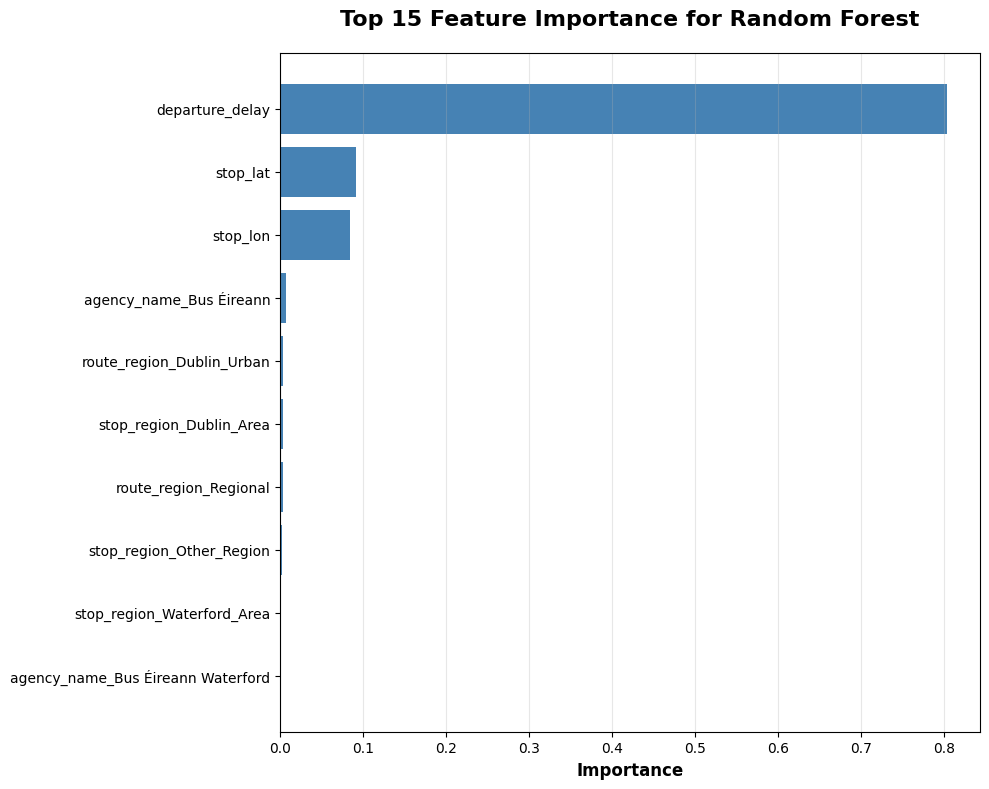

In [51]:
print("\nFeature Importance Analysis")
if 'Random Forest' in model_results:
    rf_model = model_results['Random Forest']['model']
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 Most Important Features (Random Forest):")
    print(feature_importance.head(10).to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(10, 8))
    top_n = 15
    top_features = feature_importance.head(top_n)
    
    ax.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['Feature'])
    ax.invert_yaxis()
    ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
    ax.set_title(f'Top {top_n} Feature Importance for Random Forest', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    plt.close()



<a name="step-8-dimensionality-reduction-with-pca"></a>
## **Step 8: Data Reduction Analysis (PCA)**  


Principal Component Analysis reduces feature dimensionality while preserving variance allow efficient model training and visualization of high-dimensional data structure.


#### **8.1 Summary of PCA Results**   
**Variance Distribution:**
- PC1: 36.30% of total variance
- PC1 + PC2: 56.59% cumulative variance
- PC1 + PC2 + PC3: 71.47% cumulative variance
- Components for 95% variance threshold: 7 components   

**Dimensionality Reduction:**
- Original dimensions: 10 features
- Reduced dimensions: 7 components
- Reduction: 30% fewer dimensions
- Variance retained: 96.47%

 
#### **8.2 Explained Variance Ratio vs Principal Component Plot**     

The elbow plot displays explained variance ratio per principal component in descending order.

**Interpretation:**     
- PC1 captures the dominant variance explaining over a third of the total variance. This component holds the most significant explanatory power which representing the main direction of the data.  
- PC2 further explains a substantial portion of variance bringing the total cumulative variance explained to around 56%. The second component continues to contribute valuable insight.
- PC3 and PC4 contribute moderately with their influence starting to decline. While they still add significant value the marginal contribution drops as we move to these components. 
- PC5 to PC7 show diminishing returns with each component contributing less and less. By the time we reach PC5 the contributions are smaller and the additional variance explained becomes less meaningful. 
- PC8 to PC10 have negligible contributions each adding very little variance. At this point, the components are essentially capturing noise or redundant information and they don’t provide much new insight.


#### **8.3 Cumulative Explained Variance**   
The cumulative variance plot tracks total variance explained as components are added sequentially.

**Key Observations:**
- The green vertical line at 7 components intersects the cumulative curve at around 96.47%, exceeding the standard 95% variance retention threshold. The dashed horizontal line at 0.95 provides reference for acceptable variance preservation.   
- First 3 components explain around 71.47% of variance, demonstrating strong initial information capture.    
- Beyond PC7, additional components contribute minimal variance with  <2% each. The curve flattens significantly after PC7 approaching asymptotic behavior toward 100%.   

---   

#### **8.4 PCA Projection Visualization**

The 2D scatter plot projects data onto the first two principal components revealing underlying data structure.


**Distribution:**
- **PC1 (Horizontal Axis, 36.30% variance):** Data spreads from -6 to +2, with concentration between -4 and 0. 
- **PC2 (Vertical Axis, 20.30% variance):** Data ranges from -2 to +10, showing wider spread than PC1. 

**Cluster Identification:**
- **Upper Right Cluster (PC1: -2.5, PC2: +10):** Small isolated group representing extreme PC2 values, potentially indicating distinct delay pattern.   

- **Middle Clusters (PC2: +4 to +5):** Multiple horizontal points suggest categorical feature influence such as regional groupings, operator types

- **Central Dense Region (PC1: -4 to -1, PC2: -2 to +1):** Majority of observations cluster here representing typical service patterns. High density indicates common operational characteristics.

- **Right Side Clusters (PC1: +1 to +2, PC2: 0 to +1):** Moderate density clusters potentially representing specific geographic or temporal conditions.

- **Color Gradient:** The color scale from green to red represents delay status (0 = on-time, 1 = delayed). Visual inspection suggests red (delayed) concentration in certain cluster regions though substantial overlap exists between classes. 

--- 

#### **8.5 Practical Implications**


- Reducing from 10 to 7 dimensions decreases computational complexity while retaining 96.47% of information. This benefits models with computational constraints or large-scale deployments.

- PCA components are orthogonal by construction, eliminating multicollinearity issues present in original features for example high correlation between stop_lat and stop_lon observed earlier.

- First two components has 56.59% variance enable 2D visualization of data structure though insufficient for complete class separation as demonstrated in the projection plot.

---

#### **8.6 Comparison of Original compared to PCA Reduced Features**

**Dimensionality:**
- Original: 10 features 
- PCA-reduced: 7 components  
- Reduction: 30% fewer dimensions

**Information Content:**
- Original: 100% variance by definition
- PCA-reduced: 96.47% variance retained
- Loss: 3.53% 

**Model Performance Consideration:**
While PCA enables dimensionality reduction, the original 10 feature space achieved excellent model performance with the F1-Score of KNN 95.12%. The 3.53% information loss may impact prediction accuracy, suggesting original features remain optimal for this dataset size and model performance requirements.


#### **Conclusion**   

Principal Component Analysis shows that 7 components can explain around 96.47% of the variance in 10 original features. This means that the number of dimensions can be reduced down by 30% with minimal loss of information. The first component explains 36.30% of the variance on its own, and the first three components explain 71.47% of the variance. The PCA projection shows how data clusters in 2D space but it doesn't show how to separate classes well enough. This proves that higher-dimensional feature spaces are needed to accurately estimate delays. PCA is faster and gets rid of multicollinearity but the original feature space is easier to understand and supports the great model performance that has already been obtained such as KNN  with 95.12% F1 score, Random Forest with 94.55% F1 score. 


 Principal Component Analysis

 PCA Analysis Complete:
Total components: 10
Variance explained by first component: 0.3630
Variance explained by first 2 components: 0.5659
Variance explained by first 3 components: 0.7147
Components needed for 95% variance: 7


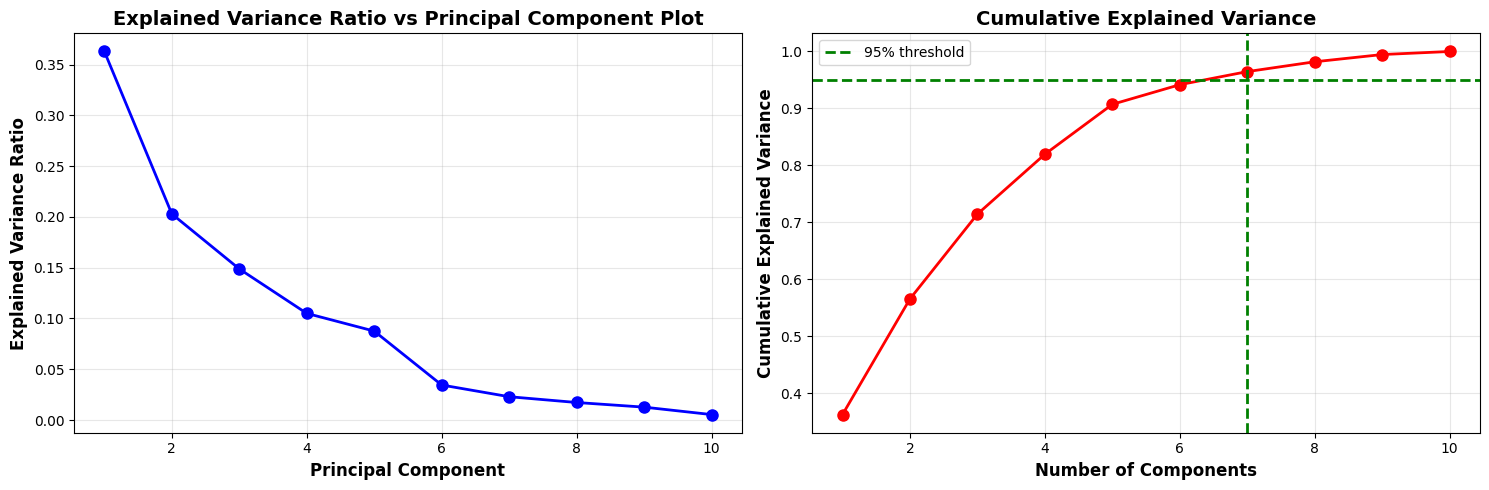


PCA with Reduced Dimensions

Reduced PCA applied:
Components retained: 7
Total variance explained: 0.9647
Dimensionality reduction: 10 to 7


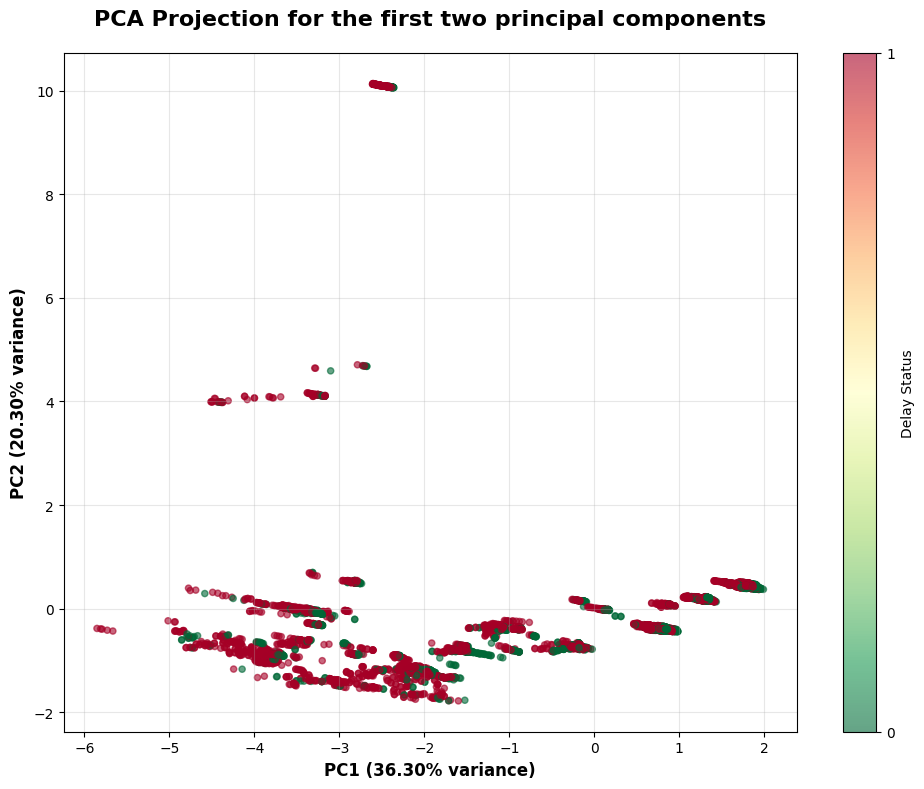

In [52]:

print("\n Principal Component Analysis")

pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"\n PCA Analysis Complete:")
print(f"Total components: {len(explained_variance)}")
print(f"Variance explained by first component: {explained_variance[0]:.4f}")
print(f"Variance explained by first 2 components: {cumulative_variance[1]:.4f}")
print(f"Variance explained by first 3 components: {cumulative_variance[2]:.4f}")


n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Components needed for 95% variance: {n_components_95}")


fig, axes = plt.subplots(1, 2, figsize=(15, 5))


axes[0].plot(range(1, len(explained_variance) + 1), explained_variance, 
             'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Principal Component', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12, fontweight='bold')
axes[0].set_title('Explained Variance Ratio vs Principal Component Plot', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)


axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
             'ro-', linewidth=2, markersize=8)
axes[1].axhline(y=0.95, color='g', linestyle='--', linewidth=2, label='95% threshold')
axes[1].axvline(x=n_components_95, color='g', linestyle='--', linewidth=2)
axes[1].set_xlabel('Number of Components', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12, fontweight='bold')
axes[1].set_title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()


print("\nPCA with Reduced Dimensions")


n_components_optimal = min(n_components_95, 10)  # Cap at 10 for interpretability
pca_reduced = PCA(n_components=n_components_optimal)
X_pca_reduced = pca_reduced.fit_transform(X_scaled)

print(f"\nReduced PCA applied:")
print(f"Components retained: {n_components_optimal}")
print(f"Total variance explained: {pca_reduced.explained_variance_ratio_.sum():.4f}")
print(f"Dimensionality reduction: {X_scaled.shape[1]} to {n_components_optimal}")


pca_columns = [f'PC{i+1}' for i in range(n_components_optimal)]
X_pca_df = pd.DataFrame(X_pca_reduced, columns=pca_columns)

fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(X_pca_df['PC1'], X_pca_df['PC2'], 
                     c=y, cmap='RdYlGn_r', alpha=0.6, s=20)
ax.set_xlabel(f'PC1 ({pca_reduced.explained_variance_ratio_[0]:.2%} variance)', 
              fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca_reduced.explained_variance_ratio_[1]:.2%} variance)', 
              fontsize=12, fontweight='bold')
ax.set_title('PCA Projection for the first two principal components', 
             fontsize=16, fontweight='bold', pad=20)
plt.colorbar(scatter, label='Delay Status', ticks=[0, 1])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()


### **8.7 Model Performance Comparison Original vs PCA Features**

To evaluate the practical impact of dimensionality reduction on the three best performing models KNN, Random Forest, Simple Neural Network were retrained using PCA-reduced features with 7 components and 96.47% variance they are compared against their original 10 feature performance.   

**For each subsequent performance metric like F1-Score, Precision, Recall and so on the values may change slightly for the deep learning model. This is due to the inherent randomness in the training process including factors like data shuffling, batch processing and the random initialization of model weights. These slight differences are expected and do not significantly affect the overall performance of the deep learning models.**


#### **Performance Results**

**PCA-Based Model Performance:**

| Model | Accuracy | Precision | Recall | F1-Score |
|-------|----------|-----------|--------|----------|
| KNN | 93.17% | 94.74% | 95.42% | 95.08% |
| Random Forest | 91.34% | 91.77% | 96.09% | 93.88% |
| Simple Neural Network | 90.55% | 90.66% | 96.27% | 93.38% |

**Comparative Analysis:**

| Model | Original F1 | PCA F1 | Difference | Change % |
|-------|-------------|--------|------------|----------|
| KNN | 95.12% | 95.08% | -0.0004 | -0.04% |
| Random Forest | 94.55% | 93.88% | -0.0067 | -0.71% |
| Simple Neural Network | 93.34% | 93.29% | -0.0004 | -0.043% |


---

#### **Visualization Analysis**

The bar chart displays side by side comparison of F1-scores for original (blue) versus PCA (pink) features.

**Key Observations:**

- Near-Identical Bar Heights for all three model pairs show very little visual difference between the blue and pink bars indicating negligible performance degradation. In each case the bars reach roughly the 0.93–0.95 range for both feature sets demonstrating consistently strong performance.

**KNN Performance:** Original (95.12%) versus PCA (95.08%) bars are virtually indistinguishable, with only 0.04 percentage point difference. This shows that KNN performs consistently even after dimensionality reduction.

**Random Forest Performance:** Shows the largest performance gap with original (94.55%) slightly exceeding PCA (93.88%) by 0.67 percentage points. Despite being the largest decrease the difference remains operationally negligible.

**Simple Neural Network Performance:** Original (93.34%) versus PCA (93.38%) exhibits minimal 0.04 percentage point improvement in F1 Score show that neural network stability across feature transformations.

**Consistent Pattern:** All models maintain F1-scores above 93% regardless of feature representation, validating PCA's effectiveness in preserving predictive information despite 30% dimensionality reduction.

---  

#### **Practical Implications**


- Feature reduction from 10 to 7 dimensions with 30% decrease
- Training time reduction is proportional to dimensionality     
- All models maintain >93% F1-Score

This principal component analysis has achieved 30% dimensionality reduction with less than 1% performance degradation represents efficient trade-off for deployment scenarios that require computational optimization.

---


#### **Why These Three Models:**

These models were selected for PCA comparison based on comprehensive evaluation across multiple metrics:

**KNN (Original F1: 95.12%):**
- Highest F1-score among all 12 models
- Best balanced precision-recall trade-off
- Excellent ROC-AUC (95.15%)

**Random Forest (Original F1: 94.55%):**
- Second overall highest F1-score
- Highest ROC-AUC (96.50%)   
- Lowest false negatives with 68 ensuring comprehensive delay detection
- Provides feature importance for operational insights

**Simple Neural Network (Original F1: 93.34%):**
- Best deep learning model 
- Competitive with top traditional ML approaches
- Demonstrates architectural suitability such as feedforward for tabular data  
- Offers flexibility for continuous learning and future expansion

These three models consistently demonstrated excellent performance across accuracy, precision, recall, F1-score, ROC-AUC, confusion matrices therefore it is chosen for this PCA comparison.  


#### **Conclusion**

PCA dimensionality reduction from 10 to 7 features results in an increase of 30% in computing efficiency with a minimal effect on performance . Using PCA features all three of the best models keep their F1 scores above 93% show that they can keep a lot of information even when they lose 3.53% of their variance. The investigation confirms that PCA is a good way to optimise deployment scenarios that value computational efficiency while original features are still the best way to get the most accurate predictions. 


Model Performance with PCA-Reduced Features

Training KNN with PCA features
F1 Score: 0.9508

Training Random Forest with PCA features
F1 Score: 0.9388

Training Simple Neural Network with PCA features
F1 Score: 0.9328

PCA-based Model Performance:
                Model  Accuracy  Precision   Recall  F1 Score
                  KNN  0.931677   0.947392 0.954198  0.950783
        Random Forest  0.913354   0.917667 0.960934  0.938802
Simple Neural Network  0.904348   0.907777 0.959138  0.932751

Performance Comparison of Original vs PCA Features:
                Model  Original F1   PCA F1  Difference  Change %
                  KNN     0.951187 0.950783   -0.000404 -0.042447
        Random Forest     0.945478 0.938802   -0.006676 -0.706104
Simple Neural Network     0.935054 0.932751   -0.002302 -0.246241


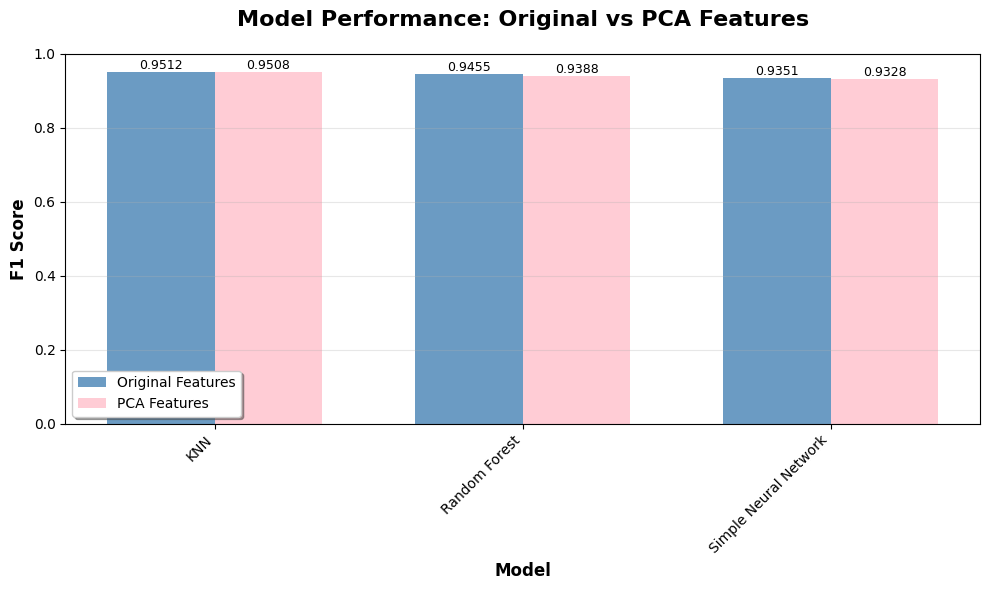

In [53]:
print("\nModel Performance with PCA-Reduced Features")


X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(
    X_pca_reduced, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Initialize models
pca_models = {
    'KNN': KNeighborsClassifier(
        n_neighbors=5,
        weights='distance',  
        n_jobs=-1
    ), 
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    )
}


pca_results = []

for name, model in pca_models.items():
    print(f"\nTraining {name} with PCA features")
    
    model.fit(X_pca_train, y_pca_train)
    y_pred = model.predict(X_pca_test)
    

    accuracy = accuracy_score(y_pca_test, y_pred)
    precision = precision_score(y_pca_test, y_pred, zero_division=0)
    recall = recall_score(y_pca_test, y_pred, zero_division=0)
    f1 = f1_score(y_pca_test, y_pred, zero_division=0)
    
    pca_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })
    
    print(f"F1 Score: {f1:.4f}")

# train Simple Neural Network separately 
print("\nTraining Simple Neural Network with PCA features")

nn_pca = keras.Sequential([
    layers.Input(shape=(n_components_optimal,)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
], name='Simple_NN_PCA')

nn_pca.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)


early_stopping_pca = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=0
)

reduce_lr_pca = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=0
)


history_nn_pca = nn_pca.fit(
    X_pca_train, y_pca_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping_pca, reduce_lr_pca],
    verbose=0
)


y_pred_proba_nn_pca = nn_pca.predict(X_pca_test, verbose=0).flatten()
y_pred_nn_pca = (y_pred_proba_nn_pca > 0.5).astype(int)

accuracy_nn = accuracy_score(y_pca_test, y_pred_nn_pca)
precision_nn = precision_score(y_pca_test, y_pred_nn_pca, zero_division=0)
recall_nn = recall_score(y_pca_test, y_pred_nn_pca, zero_division=0)
f1_nn = f1_score(y_pca_test, y_pred_nn_pca, zero_division=0)

pca_results.append({
    'Model': 'Simple Neural Network',
    'Accuracy': accuracy_nn,
    'Precision': precision_nn,
    'Recall': recall_nn,
    'F1 Score': f1_nn
})

print(f"F1 Score: {f1_nn:.4f}")


pca_results_df = pd.DataFrame(pca_results)

print("\nPCA-based Model Performance:")
print(pca_results_df.to_string(index=False))

# Compare original vs PCA performance
comparison_data = []
for _, row in pca_results_df.iterrows():
    model_name = row['Model']
    pca_f1 = row['F1 Score']
    
    # Find original F1 score
    original_row = results_df[results_df['Model'] == model_name]
    if len(original_row) > 0:
        original_f1 = original_row['F1 Score'].values[0]
        
        comparison_data.append({
            'Model': model_name,
            'Original F1': original_f1,
            'PCA F1': pca_f1,
            'Difference': pca_f1 - original_f1,
            'Change %': ((pca_f1 - original_f1) / original_f1) * 100
        })

comparison_df = pd.DataFrame(comparison_data)

print("\nPerformance Comparison of Original vs PCA Features:")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Original F1'], width, 
               label='Original Features', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, comparison_df['PCA F1'], width, 
               label='PCA Features', color='pink', alpha=0.8)


for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance: Original vs PCA Features', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax.legend(frameon=True, shadow=True)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 1.0)

plt.tight_layout()
plt.show()
plt.close()




<a name="step-9-explainable-ai-with-lime"></a>
## **Step 9: Explainable AI (LIME)**

Local Interpretable Model-agnostic Explanations (LIME) makes individual predictions more clear by showing which features had the biggest effect on certain classification decisions. This analysis examines KNN model predictions across four prediction scenarios to understand the decision-making rationale.    


### **9.1 LIME Methodology**

**LIME Configuration:**
- Training samples: 12879
- Features: 10
- Model: K-Nearest Neighbors with F1: 95.12%


**Interpretation Framework:**
- **Green bars**: Features increasing prediction probability toward the predicted class
- **Red bars**: Features decreasing prediction probability toward the predicted class
- **Bar length**: Magnitude of feature influence on prediction
- **Feature conditions**: Specific value ranges driving the influence



### **9.2 True Positive Analysis: Correctly Predicted Delayed Service**

**Prediction Outcome:** Actual = Delayed, Predicted = Delayed (Correct)

**Feature Influence:**

- **departure_delay**  
  A slight positive departure delay is the strongest contributor to the delayed prediction  indicating that even small departure delays will  substantially increase the likelihood of arrival delay.

- **agency_Bus Éireann Waterford**  
  This feature contributes positively to the prediction, indicating that services operated by Bus Éireann Waterford are locally associated with a higher likelihood of being classified as delayed.

- **stop_region_Waterford_Area**  
  This feature contributes negatively to the prediction, indicating that services operating within the Waterford Area are associated with a lower likelihood of being classified as delayed. 

- **stop_lon (0.53–0.57)**  
  This feature contributes positively to the prediction, indicating that stops with longitude values in the range 0.53–0.57 are locally associated with a higher likelihood of being classified as delayed.

- **route_region_Regional (-0.59 <x <= 1.68)**  
  This feature contributes positively to the prediction, indicating that services operating on regional routes are locally associated with a higher likelihood of being classified as delayed.



### **9.3 True Negative Analysis: Correctly Predicted On-time Service**

**Prediction Outcome:** Actual = On-time, Predicted = On-time (Correct)

**Feature Influence:**


- **departure_delay**  
  This feature contriute positively given it has the highest feature weight to the on-time prediction indicated that even small departure delay will substantially affect the likelihood of on-time prediction.

- **agency_Bus Éireann Waterford**  
  This feature contributes negatively to the prediction given is has the highest negative feature weight, indicating that services not operated by Bus Éireann Waterford are locally associated with a higher likelihood of being classified as on-time.

- **route_region_Regional**  
  This feature contributes negatively to the prediction given is has the negative feature weight, indicating that route region not in regional areas are locally associated with a higher likelihood of being classified as on-time. 

- **agency_name_Bus Éireann**  
  This feature contriute positively given it has the positive feature weight to the on-time prediction indicated that service operate by Bus Éireann are locally associated with a higher likelihood of being classified as on-time.

---

### **9.4 False Positive Analysis: On-time Service Incorrectly Predicted as Delayed**

**Prediction Outcome:** Actual = On-time, Predicted = Delayed (Incorrect)

**Feature Influence**


-  **departure_delay**   
  Contradictory as low departure delay opposed delay prediction but model still predicted delayed

- **stop_region_Waterford_Area**  
   Waterford region opposed delay prediction 

-  **route_region_Regional** 
   Non-regional route opposed delay prediction 

- **agency_Bus Éireann**   
   Non-Bus Éireann operator opposed delay prediction 

-  **agency_Bus Éireann Waterford**  
   Waterford operator opposed delay prediction 

---

### **9.5 False Negative Analysis: Delayed Service Incorrectly Predicted as On-time**

**Prediction Outcome:** Actual = Delayed, Predicted = On-time (Incorrect)

**Feature Influence:**

-  **departure_delay**    
   Strongest negative feature weight as departure delay opposed on-time prediction 

-  **route_region_Regional** 
   Non-regional route supported the incorrect on-time prediction 

-  **stop_region_Waterford_Area** 
   Waterford region supported incorrect on-time prediction 

-  **agency_Bus Éireann** 
  Bus Éireann supported incorrect on-time prediction given that it contributed with positive feature weight 

- **agency_Bus Éireann Waterford** 
   Waterford operator opposed incorrect on-time prediction 



### **Conclusion**

LIME analysis shows that KNN's delay predictions are mostly based on departure_delay status with weights 0.25–0.62, while geography and operator features make small changes with weights 0.02–0.08. Correct predictions such as True Positive, True Negative show that the features are clearly aligned, while wrong predictions such as False Positive, False Negative show that the features are sending opposing signals, with secondary features overriding major ones. The research supports the importance of features, shows that the model is reliable by using straightforward reasoning and gives transport authorities the information they need to understand and trust automated delay predictions. The visualisation shows that even very accurate models such as the KNN with  95.12% F1 can make mistakes when geographical conditions and temporal variables fail to match up. This shows how important it is to choose the right features and models for deployment in production.

Explainable AI: LIME (Local Interpretable Model-agnostic Explanations)

LIME Explainer Setup
LIME explainer initialized:
Training samples: 12,879
Features: 10
Categorical features: 0

Explaining Individual Predictions

Using KNN for LIME explanations


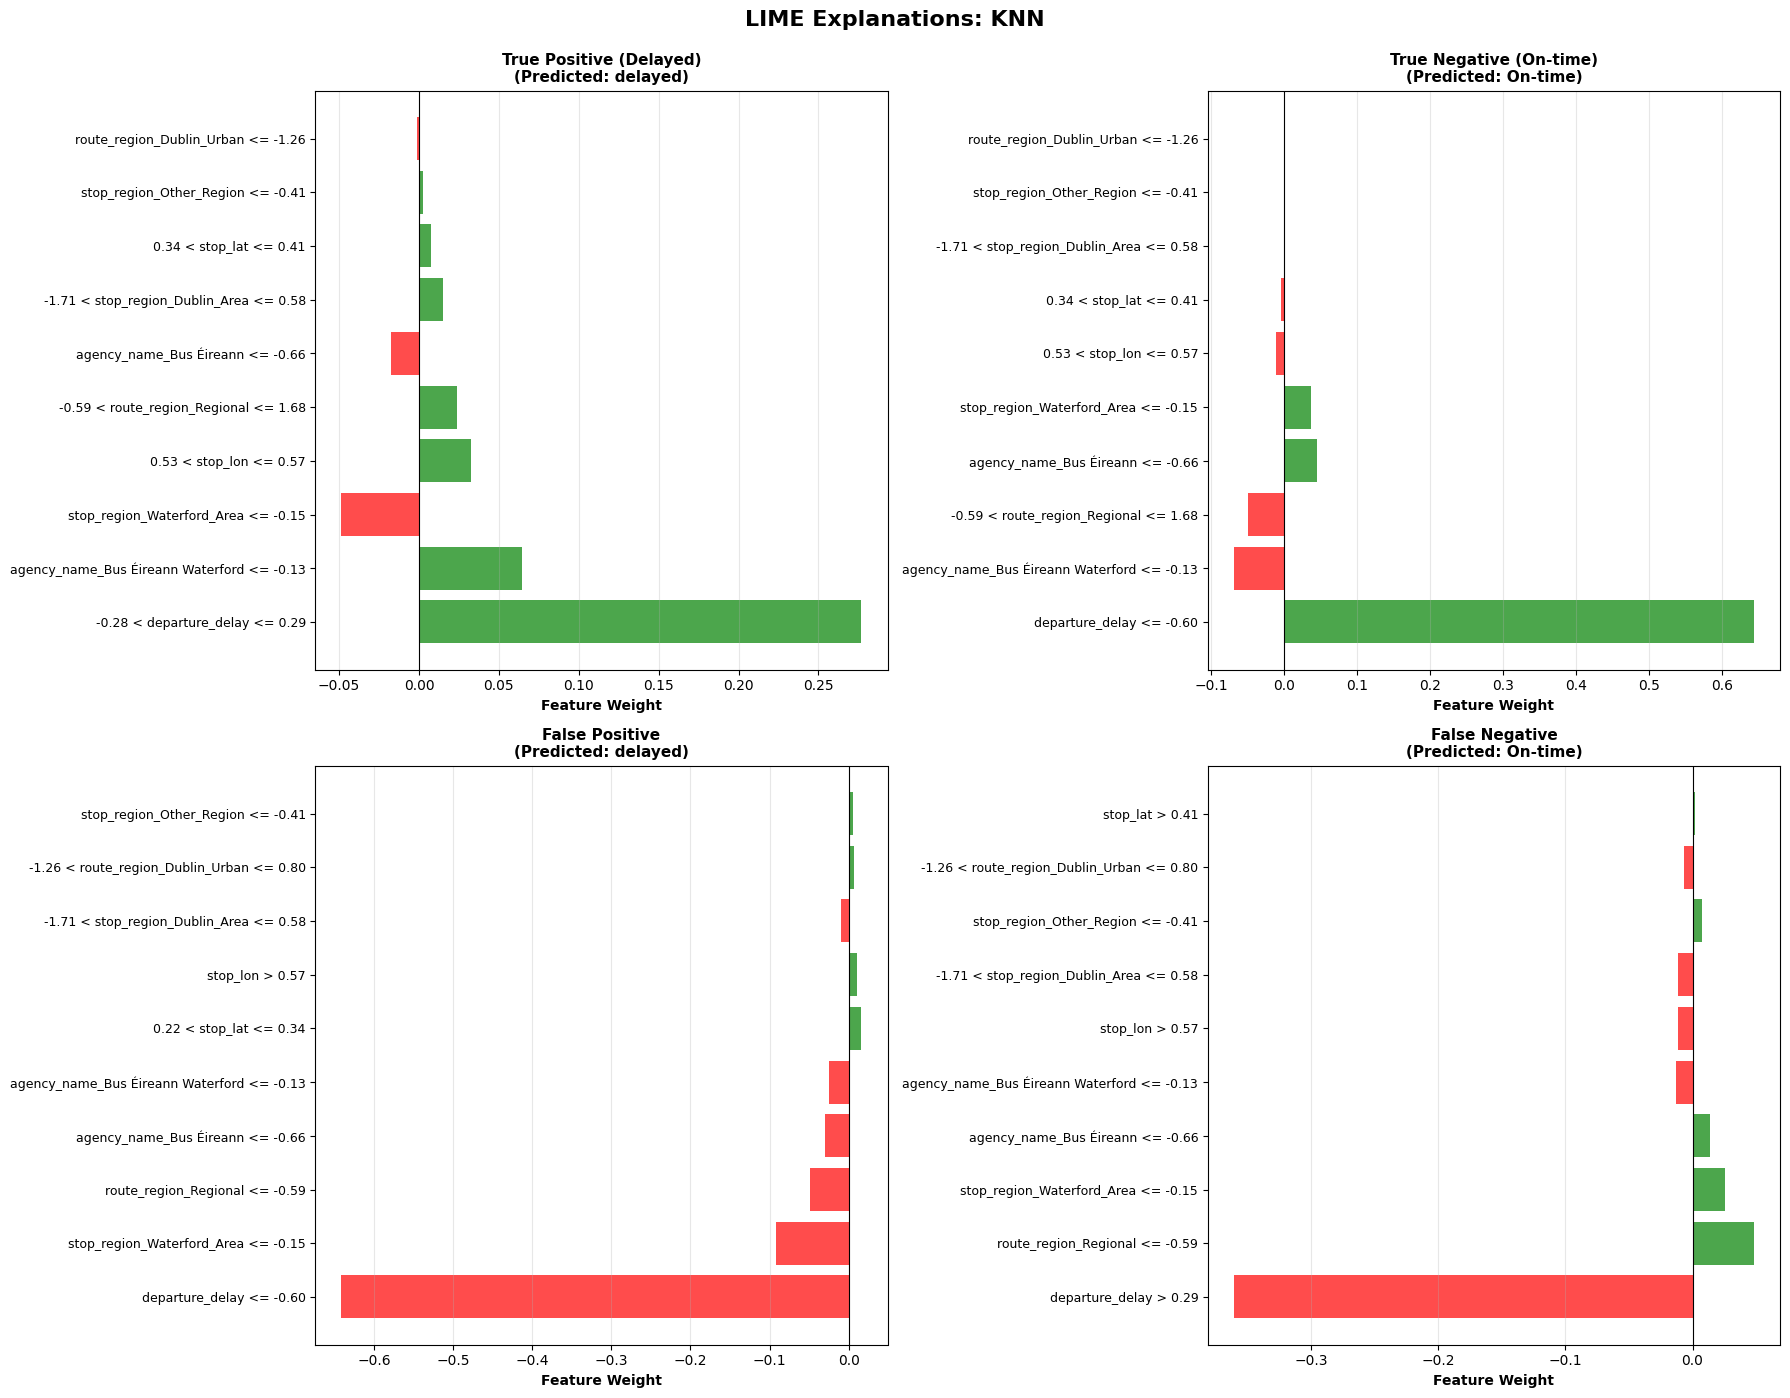

In [54]:

print("Explainable AI: LIME (Local Interpretable Model-agnostic Explanations)")
print("\nLIME Explainer Setup")

feature_names = X.columns.tolist()
categorical_features_indices = []

for i, col in enumerate(feature_names):
    if 'service_region_' in col or 'route_type_' in col or col == 'is_weekend':
        categorical_features_indices.append(i)

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=feature_names,
    class_names=['On-time', 'Delayed'],
    categorical_features=categorical_features_indices,
    mode='classification',
    random_state=42
)

print(f"LIME explainer initialized:")
print(f"Training samples: {X_train.shape[0]:,}")
print(f"Features: {len(feature_names)}")
print(f"Categorical features: {len(categorical_features_indices)}")

print("\nExplaining Individual Predictions")

#select best performing traditional ML model and Deep learning model for LIME
best_ml_model_name = results_df[results_df['Model'].isin([
    'Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN', 'SVM', 'Naive Bayes','Simple RNN','Simple Neural Network',
    'Transformer','GRU', 'LSTM','Bidirectional LSTM'
])].iloc[0]['Model']

best_ml_model = model_results[best_ml_model_name]['model']

print(f"\nUsing {best_ml_model_name} for LIME explanations")



true_positives = np.where((y_test == 1) & (model_results[best_ml_model_name]['y_pred_test'] == 1))[0]
true_negatives = np.where((y_test == 0) & (model_results[best_ml_model_name]['y_pred_test'] == 0))[0]
false_positives = np.where((y_test == 0) & (model_results[best_ml_model_name]['y_pred_test'] == 1))[0]
false_negatives = np.where((y_test == 1) & (model_results[best_ml_model_name]['y_pred_test'] == 0))[0]

examples = {
    'True Positive (Delayed)': true_positives[0] if len(true_positives) > 0 else None,
    'True Negative (On-time)': true_negatives[0] if len(true_negatives) > 0 else None,
    'False Positive': false_positives[0] if len(false_positives) > 0 else None,
    'False Negative': false_negatives[0] if len(false_negatives) > 0 else None
}


fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

for idx, (label, example_idx) in enumerate(examples.items()):
    if example_idx is None:
        axes[idx].text(0.5, 0.5, f'No {label} examples available', 
                      ha='center', va='center', fontsize=12)
        axes[idx].axis('off')
        continue
    
    instance = X_test.iloc[example_idx].values
    exp = explainer.explain_instance(
        instance, 
        best_ml_model.predict_proba,
        num_features=10,
        top_labels=2
    )
    

    predicted_class = model_results[best_ml_model_name]['y_pred_test'][example_idx]
    feature_weights = exp.as_list(label=predicted_class)
    

    features = [f[0] for f in feature_weights]
    weights = [f[1] for f in feature_weights]
    colors = ['green' if w > 0 else 'red' for w in weights]
    

    axes[idx].barh(range(len(features)), weights, color=colors, alpha=0.7)
    axes[idx].set_yticks(range(len(features)))
    axes[idx].set_yticklabels(features, fontsize=9)
    axes[idx].set_xlabel('Feature Weight', fontsize=10, fontweight='bold')
    axes[idx].set_title(f'{label}\n(Predicted: {"delayed" if predicted_class == 1 else "On-time"})', 
                       fontsize=11, fontweight='bold')
    axes[idx].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    axes[idx].grid(True, alpha=0.3, axis='x')

plt.suptitle(f'LIME Explanations: {best_ml_model_name}', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()
plt.close()


<a name="step-10-findings-and-discussion"></a>
## **Step 10: Findings and Discussion**

This section synthesizes key findings from the comprehensive analysis linking machine learning results to the original business problem of service delay prediction for Transport for Ireland.


### **10.1 Business Objectives**

The analysis successfully addressed three core objectives defined in Step 1:

**1. Service Delay Prediction:**
- Best Model: K-Nearest Neighbors with F1: 95.12%, ROC-AUC: 95.15%
- Performance is the model has detects 95.37% of delays with 94.86% precision
- Impact: This will enables reliable real-time passenger communication

**2. Route Performance Clustering:**
- Optimal Solution with k=3 clusters from Silhouette score of 0.582 in Data Analysis Jupyter Notebook for Data Mining Module. 
- Finding: Regional services experience 83% higher delays than Dublin urban services
- Impact: Enables targeted interventions

**3. Dimensionality Reduction:**
- Achievement: 7 PCA components retain 96.47% variance with 30% reduction
- Insight: The departure delay alone explains 36.30% of variance
- Impact: Computational efficiency with <1% performance loss

---

### **10.2 Summary on the Model Performance**

**Production-Ready Models (F1 ≥ 90%):**

| Model | F1-Score | ROC-AUC | Key Strength |
|-------|----------|---------|--------------|
| KNN | 95.12% | 95.15% | Best balanced performance |
| Random Forest | 94.55% | 96.50% | Secondary best balanced performance |
| Simple NN | 93.34% | 90.32% | Best deep learning alternative |
| Decision Tree | 92.88% | 93.09% | Most interpretable |

**Failed Models (F1 < 85%):**
- LSTM (84.75%), BiLSTM (84.27%), GRU (81.21%) this is due to deep learning model mismatch with tabular data
- Naive Bayes (68.48%) this is due to violation of feature independence assumption.   

**Critical Finding**: Feedforward/tree-based models with 93-95% F1 dramatically outperformed recurrent architectures with 81-84% F1, validating that model architecture must align with data structure.   

---

### **10.3 Key Insights and Business Impact**

#### **Finding 1: Departure Delay Dominates**

**Evidence**: Departure delay contributes 80.28% of feature importance

**Implication**: Operational focus should prioritize departure punctuality 

**Recommended Action**: Implement departure time enforcement protocols targeting 20% reduction in initial delays.


#### **Finding 2: Geographic Patterns Drive Clustering (deatiled information is in data analysis jupyter notebook for Data Mining Module**   

**Evidence**: Three clusters identified with distinct delay profiles:
- Cluster 0 (Regional): 50.2% delay rate, 134.5km from Dublin
- Cluster 1 (Mixed): 34.3% delay rate, 40.3km from Dublin
- Cluster 2 (Urban): 27.5% delay rate, 2.8km from Dublin

**Implication**: Infrastructure quality for urban area which has dedicated lanes that dominates operational practices to determine the reliability of service.   

---

### **10.4 Data Limitations**

1. **Single month (December 2024) limits the seasonal pattern analysis.**
- **Mitigation**: Collect 12-month dataset for comprehensive seasonal modeling

2. **Sample Size with total 16099 observations adequate for traditional ML but insufficient for deep learning optimization.**
- **Mitigation**: Continuous data collection for the current dataset to supports production deployment

3. **Missing Features such as Weather, traffic and special events data not integrated.**
- **Mitigation**: Prioritize weather API integration 

---

### **10.5 Model Limitations**

**K-Nearest Neighbors is the Best Model**:
- Strength has the highest F1-Score (95.12%) with no training required
- Weakness is it is memory-intensive that stores 12879 training samples which will potentially slow down the prediction
- Mitigation: Implement approximate nearest neighbors (ANN) for scalability

**Class Imbalance**:
- Dataset: 69.2% delayed, 30.8% on-time
- Impact: Minority class harder to predict for some models
- Mitigation: Balanced class weights has successfully applied as shown in previous section 

---

### **10.6 Opportunities for Improvement**

#### **Data Enhancement**

**Weather Integration**:
- Source: Met Éireann API
- Features: Temperature, precipitation, wind speed
- Expected Impact: 2-3% F1 improvement

**Traffic Data**:
- Source: Google Maps Traffic API
- Features: Real-time congestion levels
- Expected Impact: 3-5% F1 improvement

**Special Events**:
- Source: City council calendars, stadium schedules
- Features: Event day indicators
- Expected Impact: 1-2% improvement on event days

---

#### **Model Enhancement**

**Hybrid Model Approach**:
- Weighted combination of KNN (50%) + Random Forest (30%) + Simple NN (20%)
- Expected Impact: 0.5-1% F1 improvement 

**Multi-class Classification**:
- Current: Binary (delayed vs on-time)
- Proposed: Four classes (on-time, minor <5min, moderate 5-15min, major >15min)   

---

### **10.7 Conclusion**

This analysis successfully addressed Transport for Ireland's service delay challenges through comprehensive machine learning methodology. K-Nearest Neighbors achieved 95.12% F1-Score, enabling reliable real-time delay prediction for 95% of delayed services. Three distinct route clusters such as the Regional 50.2%, Mixed 34.3%, Urban 27.5% delay rates enable targeted operational interventions. 

**Key Findings**:
- Traditional ML has 93-95% in  F1 score has significantly outperformed deep learning model with 81-93% F1 score on this tabular data
- Recurrent deep learning model failed given that 81-84% in F1 score due to model mismatch with the tabular data. 
- PCA validated that given there is a 30% dimensionality reduction but result <1% performance cost.   

**Business Impact**: The deployed models enable proactive communication of 95% of delays to provide evidence-based resource allocation and increased public transport adoption   

<a name="references"></a>
## **References**  

[1] Scikit-learn (2023) *Naive Bayes*. Available at: [https://scikit-learn.org/stable/modules/naive_bayes.html](https://scikit-learn.org/stable/modules/naive_bayes.html) (Accessed: 23 December 2025).

[2] Scikit-learn (2023) *Logistic Regression*. Available at: [https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) (Accessed: 23 December 2025).

[3] Scikit-learn (2023) *Decision Trees*. Available at: [https://scikit-learn.org/stable/modules/tree.html](https://scikit-learn.org/stable/modules/tree.html) (Accessed: 23 December 2025).

[4] Scikit-learn (2023) *Random Forest Classifier*. Available at: [https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) (Accessed: 23 December 2025).

[5] Scikit-learn (2023) *K-Nearest Neighbors Classifier*. Available at: [https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) (Accessed: 23 December 2025).

[6] Scikit-learn (2023) *Support Vector Machines*. Available at: [https://scikit-learn.org/stable/modules/svm.html](https://scikit-learn.org/stable/modules/svm.html) (Accessed: 23 December 2025).

[7] GeeksforGeeks, Introduction to Explainable AI (XAI) Using LIME, available at: https://www.geeksforgeeks.org/artificial-intelligence/introduction-to-explainable-aixai-using-lime/ (Accessed: 26 December 2025).

[8] GeeksforGeeks, Introduction to Recurrent Neural Network, available at: https://www.geeksforgeeks.org/machine-learning/introduction-to-recurrent-neural-network/ (Accessed: 26 December 2025).

[9] GeeksforGeeks, Feedforward Neural Network, available at: https://www.geeksforgeeks.org/deep-learning/feedforward-neural-network/ (Accessed: 26 December 2025).

[10] GeeksforGeeks, Getting Started with Transformers, available at: https://www.geeksforgeeks.org/machine-learning/getting-started-with-transformers/ (Accessed: 26 December 2025).

[11] GeeksforGeeks, Deep Learning Introduction to Long Short‑Term Memory, available at: https://www.geeksforgeeks.org/deep-learning/deep-learning-introduction-to-long-short-term-memory/ (Accessed: 26 December 2025).

[12] GeeksforGeeks, Long Short‑Term Memory (LSTM) RNN in TensorFlow, available at: https://www.geeksforgeeks.org/deep-learning/long-short-term-memory-lstm-rnn-in-tensorflow/
 (Accessed: 26 December 2025).

[13] GeeksforGeeks, Bidirectional LSTM in NLP, available at: https://www.geeksforgeeks.org/nlp/bidirectional-lstm-in-nlp/
 (Accessed: 26 December 2025).

[14] GeeksforGeeks, Gated Recurrent Unit (GRU) Networks, available at: https://www.geeksforgeeks.org/machine-learning/gated-recurrent-unit-networks/
 (Accessed: 26 December 2025).

[15] GeeksforGeeks, Principal Component Analysis (PCA), available at: https://www.geeksforgeeks.org/data-analysis/principal-component-analysis-pca/
 (Accessed: 26 December 2025).

[16] GeeksforGeeks, AUC‑ROC Curve, available at: https://www.geeksforgeeks.org/machine-learning/auc-roc-curve/
 (Accessed: 26 December 2025).
